# Load data

## load functions

In [2]:
# !/apps/easybd/easybuild/software/Miniconda3/4.9.2/envs/JupyterHub/bin/python -m pip install pandas
# !pip install python-pptx
# !pip install biopython
# !pip install logomaker
# !pip install scipy
# !pip install scikit-learn
# !pip install statsmodels
# !pip install openpyxl

import pandas as pd
import numpy as np
import os
import sys
import re
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import io
from pptx import Presentation
from PIL import Image, ImageDraw, ImageFont
from matplotlib.backends.backend_pdf import PdfPages
import re
from Bio.Seq import Seq
from itertools import product
from scipy.odr import ODR, Model, Data
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
import random
import logomaker
from scipy.stats import pearsonr
from scipy.stats import spearmanr
plt.rcParams['pdf.fonttype'] = 42
original_path = os.getcwd()
# pip freeze > requirements.txt

## load Msn2, Msn2 DBD OE and Msn2 non-DBD OE data

In [400]:
''' for Msn2 samples '''
# os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
# Get the absolute path of the current script
curr_data_path = os.path.join(original_path, 'STR_data_for_code','data_context_step_3')
os.chdir( curr_data_path )

''' functions '''

# path for rm_samples function .csv
rm_samples_path = os.path.join(curr_data_path, 'data')
def rm_samples(tf, lib_num, exp_num, res_table):
    '''This function removes from the result table the samples classified as bad. It gets the result table
    (before or after normalization) and the relevant tf, library number and experiment number.'''
    exp_num = int(exp_num)
    samples_to_remove = pd.read_csv(os.path.join(rm_samples_path, 'samples_to_remove.csv'))
    # read csv containing info about samples to remove
    curr_samples_to_rm = samples_to_remove.loc[(samples_to_remove['Lib_number'] == str(lib_num)) &
                                               (samples_to_remove['Exp_number'] == exp_num) &
                                               (samples_to_remove['TF'] == tf)]

    # get the names of samples to remove relevant to the input
    max_tech_rep_num = max(
        [int(name.split('_')[-1]) for name in res_table.columns])  # number of time point repeats in the experiment
    var_num = len(res_table)  # number of variants
    samples_to_rm_names = curr_samples_to_rm['Sample_name']  # the sample names that will be removed
    
    sample_bio_rep = np.array(
        [int(name.split('_')[0]) for name in samples_to_rm_names])  # the bio repeats of the bad samples
    sample_tps = np.array(
        [int(name.split('_')[1]) for name in samples_to_rm_names])  # the time point of the bad samples

    bad_bio_rep = ''
    for i, samp in enumerate(samples_to_rm_names):  # iterate over the names of samples to remove
        curr_tp = sample_tps[i]  # current time point
        curr_bio_rep = sample_bio_rep[i]  # current bio repeat
        np.unique(res_table.columns.str.split('_')[0])
        curr_biorep_tp = str(curr_bio_rep) + '_' + str(curr_tp) + '_'
        same_tp_biorep_samples_rm = [s for i, s in enumerate(samples_to_rm_names.values) if
                                     curr_biorep_tp in samples_to_rm_names.values[i]]
        # get all sample names to remove with the current tp and bio repeat
        all_bio_rep_tp_samples = res_table.columns[res_table.columns.str.contains(curr_biorep_tp)]
        # get all sample names (good and bad samples) from same tp and bio repeat as current sample
        good_samples = [s for s in all_bio_rep_tp_samples if sum(samples_to_rm_names.str.contains(s)) == 0]
        # returns only samples from the same time point and bio repeat that are good

        if (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 2):
            # when removing only one tp repeat of the bio repeat and there are 2 time point repeats
            res_table[samp] = res_table[good_samples]  # change bad sample values to the other good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 2):
            # when removing 2 tp repeats of the bio repeat and there are 2 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]  # change bad sample values to nans
            bad_bio_rep = str(curr_bio_rep)  # in case one bio repeat has an entire tp to remove - save the bio repeat number
        elif (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 3):
            # when removing only one tp repeat of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[res_table.columns.intersection(good_samples)].mean(axis=1)
            # change bad sample values to the mean of the other good time point repeats
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 3):
            # when removing 2 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[good_samples]
            # change bad sample values to the one good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 3) & (max_tech_rep_num == 3):
            # when removing 3 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]
            # change bad sample values to nans (no such scenario so far)
            bad_bio_rep = str(curr_bio_rep)
            # in case one bio repeat has an entire tp to remove - save the bio repeat number

    res_table_scatter = res_table.copy()  # copy the result table
    if bad_bio_rep:  # when one bio repeat has an entire tp to remove
        all_bio_rep = res_table_scatter.columns.str.split('_').str[0]  # get all the bio repeat sample names
        res_table_scatter[res_table_scatter.columns[all_bio_rep == bad_bio_rep]] = res_table_scatter[
            res_table_scatter.columns[all_bio_rep != bad_bio_rep]]
        # copy the "good" bio repeat instead of the "bad" ones
    return res_table, res_table_scatter

def all_combinations(length):
    bases = "ACGT"
    combinations = product(bases, repeat=length)

    return pd.Series(combinations).apply(lambda x: ''.join(x))

def get_rev_comp(sequnce_list):
    past_seqs = []
    for seq in sequnce_list:
        seq_obj = Seq(seq)
        search_string = str(seq_obj.reverse_complement())
        if  search_string in past_seqs or seq in past_seqs:
            continue
        else:
            past_seqs.extend([seq,search_string])
    return past_seqs

def count_patterns(vector, index):      #count patterns of di nucleotides
        pattern_counts = np.zeros((len(vector), 16), dtype=int)  # Initialize a matrix to store pattern counts
        for i, string in enumerate(vector):
            string = string+string[0]  # add the first nucleotide to the end and create another bond
            # Count the occurrences of each pattern in the current string
            pattern_counts[i, 0] = len(re.findall(r'(?=AA)', string))
            pattern_counts[i, 1] = len(re.findall(r'(?=AC)', string))
            pattern_counts[i, 2] = len(re.findall(r'(?=AG)', string))
            pattern_counts[i, 3] = len(re.findall(r'(?=AT)', string))
            pattern_counts[i, 4] = len(re.findall(r'(?=CA)', string))
            pattern_counts[i, 5] = len(re.findall(r'(?=CC)', string))
            pattern_counts[i, 6] = len(re.findall(r'(?=CG)', string))
            pattern_counts[i, 7] = len(re.findall(r'(?=CT)', string))
            pattern_counts[i, 8] = len(re.findall(r'(?=GA)', string))
            pattern_counts[i, 9] = len(re.findall(r'(?=GC)', string))
            pattern_counts[i, 10] = len(re.findall(r'(?=GG)', string))
            pattern_counts[i, 11] = len(re.findall(r'(?=GT)', string))
            pattern_counts[i, 12] = len(re.findall(r'(?=TA)', string))
            pattern_counts[i, 13] = len(re.findall(r'(?=TC)', string))
            pattern_counts[i, 14] = len(re.findall(r'(?=TG)', string))
            pattern_counts[i, 15] = len(re.findall(r'(?=TT)', string))
        pattern_counts = pd.DataFrame(pattern_counts)
        pattern_counts.columns = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
        pattern_counts.index = index
        return pattern_counts
    
    
def count_tri_patterns(vector, index):                # count tri nucleotides occurances
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 64 trinucs and the values are the count of a trinuc in a dna sequnce
    \ncount of trinuc in sequence only, not in the reverse compliment of the sequences """
    trinucs = [
        'AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT',
        'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT',
        'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT',
        'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT',
        'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT',
        'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT',
        'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT',
        'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT'
    ]
    pattern_counts = np.zeros((len(vector), 64), dtype=int)
    
    for i, string in enumerate(vector):
        string = string + string[0:2]  # add the first nucleotide to the end and create another bond

        for j, trinuc in enumerate(trinucs):
            pattern_counts[i, j] = len(re.findall(rf'(?={trinuc})', string))

    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = trinucs
    pattern_counts.index = index
    return pattern_counts

def count_di_patterns(vector, index):                # count tri nucleotides occurances
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 64 trinucs and the values are the count of a trinuc in a dna sequnce
    \ncount of trinuc in sequence only, not in the reverse compliment of the sequences"""
    dinucs = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    pattern_counts = np.zeros((len(vector), 16), dtype=int)
    
    for i, string in enumerate(vector):
        string = string + string[0:1]  # add the first nucleotide to the end and create another bond

        for j, dinuc in enumerate(dinucs):
            pattern_counts[i, j] = len(re.findall(rf'(?={dinuc})', string))

    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = dinucs
    pattern_counts.index = index
    return pattern_counts
    
    

def create_nucleotide_count_matrix(df, sequence_col, score_col):
    """
    Create a nucleotide count matrix from a DataFrame containing sequences and their read scores.

    Parameters:
        df (pandas.DataFrame): The input DataFrame with 'sequence' and 'score' columns.

    Returns:
        pandas.DataFrame: The nucleotide count matrix where rows are sequences and columns are nucleotides.
    """
    # Create an empty dictionary to store the counts for each sequence
    sequence_counts = {}

    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        sequence = row[str(sequence_col)]
        score = row[str(score_col)]

        # Count the nucleotides in the sequence
        count = {}
        for nucleotide in sequence:
            count[nucleotide] = count.get(nucleotide, 0) + score

        # Add the counts to the sequence_counts dictionary
        sequence_counts[sequence] = count

    # Convert the dictionary into a DataFrame
    count_df = pd.DataFrame(sequence_counts).fillna(0).transpose()

    # Reorder columns alphabetically for clarity
    count_df = count_df.reindex(sorted(count_df.columns), axis=1)

    return count_df

# Example usage:
# Assuming you have a DataFrame named 'df' with 'sequence' and 'score' columns
# nucleotide_count_matrix = create_nucleotide_count_matrix(df)



def calculate_probabilities(df,delta_col):
    positions = df['nuc_comb'][:-2].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[str(delta_col)].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        freq = row[str(delta_col)]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += freq
    
    probabilities /= total_freq
    
    return probabilities

# here I take all sequences, including last 2 in the column, which is usually the 'genome' sequenece
def calculate_probabilities1(df,delta_col):
    positions = df['nuc_comb'].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[str(delta_col)].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        freq = row[str(delta_col)]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += freq
    probabilities /= total_freq
    
    return probabilities

def calculate_probabilities_rank(df, rank_col):
    positions = df['nuc_comb'].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[rank_col].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        rank = row[rank_col]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += rank
    probabilities /= total_freq
    
    return probabilities



def find_key_by_value(my_dict, random_value):
    """ input a dict where keys are nucleotide combinations and values are all sequences that map to that key. \n enter the sequence you want to find the key of. 
    """
    keys = []
    for key, values in my_dict.items():
        if random_value in values:
            keys.append(key)
    if len(keys)>0:
        return keys
    else:
        return None  # Return None if the random_value is not found in any key's values
    
def get_cyclic_seq(sequence):
    """ input a [sequence] and get all cyclic combiantions of it as a set
    """
    cyc_seqs = []
    seq_len = len(sequence)
    for i in range(seq_len):
        cyc_seqs.append(sequence[i+1:]+sequence[:i+1])
    return set(cyc_seqs)

def get_seq_set(sequence):
    """ emter a [sequence] and get all posiible cyclic and reverse compliments of it as a set
    """
    seq_set = []
    seq_len = len(sequence)
    seq_set.extend( get_rev_comp([ str(sequence) ]) )
    if seq_set[0] == seq_set[1]:
        seq_set.remove(seq_set[1])
        seq_set.extend(get_cyclic_seq(seq_set[0]))
    else:
        seq_set.extend(get_cyclic_seq(seq_set[0]))
        seq_set.extend(get_cyclic_seq(seq_set[1]))
    return set(seq_set)

def create_seq_set_dict(sequences):
    """ create a dictionary, the keys are all sequences in the input [sequence] and values are all possible cyclic and reverse compliment of the key \n see find_key_by_value function to use with the created dict. 
    \n output is a dict
    """
    out_dict = {}
    for seq in sequences:
        val =  get_seq_set(str(seq))
        out_dict[list(val)[0]] = val
    return out_dict

def motif_expand(motif, target_length):
    x = target_length - len(motif)
    if x>0:
        return motif+motif[:x]
    else:
        return 'target_length should be longer then motif length'



def calculate_partial_score(motif, sequence):
    max_score = 0
    for i in range(len(motif)):
        for j in range(i, len(motif)):
            if motif[i:j+1] in sequence:
                score = j - i + 1
                max_score = max(max_score, score)
    return max_score

def find_motif_in_sequences(motif, sequences):
    results = []
    for sequence in sequences:
        score = calculate_partial_score(motif, sequence)
        results.append(score / len(motif))
    return results

def screen_for_threshold(lib_df, threshold):
    """ input is lib_df and a threshold (number) \noutput is the lib_df, after samples that their time point 0 median is below the threshold were removed"""
    res_df = pd.DataFrame()
    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i, value in enumerate(med_0) if (i % 2 == 0 and med_0[i]>threshold and med_0[i+1]>threshold) or (i % 2 == 1 and med_0[i-1]>threshold and med_0[i]>threshold)]
    indices_to_keep = list(np.unique(indices_to_keep))
    return lib_df.iloc[indices_to_keep,:]

def modify_sequence(seq, discard_agg=False):
    """ input is a DNA sequences, output is a DNA sequence but:\nif A was in the original seq, it now comes first (use for cyclic sequences)\nif the seq has only T, the seq is reversed complimented and then A coems first\nelse, the original sequences is the output"""
    cyclic_seq = seq+seq[:2]
    if 'AGG' in cyclic_seq:
        # If 'AGG' is present, shift it to the beginning
        while seq[:3] != 'AGG':
            seq = seq[-1] + seq[:-1]
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
    if 'A' in seq and 'CCT' not in cyclic_seq:
        # If 'A' is present, shift it to the beginning
        while seq[0] != 'A':
            seq = seq[-1] + seq[:-1]
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
    elif 'T' in seq:
        # If 'T' is present but not 'A', reverse complement and put 'A' first
        complement = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
        rev_comp = ''.join(complement[base] for base in reversed(seq))
        return modify_sequence(rev_comp)
    else:
        # If neither 'A' nor 'T', return the sequence as is
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
def median_zscoring(vector_i):
    curr_median = np.median(vector_i)
    mad = np.median(np.abs(vector_i - curr_median))
    z_scores = (vector_i - curr_median) / mad
    return z_scores

def mad(vector_i):
    c_median = np.median(vector_i)
    return np.median(np.abs(vector_i - c_median))
    
def calculate_gc_content(nucleotide_combination):
    """ input a sequence to get its GC content as fraction of GC count / sequence length * 100 """
    gc_count = sum(char in 'GC' for char in nucleotide_combination)
    gc_content = (gc_count / len(nucleotide_combination)) * 100
    return gc_content
  
    
def find_combined_key(seq, dataframe):
    """ for a sequecne, find its key in a given dataframe 
    return 0 if no key was found """
    seq_set = get_seq_set(seq)
    keys = [x for x in seq_set if x in dataframe.index ]
    if keys == []:
        return 0
    else:
        return keys[0]           
    
    
def rotate_sequence_to_start_with_nuc(sequence, nuc):
    """ enter a sequence (cyclic seqeucne) and a nucleotide and get the rotation of that sequence until 'nuc' comes first """
    cyc_sequence = sequence + sequence[:len(nuc)-1]
    if nuc in cyc_sequence:
        g_index = cyc_sequence.index(nuc)
        return sequence[g_index:] + sequence[:g_index]
    elif get_rev_comp([nuc])[1] in cyc_sequence:
        g_index = cyc_sequence.index( get_rev_comp([nuc])[1] )
        return sequence[g_index:] + sequence[:g_index]
    else:
        return sequence
    
    
def count_patterns_vector(vector):
    pattern_counts = pd.DataFrame(np.zeros((len(vector), 4), dtype=float), columns=['A-G','A-C','T-A','T-C'] )  # Initialize a matrix to store pattern counts
    for i, string in enumerate(vector):
        string = string+string[0]  # add the first nucleotide to the end and create another bond
        # Count the occurrences of each pattern in the current string
        pattern_counts.loc[i, 'A-G'] = len(re.findall(r'(?=(AG|GA|AA|GG))', string))/(len(string)-1)  # A or G followed by G or A
        pattern_counts.loc[i, 'A-C'] = len(re.findall(r'(?=(AT|GT|AC|GC))', string))/(len(string)-1)  # A or G followed by T or C
        pattern_counts.loc[i, 'T-A'] = len(re.findall(r'(?=(TA|TG|CA|CG))', string))/(len(string)-1)  # T or C followed by A or G
        pattern_counts.loc[i, 'T-C'] = len(re.findall(r'(?=(TC|CT|CC|TT))', string))/(len(string)-1)  # T or C followed by T or C
        pattern_counts.loc[i, 'pur_pur'] =  pattern_counts.loc[i, 'A-G'] + pattern_counts.loc[i, 'T-C']
        pattern_counts.loc[i, 'pur_pyr'] =  pattern_counts.loc[i, 'A-C'] + pattern_counts.loc[i, 'T-A']
    return pattern_counts

def count_patterns_seq(vector):
   
    string = vector+vector[0]  # add the first nucleotide to the end and create another bond
    # Count the occurrences of each pattern in the current string
    count_AG = len(re.findall(r'(?=(AG|GA|AA|GG))', string))/(len(string)-1)  # A or G followed by G or A
    count_AC = len(re.findall(r'(?=(AT|GT|AC|GC))', string))/(len(string)-1)  # A or G followed by T or C
    count_TA = len(re.findall(r'(?=(TA|TG|CA|CG))', string))/(len(string)-1)  # T or C followed by A or G
    count_TC = len(re.findall(r'(?=(TC|CT|CC|TT))', string))/(len(string)-1)  # T or C followed by T or C
    pur_pur =  count_AG + count_TC
    pur_pyr =  count_AC + count_TA
    return pur_pyr
        
def count_stretch_seq(vector, dinuc):
    """ input a seq and a dinuc out of [AA, AT, GG, GC] to get the count of consecutive occurences of that dinuc. works for cyclic sequences """
    res_dict = {}
    string = vector+vector[0]  # add the first nucleotide to the end and create another bond
    # Count the occurrences of each pattern in the current string
    res_dict['AA'] = len(re.findall(r'(?=(AA|TT))', string))        # AA or TT
    res_dict['AT'] = len(re.findall(r'(?=(AT|TA))', string))        # AT or TA
    res_dict['GG'] = len(re.findall(r'(?=(GG|CC))', string))        # GG or CC
    res_dict['GC'] = len(re.findall(r'(?=(GC|CG))', string))        # GC or CG

    return res_dict[dinuc]
    
    

def count_purines_and_pyrimidines(dna_sequence):
    """ count stretch of purines (A/G) and pyrimidines (C/T) in cyclical sequenes of maximal length 5\n output is [0] max purine count and [1] max pyrimidnes count """
    # Extend the DNA sequence to a length of 5
    extended_sequence = dna_sequence * ((5 // len(dna_sequence)) + 1)
    extended_sequence = extended_sequence[:5]  # Trim to length 5 if necessary

    # Initialize counters for purines and pyrimidines
    max_purine_count = 0
    max_pyrimidine_count = 0

    # Iterate through the extended sequence
    for i in range(len(extended_sequence)):
        base = extended_sequence[i]

        # Check for consecutive purines
        purine_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in 'AG':
                purine_count += 1
            else:
                break

        max_purine_count = max(max_purine_count, purine_count)

        # Check for consecutive pyrimidines
        pyrimidine_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in 'CT':
                pyrimidine_count += 1
            else:
                break

        max_pyrimidine_count = max(max_pyrimidine_count, pyrimidine_count)

    return max_purine_count, max_pyrimidine_count


def count_nuc_strech(dna_sequence, nuc_list):
    """ count stretch of selected nucleotides in cyclical sequenes of maximal length 5\n output is max nucleotide count\n input nuc_list as: ['A', 'T', 'G', 'C'] for chosen nucleotides """
    # Extend the DNA sequence to a length of 5
    extended_sequence = dna_sequence * ((5 // len(dna_sequence)) + 1)
    extended_sequence = extended_sequence[:5]  # Trim to length 5 if necessary

    # Initialize counter for nucleotide stretch
    max_nuc_count = 0

    # Iterate through the extended sequence
    for i in range(len(extended_sequence)):
        base = extended_sequence[i]

        # Check for consecutive nucleotides
        nuc_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in nuc_list:
                nuc_count += 1
            else:
                break

        max_nuc_count = max(max_nuc_count, nuc_count)

    return max_nuc_count

def count_coherent_triplets(dna_sequence):
    if not 2 <= len(dna_sequence) <= 5:
        raise ValueError("Input DNA sequence must have a length between 2 and 5")

    coherent_triplets = 0

    # Create a cyclic DNA sequence
    cyclic_sequence = dna_sequence + dna_sequence[0:2]

    # Iterate through the cyclic sequence and count coherent triplets
    for i in range(len(dna_sequence)):
        triplet = cyclic_sequence[i:i + 3]
        if all(nucleotide in 'AG' for nucleotide in triplet) or all(nucleotide in 'CT' for nucleotide in triplet):
            coherent_triplets += 1

    return coherent_triplets/len(dna_sequence)


def assign_seq_group(sequence):
    ''' get a sequence as a string and assign it to 1 of 4 sequence groups:\n1. AGG\n2. A/T + 3[G,C] + A/T\n3. %AT >= 75%\n4. general sequences
    function will look for the sequenece pattern and its reverse compliment (not the cyclic pattern) in the input sequence and in its cyclic options '''
#     build  a decision tree
#     a sequences can be assigned to more than one group, so it has to be put in the tree in different starting points
    group = []
    agggt_pattern = re.compile(r'[AT](GGG|CCC|GCG|CGC|GGC|CGG|CCG|GCC)[AT]')
    cyc_seq = sequence + sequence
    if 'AGG' in cyc_seq or 'CCT' in cyc_seq:
        group.append('AGG')
    if bool(agggt_pattern.search(cyc_seq)):
        group.append('3G')
    if calculate_gc_content(cyc_seq) < 26:
        group.append('AT_rich')
    if len(group)==0:
        group.append('general_sequence')
    return group

    

    
def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean or median, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():
        curr_patt = line[1]['Pool name']+'_S[0-9]{1,2}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)

    lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = lib_df.drop_duplicates()
    
    if threshold == 0:
        # remove rows where all tp0 or all tp180 samples are nan
        # tp0_remove = lib_df[['1_0_1', '1_0_2', '1_0_3']].isna().any(axis=1)
        # tp180_remove = lib_df[['1_180_1', '1_180_2', '1_180_3']].isna().any(axis=1)
        # lib_df = lib_df[~(tp0_remove | tp180_remove)]
        
        # remove rows with at least 1 nan
        lib_df.dropna(inplace=True)


        
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    med_180.columns = pd.DataFrame({0:med_0,1:med_0,2:med_0}).columns
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1
    
    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
        
    return lib_df, on_rows, off_rows




''' load data of 3 Msn2 strains, Mot3, Cbf1 and Reb1
    use a function to load and a function to combine sequences '''

Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]
strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


libs = Msn2_libs
strains = Msn2_strains
norm_to = 10**6
exp_num = 29
res_dict = {}
threshold = 8
mean_or_median = 'median'

for strain_i, strain in enumerate(strains):
    for lib_i, lib in enumerate(libs[strain_i]):
        
        thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len(libs[strain_i])] * len(strains)] 
        thsld = thsld_list_8[strain_i][lib_i]
        lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, zscoring= mean_or_median, flip_zscore=False)

        grouped = lib_df.groupby(lib_df.index)
        for index, group in grouped:
            if len(group) > 2:  # Check if there are multiple rows with the same index
                print(f"Index '{index}' has the following rows:")
                print(group)
        
        if strain+'_on' not in res_dict.keys():
            res_dict[strain] = lib_df
            res_dict[strain+'_on'] = on_rows
            res_dict[strain+'_off'] =  off_rows
        else:
            res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
            res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
            res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])
            



/tmp/ipykernel_734330/1784419471.py:555: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
/tmp/ipykernel_734330/1784419471.py:334: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i, value in enumerate(med_0) if (i % 2 == 0 and med_0[i]>threshold and med_0[i+1]>threshold) or (i % 2 == 1 and med_0[i-1]>threshold and med_0[i]>threshold)]
/tmp/ipykernel_734330/1784419471.py:644: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

## load Mot3, Cbf1 and Reb1 data

In [ ]:
''' functions '''
# os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
# Get the absolute path of the current script
curr_data_path = os.path.join(original_path, 'STR_data_for_code','data_context_step_3')
os.chdir( curr_data_path )


# path for rm_samples function .csv
rm_samples_path = os.path.join(curr_data_path, 'data')
def rm_samples(tf, lib_num, exp_num, res_table):
    '''This function removes from the result table the samples classified as bad. It gets the result table
    (before or after normalization) and the relevant tf, library number and experiment number.'''
    exp_num = int(exp_num)
    samples_to_remove = pd.read_csv(os.path.join(rm_samples_path, 'samples_to_remove.csv'))
    # read csv containing info about samples to remove
    curr_samples_to_rm = samples_to_remove.loc[(samples_to_remove['Lib_number'] == str(lib_num)) &
                                               (samples_to_remove['Exp_number'] == exp_num) &
                                               (samples_to_remove['TF'] == tf)]

    # get the names of samples to remove relevant to the input
    max_tech_rep_num = max(
        [int(name.split('_')[-1]) for name in res_table.columns])  # number of time point repeats in the experiment
    var_num = len(res_table)  # number of variants
    samples_to_rm_names = curr_samples_to_rm['Sample_name']  # the sample names that will be removed
    
    sample_bio_rep = np.array(
        [int(name.split('_')[0]) for name in samples_to_rm_names])  # the bio repeats of the bad samples
    sample_tps = np.array(
        [int(name.split('_')[1]) for name in samples_to_rm_names])  # the time point of the bad samples

    bad_bio_rep = ''
    for i, samp in enumerate(samples_to_rm_names):  # iterate over the names of samples to remove
        curr_tp = sample_tps[i]  # current time point
        curr_bio_rep = sample_bio_rep[i]  # current bio repeat
        np.unique(res_table.columns.str.split('_')[0])
        curr_biorep_tp = str(curr_bio_rep) + '_' + str(curr_tp) + '_'
        same_tp_biorep_samples_rm = [s for i, s in enumerate(samples_to_rm_names.values) if
                                     curr_biorep_tp in samples_to_rm_names.values[i]]
        # get all sample names to remove with the current tp and bio repeat
        all_bio_rep_tp_samples = res_table.columns[res_table.columns.str.contains(curr_biorep_tp)]
        # get all sample names (good and bad samples) from same tp and bio repeat as current sample
        good_samples = [s for s in all_bio_rep_tp_samples if sum(samples_to_rm_names.str.contains(s)) == 0]
        # returns only samples from the same time point and bio repeat that are good

        if (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 2):
            # when removing only one tp repeat of the bio repeat and there are 2 time point repeats
            res_table[samp] = res_table[good_samples]  # change bad sample values to the other good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 2):
            # when removing 2 tp repeats of the bio repeat and there are 2 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]  # change bad sample values to nans
            bad_bio_rep = str(curr_bio_rep)  # in case one bio repeat has an entire tp to remove - save the bio repeat number
        elif (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 3):
            # when removing only one tp repeat of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[res_table.columns.intersection(good_samples)].mean(axis=1)
            # change bad sample values to the mean of the other good time point repeats
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 3):
            # when removing 2 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[good_samples]
            # change bad sample values to the one good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 3) & (max_tech_rep_num == 3):
            # when removing 3 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]
            # change bad sample values to nans (no such scenario so far)
            bad_bio_rep = str(curr_bio_rep)
            # in case one bio repeat has an entire tp to remove - save the bio repeat number

    res_table_scatter = res_table.copy()  # copy the result table
    if bad_bio_rep:  # when one bio repeat has an entire tp to remove
        all_bio_rep = res_table_scatter.columns.str.split('_').str[0]  # get all the bio repeat sample names
        res_table_scatter[res_table_scatter.columns[all_bio_rep == bad_bio_rep]] = res_table_scatter[
            res_table_scatter.columns[all_bio_rep != bad_bio_rep]]
        # copy the "good" bio repeat instead of the "bad" ones
    return res_table, res_table_scatter

def all_combinations(length):
    bases = "ACGT"
    combinations = product(bases, repeat=length)

    return pd.Series(combinations).apply(lambda x: ''.join(x))

def get_rev_comp(sequnce_list):
    past_seqs = []
    for seq in sequnce_list:
        seq_obj = Seq(seq)
        search_string = str(seq_obj.reverse_complement())
        if  search_string in past_seqs or seq in past_seqs:
            continue
        else:
            past_seqs.extend([seq,search_string])
    return past_seqs

def count_patterns(vector, index):      #count patterns of di nucleotides
        pattern_counts = np.zeros((len(vector), 16), dtype=int)  # Initialize a matrix to store pattern counts
        for i, string in enumerate(vector):
            string = string+string[0]  # add the first nucleotide to the end and create another bond
            # Count the occurrences of each pattern in the current string
            pattern_counts[i, 0] = len(re.findall(r'(?=AA)', string))
            pattern_counts[i, 1] = len(re.findall(r'(?=AC)', string))
            pattern_counts[i, 2] = len(re.findall(r'(?=AG)', string))
            pattern_counts[i, 3] = len(re.findall(r'(?=AT)', string))
            pattern_counts[i, 4] = len(re.findall(r'(?=CA)', string))
            pattern_counts[i, 5] = len(re.findall(r'(?=CC)', string))
            pattern_counts[i, 6] = len(re.findall(r'(?=CG)', string))
            pattern_counts[i, 7] = len(re.findall(r'(?=CT)', string))
            pattern_counts[i, 8] = len(re.findall(r'(?=GA)', string))
            pattern_counts[i, 9] = len(re.findall(r'(?=GC)', string))
            pattern_counts[i, 10] = len(re.findall(r'(?=GG)', string))
            pattern_counts[i, 11] = len(re.findall(r'(?=GT)', string))
            pattern_counts[i, 12] = len(re.findall(r'(?=TA)', string))
            pattern_counts[i, 13] = len(re.findall(r'(?=TC)', string))
            pattern_counts[i, 14] = len(re.findall(r'(?=TG)', string))
            pattern_counts[i, 15] = len(re.findall(r'(?=TT)', string))
        pattern_counts = pd.DataFrame(pattern_counts)
        pattern_counts.columns = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
        pattern_counts.index = index
        return pattern_counts
    
    
def count_tri_patterns(vector, index):                # count tri nucleotides occurances
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 64 trinucs and the values are the count of a trinuc in a dna sequnce
    \ncount of trinuc in sequence only, not in the reverse compliment of the sequences """
    trinucs = [
        'AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT',
        'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT',
        'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT',
        'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT',
        'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT',
        'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT',
        'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT',
        'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT'
    ]
    pattern_counts = np.zeros((len(vector), 64), dtype=int)
    
    for i, string in enumerate(vector):
        string = string + string[0:2]  # add the first nucleotide to the end and create another bond

        for j, trinuc in enumerate(trinucs):
            pattern_counts[i, j] = len(re.findall(rf'(?={trinuc})', string))

    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = trinucs
    pattern_counts.index = index
    return pattern_counts

def count_di_patterns(vector, index):                # count tri nucleotides occurances
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 64 trinucs and the values are the count of a trinuc in a dna sequnce
    \ncount of trinuc in sequence only, not in the reverse compliment of the sequences"""
    dinucs = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    pattern_counts = np.zeros((len(vector), 16), dtype=int)
    
    for i, string in enumerate(vector):
        string = string + string[0:1]  # add the first nucleotide to the end and create another bond

        for j, dinuc in enumerate(dinucs):
            pattern_counts[i, j] = len(re.findall(rf'(?={dinuc})', string))

    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = dinucs
    pattern_counts.index = index
    return pattern_counts
    
    

def create_nucleotide_count_matrix(df, sequence_col, score_col):
    """
    Create a nucleotide count matrix from a DataFrame containing sequences and their read scores.

    Parameters:
        df (pandas.DataFrame): The input DataFrame with 'sequence' and 'score' columns.

    Returns:
        pandas.DataFrame: The nucleotide count matrix where rows are sequences and columns are nucleotides.
    """
    # Create an empty dictionary to store the counts for each sequence
    sequence_counts = {}

    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        sequence = row[str(sequence_col)]
        score = row[str(score_col)]

        # Count the nucleotides in the sequence
        count = {}
        for nucleotide in sequence:
            count[nucleotide] = count.get(nucleotide, 0) + score

        # Add the counts to the sequence_counts dictionary
        sequence_counts[sequence] = count

    # Convert the dictionary into a DataFrame
    count_df = pd.DataFrame(sequence_counts).fillna(0).transpose()

    # Reorder columns alphabetically for clarity
    count_df = count_df.reindex(sorted(count_df.columns), axis=1)

    return count_df

# Example usage:
# Assuming you have a DataFrame named 'df' with 'sequence' and 'score' columns
# nucleotide_count_matrix = create_nucleotide_count_matrix(df)



def calculate_probabilities(df,delta_col):
    positions = df['nuc_comb'][:-2].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[str(delta_col)].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        freq = row[str(delta_col)]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += freq
    
    probabilities /= total_freq
    
    return probabilities

# here I take all sequences, including last 2 in the column, which is usually the 'genome' sequenece
def calculate_probabilities1(df,delta_col):
    positions = df['nuc_comb'].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[str(delta_col)].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        freq = row[str(delta_col)]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += freq
    probabilities /= total_freq
    
    return probabilities

def calculate_probabilities_rank(df, rank_col):
    positions = df['nuc_comb'].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[rank_col].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        rank = row[rank_col]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += rank
    probabilities /= total_freq
    
    return probabilities



def find_key_by_value(my_dict, random_value):
    """ input a dict where keys are nucleotide combinations and values are all sequences that map to that key. \n enter the sequence you want to find the key of. 
    """
    keys = []
    for key, values in my_dict.items():
        if random_value in values:
            keys.append(key)
    if len(keys)>0:
        return keys
    else:
        return None  # Return None if the random_value is not found in any key's values
    
def get_cyclic_seq(sequence):
    """ input a [sequence] and get all cyclic combiantions of it as a set
    """
    cyc_seqs = []
    seq_len = len(sequence)
    for i in range(seq_len):
        cyc_seqs.append(sequence[i+1:]+sequence[:i+1])
    return set(cyc_seqs)

def get_seq_set(sequence):
    """ emter a [sequence] and get all posiible cyclic and reverse compliments of it as a set
    """
    seq_set = []
    seq_len = len(sequence)
    seq_set.extend( get_rev_comp([ str(sequence) ]) )
    if seq_set[0] == seq_set[1]:
        seq_set.remove(seq_set[1])
        seq_set.extend(get_cyclic_seq(seq_set[0]))
    else:
        seq_set.extend(get_cyclic_seq(seq_set[0]))
        seq_set.extend(get_cyclic_seq(seq_set[1]))
    return set(seq_set)

def create_seq_set_dict(sequences):
    """ create a dictionary, the keys are all sequences in the input [sequence] and values are all possible cyclic and reverse compliment of the key \n see find_key_by_value function to use with the created dict. 
    \n output is a dict
    """
    out_dict = {}
    for seq in sequences:
        val =  get_seq_set(str(seq))
        out_dict[list(val)[0]] = val
    return out_dict

def motif_expand(motif, target_length):
    x = target_length - len(motif)
    if x>0:
        return motif+motif[:x]
    else:
        return 'target_length should be longer then motif length'



def calculate_partial_score(motif, sequence):
    max_score = 0
    for i in range(len(motif)):
        for j in range(i, len(motif)):
            if motif[i:j+1] in sequence:
                score = j - i + 1
                max_score = max(max_score, score)
    return max_score

def find_motif_in_sequences(motif, sequences):
    results = []
    for sequence in sequences:
        score = calculate_partial_score(motif, sequence)
        results.append(score / len(motif))
    return results

def screen_for_threshold(lib_df, threshold):
    """ input is lib_df and a threshold (number) \noutput is the lib_df, after samples that their time point 0 median is below the threshold were removed\n
    checks for pairs of samples, so if sample in 'on state' was bad, it removes both the 'on' and the 'off state' samples."""
    res_df = pd.DataFrame()
    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i, value in enumerate(med_0) if (i % 2 == 0 and med_0[i]>threshold and med_0[i+1]>threshold) or 
                       (i % 2 == 1 and med_0[i-1]>threshold and med_0[i]>threshold)]
    indices_to_keep = list(np.unique(indices_to_keep))
    return lib_df.iloc[indices_to_keep,:]

def screen_for_nan(lib_df):
    """ input is lib_df \noutput is the lib_df, after samples that have nan in their time point 0 or 180 were removed\n
    checks for pairs of samples, so if sample in 'on state' was bad, it removes both the 'on' and the 'off state' samples. """

    sub_df = lib_df.loc[:,lib_df.columns.str.contains('_0_|_180_')]
    indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i in range(sub_df.shape[0]) if (i % 2 == 0 and ~np.isnan(sub_df.iloc[i]).any(axis=0) and ~np.isnan(sub_df.iloc[i+1]).any(axis=0)) or 
                       (i % 2 == 1 and ~np.isnan(sub_df.iloc[i-1]).any(axis=0) and ~np.isnan(sub_df.iloc[i]).any(axis=0))]
    indices_to_keep = list(np.unique(indices_to_keep))
    return lib_df.iloc[indices_to_keep,:]


def modify_sequence(seq, discard_agg=False):
    """ input is a DNA sequences, output is a DNA sequence but:\nif A was in the original seq, it now comes first (use for cyclic sequences)\n
    if the seq has only T, the seq is reversed complimented and then A coems first\nelse, the original sequences is the output"""
    cyclic_seq = seq+seq[:2]
    if 'AGG' in cyclic_seq:
        # If 'AGG' is present, shift it to the beginning
        while seq[:3] != 'AGG':
            seq = seq[-1] + seq[:-1]
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
    if 'A' in seq and 'CCT' not in cyclic_seq:
        # If 'A' is present, shift it to the beginning
        while seq[0] != 'A':
            seq = seq[-1] + seq[:-1]
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
    elif 'T' in seq:
        # If 'T' is present but not 'A', reverse complement and put 'A' first
        complement = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
        rev_comp = ''.join(complement[base] for base in reversed(seq))
        return modify_sequence(rev_comp)
    else:
        # If neither 'A' nor 'T', return the sequence as is
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
def median_zscoring(vector_i):
    curr_median = np.median(vector_i)
    mad = np.median(np.abs(vector_i - curr_median))
    z_scores = (vector_i - curr_median) / mad
    return z_scores

def mad(vector_i):
    c_median = np.median(vector_i)
    return np.median(np.abs(vector_i - c_median))
    
def calculate_gc_content(nucleotide_combination):
    """ input a sequence to get its GC content as fraction of GC count / sequence length * 100 """
    gc_count = sum(char in 'GC' for char in nucleotide_combination)
    gc_content = (gc_count / len(nucleotide_combination)) * 100
    return gc_content
  
    
def find_combined_key(seq, dataframe):
    """ for a sequecne, find its key in a given dataframe 
    return 0 if no key was found """
    seq_set = get_seq_set(seq)
    keys = [x for x in seq_set if x in dataframe.index ]
    if keys == []:
        return 0
    else:
        return keys[0]           
    
    
def rotate_sequence_to_start_with_nuc(sequence, nuc):
    """ enter a sequence (cyclic seqeucne) and a nucleotide and get the rotation of that sequence until 'nuc' comes first """
    cyc_sequence = sequence + sequence[:len(nuc)-1]
    if nuc in cyc_sequence:
        g_index = cyc_sequence.index(nuc)
        return sequence[g_index:] + sequence[:g_index]
    elif get_rev_comp([nuc])[1] in cyc_sequence:
        g_index = cyc_sequence.index( get_rev_comp([nuc])[1] )
        return sequence[g_index:] + sequence[:g_index]
    else:
        return sequence
    
    
def count_patterns_vector(vector):
    pattern_counts = pd.DataFrame(np.zeros((len(vector), 4), dtype=float), columns=['A-G','A-C','T-A','T-C'] )  # Initialize a matrix to store pattern counts
    for i, string in enumerate(vector):
        string = string+string[0]  # add the first nucleotide to the end and create another bond
        # Count the occurrences of each pattern in the current string
        pattern_counts.loc[i, 'A-G'] = len(re.findall(r'(?=(AG|GA|AA|GG))', string))/(len(string)-1)  # A or G followed by G or A
        pattern_counts.loc[i, 'A-C'] = len(re.findall(r'(?=(AT|GT|AC|GC))', string))/(len(string)-1)  # A or G followed by T or C
        pattern_counts.loc[i, 'T-A'] = len(re.findall(r'(?=(TA|TG|CA|CG))', string))/(len(string)-1)  # T or C followed by A or G
        pattern_counts.loc[i, 'T-C'] = len(re.findall(r'(?=(TC|CT|CC|TT))', string))/(len(string)-1)  # T or C followed by T or C
        pattern_counts.loc[i, 'pur_pur'] =  pattern_counts.loc[i, 'A-G'] + pattern_counts.loc[i, 'T-C']
        pattern_counts.loc[i, 'pur_pyr'] =  pattern_counts.loc[i, 'A-C'] + pattern_counts.loc[i, 'T-A']
    return pattern_counts

def count_patterns_seq(vector):
   
    string = vector+vector[0]  # add the first nucleotide to the end and create another bond
    # Count the occurrences of each pattern in the current string
    count_AG = len(re.findall(r'(?=(AG|GA|AA|GG))', string))/(len(string)-1)  # A or G followed by G or A
    count_AC = len(re.findall(r'(?=(AT|GT|AC|GC))', string))/(len(string)-1)  # A or G followed by T or C
    count_TA = len(re.findall(r'(?=(TA|TG|CA|CG))', string))/(len(string)-1)  # T or C followed by A or G
    count_TC = len(re.findall(r'(?=(TC|CT|CC|TT))', string))/(len(string)-1)  # T or C followed by T or C
    pur_pur =  count_AG + count_TC
    pur_pyr =  count_AC + count_TA
    return pur_pyr
        
def count_stretch_seq(vector, dinuc):
    """ input a seq and a dinuc out of [AA, AT, GG, GC] to get the count of consecutive occurences of that dinuc. works for cyclic sequences """
    res_dict = {}
    string = vector+vector[0]  # add the first nucleotide to the end and create another bond
    # Count the occurrences of each pattern in the current string
    res_dict['AA'] = len(re.findall(r'(?=(AA|TT))', string))        # AA or TT
    res_dict['AT'] = len(re.findall(r'(?=(AT|TA))', string))        # AT or TA
    res_dict['GG'] = len(re.findall(r'(?=(GG|CC))', string))        # GG or CC
    res_dict['GC'] = len(re.findall(r'(?=(GC|CG))', string))        # GC or CG

    return res_dict[dinuc]
    
    

def count_purines_and_pyrimidines(dna_sequence):
    """ count stretch of purines (A/G) and pyrimidines (C/T) in cyclical sequenes of maximal length 5\n output is [0] max purine count and [1] max pyrimidnes count """
    # Extend the DNA sequence to a length of 5
    extended_sequence = dna_sequence * ((5 // len(dna_sequence)) + 1)
    extended_sequence = extended_sequence[:5]  # Trim to length 5 if necessary

    # Initialize counters for purines and pyrimidines
    max_purine_count = 0
    max_pyrimidine_count = 0

    # Iterate through the extended sequence
    for i in range(len(extended_sequence)):
        base = extended_sequence[i]

        # Check for consecutive purines
        purine_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in 'AG':
                purine_count += 1
            else:
                break

        max_purine_count = max(max_purine_count, purine_count)

        # Check for consecutive pyrimidines
        pyrimidine_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in 'CT':
                pyrimidine_count += 1
            else:
                break

        max_pyrimidine_count = max(max_pyrimidine_count, pyrimidine_count)

    return max_purine_count, max_pyrimidine_count


def count_nuc_strech(dna_sequence, nuc_list):
    """ count stretch of selected nucleotides in cyclical sequenes of maximal length 5\n output is max nucleotide count\n input nuc_list as: ['A', 'T', 'G', 'C'] for chosen nucleotides """
    # Extend the DNA sequence to a length of 5
    extended_sequence = dna_sequence * ((5 // len(dna_sequence)) + 1)
    extended_sequence = extended_sequence[:5]  # Trim to length 5 if necessary

    # Initialize counter for nucleotide stretch
    max_nuc_count = 0

    # Iterate through the extended sequence
    for i in range(len(extended_sequence)):
        base = extended_sequence[i]

        # Check for consecutive nucleotides
        nuc_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in nuc_list:
                nuc_count += 1
            else:
                break

        max_nuc_count = max(max_nuc_count, nuc_count)

    return max_nuc_count


def assign_seq_group(sequence):
    ''' get a sequence as a string and assign it to 1 of 4 sequence groups:\n1. AGG\n2. A/T + 3[G,C] + A/T\n3. %AT >= 75%\n4. general sequences
    function will look for the sequenece pattern and its reverse compliment (not the cyclic pattern) in the input sequence and in its cyclic options '''
#     build  a decision tree
#     a sequences can be assigned to more than one group, so it has to be put in the tree in different starting points
    group = []
    agggt_pattern = re.compile(r'[AT](GGG|CCC|GCG|CGC|GGC|CGG|CCG|GCC)[AT]')
    cyc_seq = sequence + sequence
    if 'AGG' in cyc_seq or 'CCT' in cyc_seq:
        group.append('AGG')
    if bool(agggt_pattern.search(cyc_seq)):
        group.append('3G')
    if calculate_gc_content(cyc_seq) < 26:
        group.append('AT_rich')
    if len(group)==0:
        group.append('general_sequence')
    return group


    
def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
    
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)

    lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

    
    if threshold == 0:
        # remove rows where all tp0 or all tp180 samples are nan
#         tp0_remove = lib_df[['2_0_1', '2_0_2', '2_0_3']].isna().any(axis=1)
#         tp180_remove = lib_df[['2_180_1', '2_180_2', '2_180_3']].isna().any(axis=1)
#         lib_df = lib_df[~(tp0_remove | tp180_remove)]
        
        # remove rows with at least 1 nan
        lib_df.dropna(inplace=True)


        
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    med_180.columns = pd.DataFrame({0:med_0,1:med_0,2:med_0}).columns
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    # lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows






def combine_sequences(res_df, drop_singlets=False):
    """ input a df where indices are DNA sequences and has a column for z-score. Output is two dfs, one for on and one for off, with values after combining reverse compliment and cyclic sequences.
    input df must have index of DNA sequence, z_score column and on_state column"""
    dict_5432_nuc = create_seq_set_dict( pd.concat([all_combinations(5),all_combinations(4),all_combinations(3),all_combinations(2)]) )
    seq_array = pd.concat([all_combinations(5), all_combinations(4), all_combinations(3), all_combinations(2)]).apply(lambda x: find_key_by_value(dict_5432_nuc, x)[0])
    seq_array = seq_array.drop_duplicates()
    combined_seq_dict_func = {}

    curr_df = res_df
    combined_seq_dict_func['on'] = pd.DataFrame(np.zeros((len(seq_array), 7)), index=seq_array, columns=(['delta_mean', 'std', 'std_error', 'seq_count', 'on_state', 'delta_median', 'mad']))
    combined_seq_dict_func['off'] = pd.DataFrame(np.zeros((len(seq_array), 7)), index=seq_array, columns=(['delta_mean', 'std', 'std_error', 'seq_count', 'on_state', 'delta_median', 'mad']))
    for row_i, row in curr_df.iterrows():
        curr_nuc_comb =  row_i
        if curr_nuc_comb != 'genome':
            curr_set = get_seq_set(find_key_by_value(dict_5432_nuc, curr_nuc_comb)[0])
            curr_key = find_key_by_value(dict_5432_nuc, curr_nuc_comb)[0]
        else:
            curr_set = ['genome']
            curr_key = 'genome'

        for c_on in ['on', 'off']:
            subset_df = curr_df[curr_df.index.isin(curr_set)].query("on_state==@c_on")

            delta_mean = subset_df.z_score.mean()
            delta_std = np.std(subset_df.z_score)
            delta_std_error = stats.sem(subset_df.z_score)
            seq_count = subset_df.shape[0]
            delta_med = subset_df.z_score.median()
            delta_mad = mad(subset_df.z_score)
            delta_var = subset_df.z_score.var()
            # reads_sum = subset_df.reads_sum.sum()
            # reads_median = subset_df.reads_sum.median()
            # z_tp0 = pd.concat([subset_df.z_score_tp0_1, subset_df.z_score_tp0_2, subset_df.z_score_tp0_3], axis=0).mean()
            # z_tp0_1 = subset_df.z_score_tp0_1.mean()
            # z_tp0_2 = subset_df.z_score_tp0_2.mean()
            # z_tp0_3 = subset_df.z_score_tp0_3.mean()
            # z_tp180 = pd.concat([subset_df.z_score_tp180_1, subset_df.z_score_tp180_2, subset_df.z_score_tp180_3], axis=0).mean()
            # z_tp180_1 = subset_df.z_score_tp180_1.mean()
            # z_tp180_2 = subset_df.z_score_tp180_2.mean()
            # z_tp180_3 = subset_df.z_score_tp180_3.mean()
                
            if drop_singlets == True and seq_count>1:
                # combined_seq_dict_func[c_on].loc[curr_key, 'delta_mean'] = delta_mean
                # combined_seq_dict_func[c_on].loc[curr_key, 'std'] = delta_std
                combined_seq_dict_func[c_on].loc[curr_key, 'std_error'] = delta_std_error
                combined_seq_dict_func[c_on].loc[curr_key, 'seq_count'] = seq_count
                combined_seq_dict_func[c_on].loc[curr_key, 'on_state'] = str(c_on)
                combined_seq_dict_func[c_on].loc[curr_key, 'delta_median'] = delta_med
                combined_seq_dict_func[c_on].loc[curr_key, 'nuc_comb_len'] = len(curr_key)
                combined_seq_dict_func[c_on].loc[curr_key, 'mad'] = delta_mad
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_sum'] = reads_sum
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_median'] = reads_median
                # combined_seq_dict_func[c_on].loc[curr_key, 'var'] = delta_var
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0'] = z_tp0
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_1'] = z_tp0_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_2'] = z_tp0_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_3'] = z_tp0_3
                
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180'] = z_tp180
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_1'] = z_tp180_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_2'] = z_tp180_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_3'] = z_tp180_3
    
            elif drop_singlets == False:
                # combined_seq_dict_func[c_on].loc[curr_key, 'delta_mean'] = delta_mean
                # combined_seq_dict_func[c_on].loc[curr_key, 'std'] = delta_std
                combined_seq_dict_func[c_on].loc[curr_key, 'std_error'] = delta_std_error
                combined_seq_dict_func[c_on].loc[curr_key, 'seq_count'] = seq_count
                combined_seq_dict_func[c_on].loc[curr_key, 'on_state'] = str(c_on)
                combined_seq_dict_func[c_on].loc[curr_key, 'delta_median'] = delta_med
                combined_seq_dict_func[c_on].loc[curr_key, 'nuc_comb_len'] = len(curr_key)
                combined_seq_dict_func[c_on].loc[curr_key, 'mad'] = delta_mad
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_sum'] = reads_sum
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_median'] = reads_median
                # combined_seq_dict_func[c_on].loc[curr_key, 'var'] = delta_var
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0'] = z_tp0
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_1'] = z_tp0_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_2'] = z_tp0_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_3'] = z_tp0_3
                
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180'] = z_tp180
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_1'] = z_tp180_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_2'] = z_tp180_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_3'] = z_tp180_3

    for c_on in ['on', 'off']:
        combined_seq_dict_func[c_on] = pd.concat([combined_seq_dict_func[c_on] , count_tri_patterns(combined_seq_dict_func[c_on].index, combined_seq_dict_func[c_on].index)], axis=1)
        combined_seq_dict_func[c_on] = pd.concat([combined_seq_dict_func[c_on] , count_di_patterns(combined_seq_dict_func[c_on].index, combined_seq_dict_func[c_on].index)], axis=1)
    return combined_seq_dict_func['on'], combined_seq_dict_func['off']
    
def screen_for_trinuc(res_df, trinuc):
    """ input is a trinuc and a df where indices are DNA sequences and columns count occurences of all trinucs in these sequences (see function "count_tri_patterns"),
    output is the original df with additional column "is_TRINUC" which holds True or Flase for that row DNA sequence having that trinuc.\nIndices are modified so A comes first and TC only sequenecs are reverse complimented to GA. """
    func_df = res_df.copy()
    trinuc_comb_list = get_rev_comp([trinuc])
    # Filter columns in df1 based on the current sequences
    filtered_df = func_df[trinuc_comb_list]
    # Filter rows that have 0 in their values
    positive_rows = filtered_df[(filtered_df > 0).any(axis=1)]

    func_df['is_'+trinuc] = func_df.index.isin(positive_rows.index)

    return func_df



''' load data of free Mnase '''


Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]
strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]

libs = libs_2
strains = strains_2
norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
# res_dict = {}
threshold = 8

for strain_i, strain in enumerate(strains):
    for lib_i, lib in enumerate(libs[strain_i]):
        
        thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len(libs[strain_i])] * len(strains)] 
        thsld = thsld_list_8[strain_i][lib_i]
        lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')
    
        if strain+'_on' not in res_dict.keys():
            res_dict[strain] = lib_df
            res_dict[strain+'_on'] = on_rows
            res_dict[strain+'_off'] =  off_rows

        else:
            res_dict[strain] = pd.concat( [res_dict[strain], lib_df])
            res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows])
            res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows])
            




## load free Mnase data

In [401]:
''' functions '''
# os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
# Get the absolute path of the current script
curr_data_path = os.path.join(original_path, 'STR_data_for_code','data_mnase_x_context')
os.chdir( curr_data_path )

# path for rm_samples function .csv
rm_samples_path = os.path.join(curr_data_path, 'data')
def rm_samples(tf, lib_num, exp_num, res_table):
    '''This function removes from the result table the samples classified as bad. It gets the result table
    (before or after normalization) and the relevant tf, library number and experiment number.'''
    exp_num = int(exp_num)
    samples_to_remove = pd.read_csv(os.path.join(rm_samples_path, 'samples_to_remove.csv'))
    # read csv containing info about samples to remove
    curr_samples_to_rm = samples_to_remove.loc[(samples_to_remove['Lib_number'] == str(lib_num)) &
                                               (samples_to_remove['Exp_number'] == exp_num) &
                                               (samples_to_remove['TF'] == tf)]

    # get the names of samples to remove relevant to the input
    max_tech_rep_num = max(
        [int(name.split('_')[-1]) for name in res_table.columns])  # number of time point repeats in the experiment
    var_num = len(res_table)  # number of variants
    samples_to_rm_names = curr_samples_to_rm['Sample_name']  # the sample names that will be removed
    
    sample_bio_rep = np.array(
        [int(name.split('_')[0]) for name in samples_to_rm_names])  # the bio repeats of the bad samples
    sample_tps = np.array(
        [int(name.split('_')[1]) for name in samples_to_rm_names])  # the time point of the bad samples

    bad_bio_rep = ''
    for i, samp in enumerate(samples_to_rm_names):  # iterate over the names of samples to remove
        curr_tp = sample_tps[i]  # current time point
        curr_bio_rep = sample_bio_rep[i]  # current bio repeat
        np.unique(res_table.columns.str.split('_')[0])
        curr_biorep_tp = str(curr_bio_rep) + '_' + str(curr_tp) + '_'
        same_tp_biorep_samples_rm = [s for i, s in enumerate(samples_to_rm_names.values) if
                                     curr_biorep_tp in samples_to_rm_names.values[i]]
        # get all sample names to remove with the current tp and bio repeat
        all_bio_rep_tp_samples = res_table.columns[res_table.columns.str.contains(curr_biorep_tp)]
        # get all sample names (good and bad samples) from same tp and bio repeat as current sample
        good_samples = [s for s in all_bio_rep_tp_samples if sum(samples_to_rm_names.str.contains(s)) == 0]
        # returns only samples from the same time point and bio repeat that are good

        if (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 2):
            # when removing only one tp repeat of the bio repeat and there are 2 time point repeats
            res_table[samp] = res_table[good_samples]  # change bad sample values to the other good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 2):
            # when removing 2 tp repeats of the bio repeat and there are 2 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]  # change bad sample values to nans
            bad_bio_rep = str(curr_bio_rep)  # in case one bio repeat has an entire tp to remove - save the bio repeat number
        elif (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 3):
            # when removing only one tp repeat of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[res_table.columns.intersection(good_samples)].mean(axis=1)
            # change bad sample values to the mean of the other good time point repeats
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 3):
            # when removing 2 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[good_samples]
            # change bad sample values to the one good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 3) & (max_tech_rep_num == 3):
            # when removing 3 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]
            # change bad sample values to nans (no such scenario so far)
            bad_bio_rep = str(curr_bio_rep)
            # in case one bio repeat has an entire tp to remove - save the bio repeat number

    res_table_scatter = res_table.copy()  # copy the result table
    if bad_bio_rep:  # when one bio repeat has an entire tp to remove
        all_bio_rep = res_table_scatter.columns.str.split('_').str[0]  # get all the bio repeat sample names
        res_table_scatter[res_table_scatter.columns[all_bio_rep == bad_bio_rep]] = res_table_scatter[
            res_table_scatter.columns[all_bio_rep != bad_bio_rep]]
        # copy the "good" bio repeat instead of the "bad" ones
    return res_table, res_table_scatter

def all_combinations(length):
    bases = "ACGT"
    combinations = product(bases, repeat=length)

    return pd.Series(combinations).apply(lambda x: ''.join(x))

def get_rev_comp(sequnce_list):
    past_seqs = []
    for seq in sequnce_list:
        seq_obj = Seq(seq)
        search_string = str(seq_obj.reverse_complement())
        if  search_string in past_seqs or seq in past_seqs:
            continue
        else:
            past_seqs.extend([seq,search_string])
    return past_seqs

def count_patterns(vector, index):      #count patterns of di nucleotides
        pattern_counts = np.zeros((len(vector), 16), dtype=int)  # Initialize a matrix to store pattern counts
        for i, string in enumerate(vector):
            string = string+string[0]  # add the first nucleotide to the end and create another bond
            # Count the occurrences of each pattern in the current string
            pattern_counts[i, 0] = len(re.findall(r'(?=AA)', string))
            pattern_counts[i, 1] = len(re.findall(r'(?=AC)', string))
            pattern_counts[i, 2] = len(re.findall(r'(?=AG)', string))
            pattern_counts[i, 3] = len(re.findall(r'(?=AT)', string))
            pattern_counts[i, 4] = len(re.findall(r'(?=CA)', string))
            pattern_counts[i, 5] = len(re.findall(r'(?=CC)', string))
            pattern_counts[i, 6] = len(re.findall(r'(?=CG)', string))
            pattern_counts[i, 7] = len(re.findall(r'(?=CT)', string))
            pattern_counts[i, 8] = len(re.findall(r'(?=GA)', string))
            pattern_counts[i, 9] = len(re.findall(r'(?=GC)', string))
            pattern_counts[i, 10] = len(re.findall(r'(?=GG)', string))
            pattern_counts[i, 11] = len(re.findall(r'(?=GT)', string))
            pattern_counts[i, 12] = len(re.findall(r'(?=TA)', string))
            pattern_counts[i, 13] = len(re.findall(r'(?=TC)', string))
            pattern_counts[i, 14] = len(re.findall(r'(?=TG)', string))
            pattern_counts[i, 15] = len(re.findall(r'(?=TT)', string))
        pattern_counts = pd.DataFrame(pattern_counts)
        pattern_counts.columns = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
        pattern_counts.index = index
        return pattern_counts
    
    
def count_tri_patterns(vector, index):                # count tri nucleotides occurances
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 64 trinucs and the values are the count of a trinuc in a dna sequnce
    \ncount of trinuc in sequence only, not in the reverse compliment of the sequences """
    trinucs = [
        'AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT',
        'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT',
        'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT',
        'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT',
        'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT',
        'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT',
        'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT',
        'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT'
    ]
    pattern_counts = np.zeros((len(vector), 64), dtype=int)
    
    for i, string in enumerate(vector):
        string = string + string[0:2]  # add the first nucleotide to the end and create another bond

        for j, trinuc in enumerate(trinucs):
            pattern_counts[i, j] = len(re.findall(rf'(?={trinuc})', string))

    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = trinucs
    pattern_counts.index = index
    return pattern_counts

def count_di_patterns(vector, index):                # count tri nucleotides occurances
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 64 trinucs and the values are the count of a trinuc in a dna sequnce
    \ncount of trinuc in sequence only, not in the reverse compliment of the sequences"""
    dinucs = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    pattern_counts = np.zeros((len(vector), 16), dtype=int)
    
    for i, string in enumerate(vector):
        string = string + string[0:1]  # add the first nucleotide to the end and create another bond

        for j, dinuc in enumerate(dinucs):
            pattern_counts[i, j] = len(re.findall(rf'(?={dinuc})', string))

    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = dinucs
    pattern_counts.index = index
    return pattern_counts
    
    

def create_nucleotide_count_matrix(df, sequence_col, score_col):
    """
    Create a nucleotide count matrix from a DataFrame containing sequences and their read scores.

    Parameters:
        df (pandas.DataFrame): The input DataFrame with 'sequence' and 'score' columns.

    Returns:
        pandas.DataFrame: The nucleotide count matrix where rows are sequences and columns are nucleotides.
    """
    # Create an empty dictionary to store the counts for each sequence
    sequence_counts = {}

    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        sequence = row[str(sequence_col)]
        score = row[str(score_col)]

        # Count the nucleotides in the sequence
        count = {}
        for nucleotide in sequence:
            count[nucleotide] = count.get(nucleotide, 0) + score

        # Add the counts to the sequence_counts dictionary
        sequence_counts[sequence] = count

    # Convert the dictionary into a DataFrame
    count_df = pd.DataFrame(sequence_counts).fillna(0).transpose()

    # Reorder columns alphabetically for clarity
    count_df = count_df.reindex(sorted(count_df.columns), axis=1)

    return count_df

# Example usage:
# Assuming you have a DataFrame named 'df' with 'sequence' and 'score' columns
# nucleotide_count_matrix = create_nucleotide_count_matrix(df)



def calculate_probabilities(df,delta_col):
    positions = df['nuc_comb'][:-2].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[str(delta_col)].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        freq = row[str(delta_col)]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += freq
    
    probabilities /= total_freq
    
    return probabilities

# here I take all sequences, including last 2 in the column, which is usually the 'genome' sequenece
def calculate_probabilities1(df,delta_col):
    positions = df['nuc_comb'].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[str(delta_col)].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        freq = row[str(delta_col)]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += freq
    probabilities /= total_freq
    
    return probabilities

def calculate_probabilities_rank(df, rank_col):
    positions = df['nuc_comb'].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[rank_col].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        rank = row[rank_col]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += rank
    probabilities /= total_freq
    
    return probabilities



def find_key_by_value(my_dict, random_value):
    """ input a dict where keys are nucleotide combinations and values are all sequences that map to that key. \n enter the sequence you want to find the key of. 
    """
    keys = []
    for key, values in my_dict.items():
        if random_value in values:
            keys.append(key)
    if len(keys)>0:
        return keys
    else:
        return None  # Return None if the random_value is not found in any key's values
    
def get_cyclic_seq(sequence):
    """ input a [sequence] and get all cyclic combiantions of it as a set
    """
    cyc_seqs = []
    seq_len = len(sequence)
    for i in range(seq_len):
        cyc_seqs.append(sequence[i+1:]+sequence[:i+1])
    return set(cyc_seqs)

def get_seq_set(sequence):
    """ emter a [sequence] and get all posiible cyclic and reverse compliments of it as a set
    """
    seq_set = []
    seq_len = len(sequence)
    seq_set.extend( get_rev_comp([ str(sequence) ]) )
    if seq_set[0] == seq_set[1]:
        seq_set.remove(seq_set[1])
        seq_set.extend(get_cyclic_seq(seq_set[0]))
    else:
        seq_set.extend(get_cyclic_seq(seq_set[0]))
        seq_set.extend(get_cyclic_seq(seq_set[1]))
    return set(seq_set)

def create_seq_set_dict(sequences):
    """ create a dictionary, the keys are all sequences in the input [sequence] and values are all possible cyclic and reverse compliment of the key \n see find_key_by_value function to use with the created dict. 
    \n output is a dict
    """
    out_dict = {}
    for seq in sequences:
        val =  get_seq_set(str(seq))
        out_dict[list(val)[0]] = val
    return out_dict

def motif_expand(motif, target_length):
    x = target_length - len(motif)
    if x>0:
        return motif+motif[:x]
    else:
        return 'target_length should be longer then motif length'



def calculate_partial_score(motif, sequence):
    max_score = 0
    for i in range(len(motif)):
        for j in range(i, len(motif)):
            if motif[i:j+1] in sequence:
                score = j - i + 1
                max_score = max(max_score, score)
    return max_score

def find_motif_in_sequences(motif, sequences):
    results = []
    for sequence in sequences:
        score = calculate_partial_score(motif, sequence)
        results.append(score / len(motif))
    return results

def screen_for_threshold(lib_df, threshold):
    """ input is lib_df and a threshold (number) \noutput is the lib_df, after samples that their time point 0 median is below the threshold were removed\n
    checks for pairs of samples, so if sample in 'on state' was bad, it removes both the 'on' and the 'off state' samples."""
    res_df = pd.DataFrame()
    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i, value in enumerate(med_0) if (i % 2 == 0 and med_0[i]>threshold and med_0[i+1]>threshold) or 
                       (i % 2 == 1 and med_0[i-1]>threshold and med_0[i]>threshold)]
    indices_to_keep = list(np.unique(indices_to_keep))
    return lib_df.iloc[indices_to_keep,:]

def screen_for_nan(lib_df):
    """ input is lib_df \noutput is the lib_df, after samples that have nan in their time point 0 or 180 were removed\n
    checks for pairs of samples, so if sample in 'on state' was bad, it removes both the 'on' and the 'off state' samples. """

    sub_df = lib_df.loc[:,lib_df.columns.str.contains('_0_|_180_')]
    indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i in range(sub_df.shape[0]) if (i % 2 == 0 and ~np.isnan(sub_df.iloc[i]).any(axis=0) and ~np.isnan(sub_df.iloc[i+1]).any(axis=0)) or 
                       (i % 2 == 1 and ~np.isnan(sub_df.iloc[i-1]).any(axis=0) and ~np.isnan(sub_df.iloc[i]).any(axis=0))]
    indices_to_keep = list(np.unique(indices_to_keep))
    return lib_df.iloc[indices_to_keep,:]


def modify_sequence(seq, discard_agg=False):
    """ input is a DNA sequences, output is a DNA sequence but:\nif A was in the original seq, it now comes first (use for cyclic sequences)\n
    if the seq has only T, the seq is reversed complimented and then A coems first\nelse, the original sequences is the output"""
    cyclic_seq = seq+seq[:2]
    if 'AGG' in cyclic_seq:
        # If 'AGG' is present, shift it to the beginning
        while seq[:3] != 'AGG':
            seq = seq[-1] + seq[:-1]
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
    if 'A' in seq and 'CCT' not in cyclic_seq:
        # If 'A' is present, shift it to the beginning
        while seq[0] != 'A':
            seq = seq[-1] + seq[:-1]
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
    elif 'T' in seq:
        # If 'T' is present but not 'A', reverse complement and put 'A' first
        complement = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
        rev_comp = ''.join(complement[base] for base in reversed(seq))
        return modify_sequence(rev_comp)
    else:
        # If neither 'A' nor 'T', return the sequence as is
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
def median_zscoring(vector_i):
    curr_median = np.median(vector_i)
    mad = np.median(np.abs(vector_i - curr_median))
    z_scores = (vector_i - curr_median) / mad
    return z_scores

def mad(vector_i):
    c_median = np.median(vector_i)
    return np.median(np.abs(vector_i - c_median))
    
def calculate_gc_content(nucleotide_combination):
    """ input a sequence to get its GC content as fraction of GC count / sequence length * 100 """
    gc_count = sum(char in 'GC' for char in nucleotide_combination)
    gc_content = (gc_count / len(nucleotide_combination)) * 100
    return gc_content
  
    
def find_combined_key(seq, dataframe):
    """ for a sequecne, find its key in a given dataframe 
    return 0 if no key was found """
    seq_set = get_seq_set(seq)
    keys = [x for x in seq_set if x in dataframe.index ]
    if keys == []:
        return 0
    else:
        return keys[0]           
    
    
def rotate_sequence_to_start_with_nuc(sequence, nuc):
    """ enter a sequence (cyclic seqeucne) and a nucleotide and get the rotation of that sequence until 'nuc' comes first """
    cyc_sequence = sequence + sequence[:len(nuc)-1]
    if nuc in cyc_sequence:
        g_index = cyc_sequence.index(nuc)
        return sequence[g_index:] + sequence[:g_index]
    elif get_rev_comp([nuc])[1] in cyc_sequence:
        g_index = cyc_sequence.index( get_rev_comp([nuc])[1] )
        return sequence[g_index:] + sequence[:g_index]
    else:
        return sequence
    
    
def count_patterns_vector(vector):
    pattern_counts = pd.DataFrame(np.zeros((len(vector), 4), dtype=float), columns=['A-G','A-C','T-A','T-C'] )  # Initialize a matrix to store pattern counts
    for i, string in enumerate(vector):
        string = string+string[0]  # add the first nucleotide to the end and create another bond
        # Count the occurrences of each pattern in the current string
        pattern_counts.loc[i, 'A-G'] = len(re.findall(r'(?=(AG|GA|AA|GG))', string))/(len(string)-1)  # A or G followed by G or A
        pattern_counts.loc[i, 'A-C'] = len(re.findall(r'(?=(AT|GT|AC|GC))', string))/(len(string)-1)  # A or G followed by T or C
        pattern_counts.loc[i, 'T-A'] = len(re.findall(r'(?=(TA|TG|CA|CG))', string))/(len(string)-1)  # T or C followed by A or G
        pattern_counts.loc[i, 'T-C'] = len(re.findall(r'(?=(TC|CT|CC|TT))', string))/(len(string)-1)  # T or C followed by T or C
        pattern_counts.loc[i, 'pur_pur'] =  pattern_counts.loc[i, 'A-G'] + pattern_counts.loc[i, 'T-C']
        pattern_counts.loc[i, 'pur_pyr'] =  pattern_counts.loc[i, 'A-C'] + pattern_counts.loc[i, 'T-A']
    return pattern_counts

def count_patterns_seq(vector):
   
    string = vector+vector[0]  # add the first nucleotide to the end and create another bond
    # Count the occurrences of each pattern in the current string
    count_AG = len(re.findall(r'(?=(AG|GA|AA|GG))', string))/(len(string)-1)  # A or G followed by G or A
    count_AC = len(re.findall(r'(?=(AT|GT|AC|GC))', string))/(len(string)-1)  # A or G followed by T or C
    count_TA = len(re.findall(r'(?=(TA|TG|CA|CG))', string))/(len(string)-1)  # T or C followed by A or G
    count_TC = len(re.findall(r'(?=(TC|CT|CC|TT))', string))/(len(string)-1)  # T or C followed by T or C
    pur_pur =  count_AG + count_TC
    pur_pyr =  count_AC + count_TA
    return pur_pyr
        
def count_stretch_seq(vector, dinuc):
    """ input a seq and a dinuc out of [AA, AT, GG, GC] to get the count of consecutive occurences of that dinuc. works for cyclic sequences """
    res_dict = {}
    string = vector+vector[0]  # add the first nucleotide to the end and create another bond
    # Count the occurrences of each pattern in the current string
    res_dict['AA'] = len(re.findall(r'(?=(AA|TT))', string))        # AA or TT
    res_dict['AT'] = len(re.findall(r'(?=(AT|TA))', string))        # AT or TA
    res_dict['GG'] = len(re.findall(r'(?=(GG|CC))', string))        # GG or CC
    res_dict['GC'] = len(re.findall(r'(?=(GC|CG))', string))        # GC or CG

    return res_dict[dinuc]
    
    

def count_purines_and_pyrimidines(dna_sequence):
    """ count stretch of purines (A/G) and pyrimidines (C/T) in cyclical sequenes of maximal length 5\n output is [0] max purine count and [1] max pyrimidnes count """
    # Extend the DNA sequence to a length of 5
    extended_sequence = dna_sequence * ((5 // len(dna_sequence)) + 1)
    extended_sequence = extended_sequence[:5]  # Trim to length 5 if necessary

    # Initialize counters for purines and pyrimidines
    max_purine_count = 0
    max_pyrimidine_count = 0

    # Iterate through the extended sequence
    for i in range(len(extended_sequence)):
        base = extended_sequence[i]

        # Check for consecutive purines
        purine_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in 'AG':
                purine_count += 1
            else:
                break

        max_purine_count = max(max_purine_count, purine_count)

        # Check for consecutive pyrimidines
        pyrimidine_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in 'CT':
                pyrimidine_count += 1
            else:
                break

        max_pyrimidine_count = max(max_pyrimidine_count, pyrimidine_count)

    return max_purine_count, max_pyrimidine_count


def count_nuc_strech(dna_sequence, nuc_list):
    """ count stretch of selected nucleotides in cyclical sequenes of maximal length 5\n output is max nucleotide count\n input nuc_list as: ['A', 'T', 'G', 'C'] for chosen nucleotides """
    # Extend the DNA sequence to a length of 5
    extended_sequence = dna_sequence * ((5 // len(dna_sequence)) + 1)
    extended_sequence = extended_sequence[:5]  # Trim to length 5 if necessary

    # Initialize counter for nucleotide stretch
    max_nuc_count = 0

    # Iterate through the extended sequence
    for i in range(len(extended_sequence)):
        base = extended_sequence[i]

        # Check for consecutive nucleotides
        nuc_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in nuc_list:
                nuc_count += 1
            else:
                break

        max_nuc_count = max(max_nuc_count, nuc_count)

    return max_nuc_count


def assign_seq_group(sequence):
    ''' get a sequence as a string and assign it to 1 of 4 sequence groups:\n1. AGG\n2. A/T + 3[G,C] + A/T\n3. %AT >= 75%\n4. general sequences
    function will look for the sequenece pattern and its reverse compliment (not the cyclic pattern) in the input sequence and in its cyclic options '''
#     build  a decision tree
#     a sequences can be assigned to more than one group, so it has to be put in the tree in different starting points
    group = []
    agggt_pattern = re.compile(r'[AT](GGG|CCC|GCG|CGC|GGC|CGG|CCG|GCC)[AT]')
    cyc_seq = sequence + sequence
    if 'AGG' in cyc_seq or 'CCT' in cyc_seq:
        group.append('AGG')
    if bool(agggt_pattern.search(cyc_seq)):
        group.append('3G')
    if calculate_gc_content(cyc_seq) < 26:
        group.append('AT_rich')
    if len(group)==0:
        group.append('general_sequence')
    return group


    
def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list

    
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)

    lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

    
    if threshold == 0:
        # remove rows where all tp0 or all tp180 samples are nan
        # tp0_remove = lib_df[['1_0_1', '1_0_2', '1_0_3']].isna().any(axis=1)
        # tp180_remove = lib_df[['1_180_1', '1_180_2', '1_180_3']].isna().any(axis=1)
        # lib_df = lib_df[~(tp0_remove | tp180_remove)]
        
        # remove rows with at least 1 nan
        lib_df.dropna(inplace=True)


        
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    med_180.columns = pd.DataFrame({0:med_0,1:med_0,2:med_0}).columns
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df['addition'] = addition.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows






def combine_sequences(res_df, drop_singlets=False):
    """ input a df where indices are DNA sequences and has a column for z-score. Output is two dfs, one for on and one for off, with values after combining reverse compliment and cyclic sequences.
    input df must have index of DNA sequence, z_score column and on_state column"""
    dict_5432_nuc = create_seq_set_dict( pd.concat([all_combinations(5),all_combinations(4),all_combinations(3),all_combinations(2)]) )
    seq_array = pd.concat([all_combinations(5), all_combinations(4), all_combinations(3), all_combinations(2)]).apply(lambda x: find_key_by_value(dict_5432_nuc, x)[0])
    seq_array = seq_array.drop_duplicates()
    combined_seq_dict_func = {}

    curr_df = res_df
    combined_seq_dict_func['on'] = pd.DataFrame(np.zeros((len(seq_array), 7)), index=seq_array, columns=(['delta_mean', 'std', 'std_error', 'seq_count', 'on_state', 'delta_median', 'mad']))
    combined_seq_dict_func['off'] = pd.DataFrame(np.zeros((len(seq_array), 7)), index=seq_array, columns=(['delta_mean', 'std', 'std_error', 'seq_count', 'on_state', 'delta_median', 'mad']))
    for row_i, row in curr_df.iterrows():
        curr_nuc_comb =  row_i
        if curr_nuc_comb != 'genome':
            curr_set = get_seq_set(find_key_by_value(dict_5432_nuc, curr_nuc_comb)[0])
            curr_key = find_key_by_value(dict_5432_nuc, curr_nuc_comb)[0]
        else:
            curr_set = ['genome']
            curr_key = 'genome'

        for c_on in ['on', 'off']:
            subset_df = curr_df[curr_df.index.isin(curr_set)].query("on_state==@c_on")

            delta_mean = subset_df.z_score.mean()
            delta_std = np.std(subset_df.z_score)
            delta_std_error = stats.sem(subset_df.z_score)
            seq_count = subset_df.shape[0]
            delta_med = subset_df.z_score.median()
            delta_mad = mad(subset_df.z_score)
            delta_var = subset_df.z_score.var()
            # z_tp0 = pd.concat([subset_df.z_score_tp0_1, subset_df.z_score_tp0_2, subset_df.z_score_tp0_3], axis=0).mean()
            # z_tp0_1 = subset_df.z_score_tp0_1.mean()
            # z_tp0_2 = subset_df.z_score_tp0_2.mean()
            # z_tp0_3 = subset_df.z_score_tp0_3.mean()
            # z_tp180 = pd.concat([subset_df.z_score_tp180_1, subset_df.z_score_tp180_2, subset_df.z_score_tp180_3], axis=0).mean()
            # z_tp180_1 = subset_df.z_score_tp180_1.mean()
            # z_tp180_2 = subset_df.z_score_tp180_2.mean()
            # z_tp180_3 = subset_df.z_score_tp180_3.mean()
                
            if drop_singlets == True and seq_count>1:
                # combined_seq_dict_func[c_on].loc[curr_key, 'delta_mean'] = delta_mean
                # combined_seq_dict_func[c_on].loc[curr_key, 'std'] = delta_std
                combined_seq_dict_func[c_on].loc[curr_key, 'std_error'] = delta_std_error
                combined_seq_dict_func[c_on].loc[curr_key, 'seq_count'] = seq_count
                combined_seq_dict_func[c_on].loc[curr_key, 'on_state'] = str(c_on)
                combined_seq_dict_func[c_on].loc[curr_key, 'delta_median'] = delta_med
                combined_seq_dict_func[c_on].loc[curr_key, 'nuc_comb_len'] = len(curr_key)
                combined_seq_dict_func[c_on].loc[curr_key, 'mad'] = delta_mad
                # combined_seq_dict_func[c_on].loc[curr_key, 'var'] = delta_var
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0'] = z_tp0
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_1'] = z_tp0_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_2'] = z_tp0_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_3'] = z_tp0_3
                
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180'] = z_tp180
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_1'] = z_tp180_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_2'] = z_tp180_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_3'] = z_tp180_3
    
            elif drop_singlets == False:
                # combined_seq_dict_func[c_on].loc[curr_key, 'delta_mean'] = delta_mean
                # combined_seq_dict_func[c_on].loc[curr_key, 'std'] = delta_std
                combined_seq_dict_func[c_on].loc[curr_key, 'std_error'] = delta_std_error
                combined_seq_dict_func[c_on].loc[curr_key, 'seq_count'] = seq_count
                combined_seq_dict_func[c_on].loc[curr_key, 'on_state'] = str(c_on)
                combined_seq_dict_func[c_on].loc[curr_key, 'delta_median'] = delta_med
                combined_seq_dict_func[c_on].loc[curr_key, 'nuc_comb_len'] = len(curr_key)
                combined_seq_dict_func[c_on].loc[curr_key, 'mad'] = delta_mad
                # combined_seq_dict_func[c_on].loc[curr_key, 'var'] = delta_var
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0'] = z_tp0
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_1'] = z_tp0_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_2'] = z_tp0_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_3'] = z_tp0_3
                
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180'] = z_tp180
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_1'] = z_tp180_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_2'] = z_tp180_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_3'] = z_tp180_3

    for c_on in ['on', 'off']:
        combined_seq_dict_func[c_on] = pd.concat([combined_seq_dict_func[c_on] , count_tri_patterns(combined_seq_dict_func[c_on].index, combined_seq_dict_func[c_on].index)], axis=1)
        combined_seq_dict_func[c_on] = pd.concat([combined_seq_dict_func[c_on] , count_di_patterns(combined_seq_dict_func[c_on].index, combined_seq_dict_func[c_on].index)], axis=1)
    return combined_seq_dict_func['on'], combined_seq_dict_func['off']
    
def screen_for_trinuc(res_df, trinuc):
    """ input is a trinuc and a df where indices are DNA sequences and columns count occurences of all trinucs in these sequences (see function "count_tri_patterns"),
    output is the original df with additional column "is_TRINUC" which holds True or Flase for that row DNA sequence having that trinuc.\nIndices are modified so A comes first and TC only sequenecs are reverse complimented to GA. """
    func_df = res_df.copy()
    trinuc_comb_list = get_rev_comp([trinuc])
    # Filter columns in df1 based on the current sequences
    filtered_df = func_df[trinuc_comb_list]
    # Filter rows that have 0 in their values
    positive_rows = filtered_df[(filtered_df > 0).any(axis=1)]

    func_df['is_'+trinuc] = func_df.index.isin(positive_rows.index)

    return func_df



''' load data of free Mnase '''

freeMnase_strains =  ['freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C'],
              ['Msn2A','Msn2B','Msn2C'] ]
libs = Msn2_libs
strains = freeMnase_strains
norm_to = 10**6
exp_num = 30
logo_len = 5
res_df = pd.DataFrame()
# res_dict = {}
threshold = 8

for strain_i, strain in enumerate(strains):
    for lib_i, lib in enumerate(libs[strain_i]):
        
        thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len(libs[strain_i])] * len(strains)] 
        thsld = thsld_list_8[strain_i][lib_i]
        lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')
    
        if strain+'_on' not in res_dict.keys():
            res_dict[strain] = lib_df
            res_dict[strain+'_on'] = on_rows
            res_dict[strain+'_off'] =  off_rows

        else:
            res_dict[strain] = pd.concat( [res_dict[strain], lib_df])
            res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows])
            res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows])
            

/tmp/ipykernel_734330/478916441.py:549: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
/tmp/ipykernel_734330/478916441.py:333: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i, value in enumerate(med_0) if (i % 2 == 0 and med_0[i]>threshold and med_0[i+1]>threshold) or
/tmp/ipykernel_734330/478916441.py:334: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (i % 2 == 1 and med_0[i-1]>threshold and med_0[i]>threshold)]
/tm

## load Msn2 IDR mutants data

In [ ]:
''' for Msn2 mutant samples '''

curr_data_path = os.path.join(original_path, 'STR_data_for_code','data_idr_mutants')
os.chdir( curr_data_path )    # this line changes the current working directory to be the "data" sub folder


''' functions '''

# path for rm_samples function .csv
rm_samples_path = os.path.join(curr_data_path, 'data')
def rm_samples(tf, lib_num, exp_num, res_table):       # Tamar and Sagie wrote this function
    '''This function removes from the result table the samples classified as bad. It gets the result table
    (before or after normalization) and the relevant tf, library number and experiment number.'''
    exp_num = int(exp_num)
    samples_to_remove = pd.read_csv(os.path.join(rm_samples_path, 'samples_to_remove.csv'))
    # read csv containing info about samples to remove
    curr_samples_to_rm = samples_to_remove.loc[(samples_to_remove['Lib_number'] == str(lib_num)) &
                                               (samples_to_remove['Exp_number'] == exp_num) &
                                               (samples_to_remove['TF'] == tf)]

    # get the names of samples to remove relevant to the input
    max_tech_rep_num = max(
        [int(name.split('_')[-1]) for name in res_table.columns])  # number of time point repeats in the experiment
    var_num = len(res_table)  # number of variants
    samples_to_rm_names = curr_samples_to_rm['Sample_name']  # the sample names that will be removed
    
    sample_bio_rep = np.array(
        [int(name.split('_')[0]) for name in samples_to_rm_names])  # the bio repeats of the bad samples
    sample_tps = np.array(
        [int(name.split('_')[1]) for name in samples_to_rm_names])  # the time point of the bad samples

    bad_bio_rep = ''
    for i, samp in enumerate(samples_to_rm_names):  # iterate over the names of samples to remove
        curr_tp = sample_tps[i]  # current time point
        curr_bio_rep = sample_bio_rep[i]  # current bio repeat
        np.unique(res_table.columns.str.split('_')[0])
        curr_biorep_tp = str(curr_bio_rep) + '_' + str(curr_tp) + '_'
        same_tp_biorep_samples_rm = [s for i, s in enumerate(samples_to_rm_names.values) if
                                     curr_biorep_tp in samples_to_rm_names.values[i]]
        # get all sample names to remove with the current tp and bio repeat
        all_bio_rep_tp_samples = res_table.columns[res_table.columns.str.contains(curr_biorep_tp)]
        # get all sample names (good and bad samples) from same tp and bio repeat as current sample
        good_samples = [s for s in all_bio_rep_tp_samples if sum(samples_to_rm_names.str.contains(s)) == 0]
        # returns only samples from the same time point and bio repeat that are good

        if (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 2):
            # when removing only one tp repeat of the bio repeat and there are 2 time point repeats
            res_table[samp] = res_table[good_samples]  # change bad sample values to the other good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 2):
            # when removing 2 tp repeats of the bio repeat and there are 2 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]  # change bad sample values to nans
            bad_bio_rep = str(curr_bio_rep)  # in case one bio repeat has an entire tp to remove - save the bio repeat number
        elif (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 3):
            # when removing only one tp repeat of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[res_table.columns.intersection(good_samples)].mean(axis=1)
            # change bad sample values to the mean of the other good time point repeats
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 3):
            # when removing 2 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[good_samples]
            # change bad sample values to the one good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 3) & (max_tech_rep_num == 3):
            # when removing 3 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]
            # change bad sample values to nans (no such scenario so far)
            bad_bio_rep = str(curr_bio_rep)
            # in case one bio repeat has an entire tp to remove - save the bio repeat number

    res_table_scatter = res_table.copy()  # copy the result table
    if bad_bio_rep:  # when one bio repeat has an entire tp to remove
        all_bio_rep = res_table_scatter.columns.str.split('_').str[0]  # get all the bio repeat sample names
        res_table_scatter[res_table_scatter.columns[all_bio_rep == bad_bio_rep]] = res_table_scatter[
            res_table_scatter.columns[all_bio_rep != bad_bio_rep]]
        # copy the "good" bio repeat instead of the "bad" ones
    return res_table, res_table_scatter

''' functions I wrote for STR analysis, some of I don't use anymore but I didnt remove yet '''

def all_combinations(length):
    ''' output is all possible combinations of the 4 DNA nucleotides, of length "length" (your input) 
    returns a pd.Series of the result '''
    bases = "ACGT"
    combinations = product(bases, repeat=length)

    return pd.Series(combinations).apply(lambda x: ''.join(x))

def get_rev_comp(sequnce_list):
    ''' input is a list of sequences, output is the reverse compliment of these sequences '''
    past_seqs = []
    for seq in sequnce_list:
        seq_obj = Seq(seq)
        search_string = str(seq_obj.reverse_complement())
        if  search_string in past_seqs or seq in past_seqs:
            continue
        else:
            past_seqs.extend([seq,search_string])
    return past_seqs

def count_patterns(vector, index):      
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 16 dinucs and the values are the count of a dinuc in a dna sequnce
    \ncount of dinuc in cyclic sequence only, not in the reverse compliment of the sequences """
    pattern_counts = np.zeros((len(vector), 16), dtype=int)  # Initialize a matrix to store pattern counts
    for i, string in enumerate(vector):
        string = string+string[0]  # add the first nucleotide to the end and create another bond
        # Count the occurrences of each pattern in the current string
        pattern_counts[i, 0] = len(re.findall(r'(?=AA)', string))
        pattern_counts[i, 1] = len(re.findall(r'(?=AC)', string))
        pattern_counts[i, 2] = len(re.findall(r'(?=AG)', string))
        pattern_counts[i, 3] = len(re.findall(r'(?=AT)', string))
        pattern_counts[i, 4] = len(re.findall(r'(?=CA)', string))
        pattern_counts[i, 5] = len(re.findall(r'(?=CC)', string))
        pattern_counts[i, 6] = len(re.findall(r'(?=CG)', string))
        pattern_counts[i, 7] = len(re.findall(r'(?=CT)', string))
        pattern_counts[i, 8] = len(re.findall(r'(?=GA)', string))
        pattern_counts[i, 9] = len(re.findall(r'(?=GC)', string))
        pattern_counts[i, 10] = len(re.findall(r'(?=GG)', string))
        pattern_counts[i, 11] = len(re.findall(r'(?=GT)', string))
        pattern_counts[i, 12] = len(re.findall(r'(?=TA)', string))
        pattern_counts[i, 13] = len(re.findall(r'(?=TC)', string))
        pattern_counts[i, 14] = len(re.findall(r'(?=TG)', string))
        pattern_counts[i, 15] = len(re.findall(r'(?=TT)', string))
    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    pattern_counts.index = index
    return pattern_counts
    
    
def count_tri_patterns(vector, index):                # count tri nucleotides occurances
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 64 trinucs and the values are the count of a trinuc in a dna sequnce
    \ncount of trinuc in cyclic sequence only, not in the reverse compliment of the sequences """
    trinucs = [
        'AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT',
        'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT',
        'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT',
        'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT',
        'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT',
        'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT',
        'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT',
        'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT'
    ]
    pattern_counts = np.zeros((len(vector), 64), dtype=int)
    
    for i, string in enumerate(vector):
        string = string + string[0:2]  # add the first nucleotide to the end and create another bond

        for j, trinuc in enumerate(trinucs):
            pattern_counts[i, j] = len(re.findall(rf'(?={trinuc})', string))

    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = trinucs
    pattern_counts.index = index
    return pattern_counts

def count_di_patterns(vector, index):                # count tri nucleotides occurances
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 16 dinucs and the values are the count of a trinuc in a dna sequnce
    \ncount of dinuc in sequence only, not in the reverse compliment of the sequences"""
    dinucs = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    pattern_counts = np.zeros((len(vector), 16), dtype=int)
    
    for i, string in enumerate(vector):
        string = string + string[0:1]  # add the first nucleotide to the end and create another bond

        for j, dinuc in enumerate(dinucs):
            pattern_counts[i, j] = len(re.findall(rf'(?={dinuc})', string))

    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = dinucs
    pattern_counts.index = index
    return pattern_counts
    
    

def create_nucleotide_count_matrix(df, sequence_col, score_col):
    """
    Create a nucleotide count matrix from a DataFrame containing sequences and their read scores.

    Parameters:
        df (pandas.DataFrame): The input DataFrame with 'sequence' and 'score' columns.

    Returns:
        pandas.DataFrame: The nucleotide count matrix where rows are sequences and columns are nucleotides.
    """
    # Create an empty dictionary to store the counts for each sequence
    sequence_counts = {}

    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        sequence = row[str(sequence_col)]
        score = row[str(score_col)]

        # Count the nucleotides in the sequence
        count = {}
        for nucleotide in sequence:
            count[nucleotide] = count.get(nucleotide, 0) + score

        # Add the counts to the sequence_counts dictionary
        sequence_counts[sequence] = count

    # Convert the dictionary into a DataFrame
    count_df = pd.DataFrame(sequence_counts).fillna(0).transpose()

    # Reorder columns alphabetically for clarity
    count_df = count_df.reindex(sorted(count_df.columns), axis=1)

    return count_df


def calculate_probabilities(df,delta_col):
    positions = df['nuc_comb'][:-2].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[str(delta_col)].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        freq = row[str(delta_col)]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += freq
    
    probabilities /= total_freq
    
    return probabilities

# here I take all sequences, including last 2 in the column, which is usually the 'genome' sequenece
def calculate_probabilities1(df,delta_col):
    positions = df['nuc_comb'].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[str(delta_col)].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        freq = row[str(delta_col)]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += freq
    probabilities /= total_freq
    
    return probabilities

def calculate_probabilities_rank(df, rank_col):
    positions = df['nuc_comb'].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[rank_col].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        rank = row[rank_col]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += rank
    probabilities /= total_freq
    
    return probabilities


''' The following functions are used to make a dictionary for cyclic - reverse compliment sequence groups.
    Every key is a sequence taken from a group and the values are all sequences that map to that key. '''
    
def get_cyclic_seq(sequence):
    """ input a [sequence] and get all cyclic combiantions of it as a set
    """
    cyc_seqs = []
    seq_len = len(sequence)
    for i in range(seq_len):
        cyc_seqs.append(sequence[i+1:]+sequence[:i+1])
    return set(cyc_seqs)

def get_seq_set(sequence):
    """ enter a [sequence] and get all posiible cyclic and reverse compliments of it as a set
    """
    seq_set = []
    seq_len = len(sequence)
    seq_set.extend( get_rev_comp([ str(sequence) ]) )
    if seq_set[0] == seq_set[1]:
        seq_set.remove(seq_set[1])
        seq_set.extend(get_cyclic_seq(seq_set[0]))
    else:
        seq_set.extend(get_cyclic_seq(seq_set[0]))
        seq_set.extend(get_cyclic_seq(seq_set[1]))
    return set(seq_set)

def create_seq_set_dict(sequences):
    """ create a dictionary, the keys are all sequences in the input [sequence] and values are all possible cyclic and reverse compliment of the key \n see find_key_by_value function to use with the created dict. 
    \n output is a dict
    """
    out_dict = {}
    for seq in sequences:
        val =  get_seq_set(str(seq))
        out_dict[list(val)[0]] = val
    return out_dict

def find_key_by_value(my_dict, random_value):
    """ input a dict where keys are nucleotide combinations and values are all sequences that map to that key. \n enter the sequence you want to find the key of. 
    """
    keys = []
    for key, values in my_dict.items():
        if random_value in values:
            keys.append(key)
    if len(keys)>0:
        return keys
    else:
        return None  # Return None if the random_value is not found in any key's values
    
    
def motif_expand(motif, target_length):
    x = target_length - len(motif)
    if x>0:
        return motif+motif[:x]
    else:
        return 'target_length should be longer then motif length'


def calculate_partial_score(motif, sequence):
    max_score = 0
    for i in range(len(motif)):
        for j in range(i, len(motif)):
            if motif[i:j+1] in sequence:
                score = j - i + 1
                max_score = max(max_score, score)
    return max_score

def find_motif_in_sequences(motif, sequences):
    results = []
    for sequence in sequences:
        score = calculate_partial_score(motif, sequence)
        results.append(score / len(motif))
    return results

def screen_for_threshold(lib_df, threshold):
    """ input is lib_df and a threshold (number) \noutput is the lib_df, after samples that their time point 0 median is below the threshold were removed
        on + off samples of the same sequence are considered as a pair, if one of them is bad both are removed. """
    res_df = pd.DataFrame()
    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i, value in enumerate(med_0) if (i % 2 == 0 and med_0[i]>threshold and med_0[i+1]>threshold) or (i % 2 == 1 and med_0[i-1]>threshold and med_0[i]>threshold)]
    indices_to_keep = list(np.unique(indices_to_keep))
    return lib_df.iloc[indices_to_keep,:]

def modify_sequence(seq, discard_agg=False):
    """ input is a DNA sequences, output is a DNA sequence but:\nif A was in the original seq, it now comes first (use for cyclic sequences)\nif the seq has only T, the seq is reversed complimented and then A coems first\nelse, the original sequences is the output"""
    cyclic_seq = seq+seq[:2]
    if 'AGG' in cyclic_seq:
        # If 'AGG' is present, shift it to the beginning
        while seq[:3] != 'AGG':
            seq = seq[-1] + seq[:-1]
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
    if 'A' in seq and 'CCT' not in cyclic_seq:
        # If 'A' is present, shift it to the beginning
        while seq[0] != 'A':
            seq = seq[-1] + seq[:-1]
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
    elif 'T' in seq:
        # If 'T' is present but not 'A', reverse complement and put 'A' first
        complement = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
        rev_comp = ''.join(complement[base] for base in reversed(seq))
        return modify_sequence(rev_comp)
    else:
        # If neither 'A' nor 'T', return the sequence as is
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
def median_zscoring(vector_i):
    ''' z-score with median and mad instead of with mean and std '''
    curr_median = np.median(vector_i)
    mad = np.median(np.abs(vector_i - curr_median))
    z_scores = (vector_i - curr_median) / mad
    return z_scores

def mad(vector_i):
    ''' calculate the mad of a vector '''
    c_median = np.median(vector_i)
    return np.median(np.abs(vector_i - c_median))
    
def calculate_gc_content(nucleotide_combination):
    """ input a sequence to get its GC content as fraction of: GC count / sequence length * 100 """
    gc_count = sum(char in 'GC' for char in nucleotide_combination)
    gc_content = (gc_count / len(nucleotide_combination)) * 100
    return gc_content
  
    
def find_combined_key(seq, dataframe):
    """ for a sequecne, find its key in a given dataframe 
    return 0 if no key was found """
    seq_set = get_seq_set(seq)
    keys = [x for x in seq_set if x in dataframe.index ]
    if keys == []:
        return 0
    else:
        return keys[0]           
    
    
def rotate_sequence_to_start_with_nuc(sequence, nuc):
    """ enter a sequence (cyclic seqeucne) and a nucleotide and get the rotation of that sequence until 'nuc' comes first """
    cyc_sequence = sequence + sequence[:len(nuc)-1]
    if nuc in cyc_sequence:
        g_index = cyc_sequence.index(nuc)
        return sequence[g_index:] + sequence[:g_index]
    elif get_rev_comp([nuc])[1] in cyc_sequence:
        g_index = cyc_sequence.index( get_rev_comp([nuc])[1] )
        return sequence[g_index:] + sequence[:g_index]
    else:
        return sequence
    
    
def count_patterns_vector(vector):
    pattern_counts = pd.DataFrame(np.zeros((len(vector), 4), dtype=float), columns=['A-G','A-C','T-A','T-C'] )  # Initialize a matrix to store pattern counts
    for i, string in enumerate(vector):
        string = string+string[0]  # add the first nucleotide to the end and create another bond
        # Count the occurrences of each pattern in the current string
        pattern_counts.loc[i, 'A-G'] = len(re.findall(r'(?=(AG|GA|AA|GG))', string))/(len(string)-1)  # A or G followed by G or A
        pattern_counts.loc[i, 'A-C'] = len(re.findall(r'(?=(AT|GT|AC|GC))', string))/(len(string)-1)  # A or G followed by T or C
        pattern_counts.loc[i, 'T-A'] = len(re.findall(r'(?=(TA|TG|CA|CG))', string))/(len(string)-1)  # T or C followed by A or G
        pattern_counts.loc[i, 'T-C'] = len(re.findall(r'(?=(TC|CT|CC|TT))', string))/(len(string)-1)  # T or C followed by T or C
        pattern_counts.loc[i, 'pur_pur'] =  pattern_counts.loc[i, 'A-G'] + pattern_counts.loc[i, 'T-C']
        pattern_counts.loc[i, 'pur_pyr'] =  pattern_counts.loc[i, 'A-C'] + pattern_counts.loc[i, 'T-A']
    return pattern_counts

def count_patterns_seq(vector):
   
    string = vector+vector[0]  # add the first nucleotide to the end and create another bond
    # Count the occurrences of each pattern in the current string
    count_AG = len(re.findall(r'(?=(AG|GA|AA|GG))', string))/(len(string)-1)  # A or G followed by G or A
    count_AC = len(re.findall(r'(?=(AT|GT|AC|GC))', string))/(len(string)-1)  # A or G followed by T or C
    count_TA = len(re.findall(r'(?=(TA|TG|CA|CG))', string))/(len(string)-1)  # T or C followed by A or G
    count_TC = len(re.findall(r'(?=(TC|CT|CC|TT))', string))/(len(string)-1)  # T or C followed by T or C
    pur_pur =  count_AG + count_TC
    pur_pyr =  count_AC + count_TA
    return pur_pyr
        
def count_stretch_seq(vector, dinuc):
    """ input a seq and a dinuc out of [AA, AT, GG, GC] to get the count of consecutive occurences of that dinuc. works for cyclic sequences """
    res_dict = {}
    string = vector+vector[0]  # add the first nucleotide to the end and create another bond
    # Count the occurrences of each pattern in the current string
    res_dict['AA'] = len(re.findall(r'(?=(AA|TT))', string))        # AA or TT
    res_dict['AT'] = len(re.findall(r'(?=(AT|TA))', string))        # AT or TA
    res_dict['GG'] = len(re.findall(r'(?=(GG|CC))', string))        # GG or CC
    res_dict['GC'] = len(re.findall(r'(?=(GC|CG))', string))        # GC or CG

    return res_dict[dinuc]
    
    

def count_purines_and_pyrimidines(dna_sequence):
    """ count stretch of purines (A/G) and pyrimidines (C/T) in cyclical sequenes of maximal length 5\n output is [0] max purine count and [1] max pyrimidnes count """
    # Extend the DNA sequence to a length of 5
    extended_sequence = dna_sequence * ((5 // len(dna_sequence)) + 1)
    extended_sequence = extended_sequence[:5]  # Trim to length 5 if necessary

    # Initialize counters for purines and pyrimidines
    max_purine_count = 0
    max_pyrimidine_count = 0

    # Iterate through the extended sequence
    for i in range(len(extended_sequence)):
        base = extended_sequence[i]

        # Check for consecutive purines
        purine_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in 'AG':
                purine_count += 1
            else:
                break

        max_purine_count = max(max_purine_count, purine_count)

        # Check for consecutive pyrimidines
        pyrimidine_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in 'CT':
                pyrimidine_count += 1
            else:
                break

        max_pyrimidine_count = max(max_pyrimidine_count, pyrimidine_count)

    return max_purine_count, max_pyrimidine_count


def count_nuc_strech(dna_sequence, nuc_list):
    """ count stretch of selected nucleotides in cyclical sequenes of maximal length 5\n output is max nucleotide count\n input nuc_list as: ['A', 'T', 'G', 'C'] for chosen nucleotides """
    # Extend the DNA sequence to a length of 5
    extended_sequence = dna_sequence * ((5 // len(dna_sequence)) + 1)
    extended_sequence = extended_sequence[:5]  # Trim to length 5 if necessary

    # Initialize counter for nucleotide stretch
    max_nuc_count = 0

    # Iterate through the extended sequence
    for i in range(len(extended_sequence)):
        base = extended_sequence[i]

        # Check for consecutive nucleotides
        nuc_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in nuc_list:
                nuc_count += 1
            else:
                break

        max_nuc_count = max(max_nuc_count, nuc_count)

    return max_nuc_count

def count_coherent_triplets(dna_sequence):
    if not 2 <= len(dna_sequence) <= 5:
        raise ValueError("Input DNA sequence must have a length between 2 and 5")

    coherent_triplets = 0

    # Create a cyclic DNA sequence
    cyclic_sequence = dna_sequence + dna_sequence[0:2]

    # Iterate through the cyclic sequence and count coherent triplets
    for i in range(len(dna_sequence)):
        triplet = cyclic_sequence[i:i + 3]
        if all(nucleotide in 'AG' for nucleotide in triplet) or all(nucleotide in 'CT' for nucleotide in triplet):
            coherent_triplets += 1

    return coherent_triplets/len(dna_sequence)


def assign_seq_group(sequence):
    ''' get a sequence as a string and assign it to 1 of 4 sequence groups:\n1. AGG\n2. A/T + 3[G,C] + A/T\n3. %AT >= 75%\n4. general sequences
    function will look for the sequenece pattern and its reverse compliment (not the cyclic pattern) in the input sequence and in its cyclic options '''
#     build  a decision tree
#     a sequences can be assigned to more than one group, so it has to be put in the tree in different starting points
    group = []
    agggt_pattern = re.compile(r'[AT](GGG|CCC|GCG|CGC|GGC|CGG|CCG|GCC)[AT]')
    cyc_seq = sequence + sequence
    if 'AGG' in cyc_seq or 'CCT' in cyc_seq:
        group.append('AGG')
    if bool(agggt_pattern.search(cyc_seq)):
        group.append('3G')
    if calculate_gc_content(cyc_seq) < 26:
        group.append('AT_rich')
    if len(group)==0:
        group.append('general_sequence')
    return group

    

# this function takes the sequencing data, after it went through the pipeline and puts it in a df where roes are samples and columns are their reads and scores
def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are scores
    \n parameters: strain is your strain, strain_i has no use, lib is lib name like "Msn2A", lib_i is the lib index like "A" in "Msn2A",
    \nthreshold is the threshold to screen for sequences with low reads, exp_num is your experiment number, norm_to is the number you norm each sample total reads to, usually we do 10**6
    \nzscoring: choose z - scoring center meassure: mean or median, default is mean, flip_zscore: put "True" if you want bound sequences to get positive score, default is that they get negative values.
    \nin all dfs features are added as columns\n"zscoring" parameter: choose z - scoring center meassure: mean or median, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)                          # R1_adapters is a .fasta file where each sequence is an 8 bp barcode and the first nuceltides of a STR. Halil made it using the table with all sequences and their barcode (you can see supp. table 1)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_','')) # not sure about this line
    lib_adapt.columns = ['seq_names']                                                                           # not sure about this line
    res_files_path = './seq_count/'                                                                             # save the path to your seq_count folder. in it, i have a .txt file for every sample we sequenced, with a line for each sequence in that sample and its read count. An example line: "Msn2A_Msn2_Cip1_AATCG_on 1944"
    samp_info = pd.read_csv('./libs_info/samp_info.csv')                                                        # in samp_info.csv there is the information about  the samples in the experiment: saple no., pool name, strain, library, trans repeat, time point, time point repeat, and well barcode no. 
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():                                # this loop makes a df where all sequences are rows and their read count is the columns. S[0-9]{1,2} is the pool number
        curr_patt = line[1]['Pool name']+'_S[0-9]{1}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)           # this line removes bad samples that you defined in the samples_to_remove.csv
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)          # norm read count of each sample to "norm_to" and log2 it.
    
    lib_df = screen_for_threshold(lib_df,threshold)                # remove samoples that their read count is too low.
    lib_df = lib_df.drop_duplicates()                              # one of the previous lines may create unwanted duplicates. If you have intentional duplicates of sequences in the same library, consider removing this line
 
        
        
    if threshold == 0:                                             # when threshold is 0, sometimes you get to keep some samples with NaN in them. These samples interupted some calculation I did, so I had to remove them.
        # remove rows where all tp0 or all tp180 samples are nan
        # tp0_remove = lib_df[['1_0_1', '1_0_2', '1_0_3']].isna().any(axis=1)
        # tp180_remove = lib_df[['1_180_1', '1_180_2', '1_180_3']].isna().any(axis=1)
        # lib_df = lib_df[~(tp0_remove | tp180_remove)]
        
        # remove rows with at least 1 nan
        lib_df.dropna(inplace=True)


    ''' the next lines add information about the sequences '''
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]                # nuc_comb is the STR basic unit           
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()  # the length of that STR
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]                # if the motif is on or off (intact or mutated, respectively)
    lib_df['strain'] = [strain]*lib_df.shape[0]                            # the strain the data was taken from
    lib_df['lib'] = [lib]*lib_df.shape[0]                                  # the library of that sample
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]                            # the library index (letters A-H)

    ''' this lines calculate the score (binding score) assigned to each sequence.
        it substracts the median of 3 time point 0 repeats from each of the three activated repeats.
        then you save the average of this 3 substractions to be the score (in the column "delta_med180_med0")'''
    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    med_180.columns = pd.DataFrame({0:med_0,1:med_0,2:med_0}).columns
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))           # we also looked at the addition of time point 0 and activation repeats
    lib_df['addition'] = addition.mean(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)                             # make the index of the df the STRs
    
    flip = 1                                                                      # used when you want bound sequence to get positive score, default is that bound sequences get a negative score
    if flip_zscore == True:
        flip = -1
    
    
    ''' Here, we normalize each library within itself, so that later we can combine the results of different libraries
        one of two possibilites: you either norm your results with mean and str or with median and mad
        the important column will be "z_score" which is the normlized score. other columns are the normalized score of one single repeat, which was once used for some analysis but we don't need it.'''
    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
        
    return lib_df, on_rows, off_rows  # lib_df has all sequences, on_rows is just the on sequences and the same for off_rows for off sequences.



''' this function takes time to run, you can have a shomar tea while it works
    this function groups sequences that are cyclic and reverse compliment variations of the same STR and give you some features like avg score and std '''
def combine_sequences(res_df, drop_singlets=False):
    """ input a df where indices are DNA sequences and has a column for z-score. Output is two dfs, one for on and one for off, with values after combining reverse compliment and cyclic sequences.
    input df must have index of DNA sequence, z_score column and on_state column"""
    dict_5432_nuc = create_seq_set_dict( pd.concat([all_combinations(5),all_combinations(4),all_combinations(3),all_combinations(2)]) ) # create a sequecne dictionaty of all possible 2-5 bp STRs
    seq_array = pd.concat([all_combinations(5), all_combinations(4), all_combinations(3), all_combinations(2)]).apply(lambda x: find_key_by_value(dict_5432_nuc, x)[0]) # create an array of all possible 2-5 bp STRs and replace them with the key that they map to in your dict_5432_nuc
    seq_array = seq_array.drop_duplicates()
    combined_seq_dict_func = {}

    curr_df = res_df
    # initiate a df to put yor calculations
    combined_seq_dict_func['on'] = pd.DataFrame(np.zeros((len(seq_array), 7)), index=seq_array, columns=(['delta_mean', 'std', 'std_error', 'seq_count', 'on_state', 'delta_median', 'mad']))
    combined_seq_dict_func['off'] = pd.DataFrame(np.zeros((len(seq_array), 7)), index=seq_array, columns=(['delta_mean', 'std', 'std_error', 'seq_count', 'on_state', 'delta_median', 'mad']))
    # iterate through your input sequences
    for row_i, row in curr_df.iterrows():
        curr_nuc_comb =  row_i
        
        # find the equivalent group of your sequence and determine the key it will map to in your output
        if curr_nuc_comb != 'genome':
            curr_set = get_seq_set(find_key_by_value(dict_5432_nuc, curr_nuc_comb)[0])
            curr_key = find_key_by_value(dict_5432_nuc, curr_nuc_comb)[0]
        else:
            curr_set = ['genome']
            curr_key = 'genome'

        # calculate the features you will later save to the output df
        for c_on in ['on', 'off']:
            subset_df = curr_df[curr_df.index.isin(curr_set)].query("on_state==@c_on")

            delta_mean = subset_df.z_score.mean()
            delta_std = np.std(subset_df.z_score)
            delta_std_error = stats.sem(subset_df.z_score)
            seq_count = subset_df.shape[0]
            delta_med = subset_df.z_score.median()
            delta_mad = mad(subset_df.z_score)
            delta_var = subset_df.z_score.var()
            # reads_sum = subset_df.reads_sum.sum()
            # reads_median = subset_df.reads_sum.median()
            # z_tp0 = pd.concat([subset_df.z_score_tp0_1, subset_df.z_score_tp0_2, subset_df.z_score_tp0_3], axis=0).mean()
            # z_tp0_1 = subset_df.z_score_tp0_1.mean()
            # z_tp0_2 = subset_df.z_score_tp0_2.mean()
            # z_tp0_3 = subset_df.z_score_tp0_3.mean()
            # z_tp180 = pd.concat([subset_df.z_score_tp180_1, subset_df.z_score_tp180_2, subset_df.z_score_tp180_3], axis=0).mean()
            # z_tp180_1 = subset_df.z_score_tp180_1.mean()
            # z_tp180_2 = subset_df.z_score_tp180_2.mean()
            # z_tp180_3 = subset_df.z_score_tp180_3.mean()
                
                
            # put all your calculations in the output df. Either keep sequence groups of a signle sequence or ignore them.
            if drop_singlets == True and seq_count>1:
                # combined_seq_dict_func[c_on].loc[curr_key, 'delta_mean'] = delta_mean
                # combined_seq_dict_func[c_on].loc[curr_key, 'std'] = delta_std
                combined_seq_dict_func[c_on].loc[curr_key, 'std_error'] = delta_std_error
                combined_seq_dict_func[c_on].loc[curr_key, 'seq_count'] = seq_count
                combined_seq_dict_func[c_on].loc[curr_key, 'on_state'] = str(c_on)
                combined_seq_dict_func[c_on].loc[curr_key, 'delta_median'] = delta_med
                combined_seq_dict_func[c_on].loc[curr_key, 'nuc_comb_len'] = len(curr_key)
                combined_seq_dict_func[c_on].loc[curr_key, 'mad'] = delta_mad
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_sum'] = reads_sum
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_median'] = reads_median
                # combined_seq_dict_func[c_on].loc[curr_key, 'var'] = delta_var
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0'] = z_tp0
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_1'] = z_tp0_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_2'] = z_tp0_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_3'] = z_tp0_3
                
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180'] = z_tp180
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_1'] = z_tp180_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_2'] = z_tp180_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_3'] = z_tp180_3
    
            elif drop_singlets == False:
                # combined_seq_dict_func[c_on].loc[curr_key, 'delta_mean'] = delta_mean
                # combined_seq_dict_func[c_on].loc[curr_key, 'std'] = delta_std
                combined_seq_dict_func[c_on].loc[curr_key, 'std_error'] = delta_std_error
                combined_seq_dict_func[c_on].loc[curr_key, 'seq_count'] = seq_count
                combined_seq_dict_func[c_on].loc[curr_key, 'on_state'] = str(c_on)
                combined_seq_dict_func[c_on].loc[curr_key, 'delta_median'] = delta_med
                combined_seq_dict_func[c_on].loc[curr_key, 'nuc_comb_len'] = len(curr_key)
                combined_seq_dict_func[c_on].loc[curr_key, 'mad'] = delta_mad
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_sum'] = reads_sum
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_median'] = reads_median
                # combined_seq_dict_func[c_on].loc[curr_key, 'var'] = delta_var
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0'] = z_tp0
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_1'] = z_tp0_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_2'] = z_tp0_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_3'] = z_tp0_3
                
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180'] = z_tp180
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_1'] = z_tp180_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_2'] = z_tp180_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_3'] = z_tp180_3

    for c_on in ['on', 'off']:
        combined_seq_dict_func[c_on] = pd.concat([combined_seq_dict_func[c_on] , count_tri_patterns(combined_seq_dict_func[c_on].index, combined_seq_dict_func[c_on].index)], axis=1)
        combined_seq_dict_func[c_on] = pd.concat([combined_seq_dict_func[c_on] , count_di_patterns(combined_seq_dict_func[c_on].index, combined_seq_dict_func[c_on].index)], axis=1)
    return combined_seq_dict_func['on'], combined_seq_dict_func['off']





''' load data of 3 Msn2 strains, Mot3, Cbf1 and Reb1
    use a function to load and a function to combine sequences '''

Msn2_mutant_strains =  ['Msn2_LIVFtoY','Msn2_DEKRtoN','Msn2_NtoH']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

libs = Msn2_libs
strains = Msn2_mutant_strains
norm_to = 10**6
exp_num = 29
# res_dict = {}
threshold = 8
mean_or_median = 'median'

for strain_i, strain in enumerate(strains):
    for lib_i, lib in enumerate(libs[strain_i]):
        
        thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len(libs[strain_i])] * len(strains)] # just a line i made so the threshold will be in a list that you iterate through
        thsld = thsld_list_8[strain_i][lib_i]
        lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, zscoring= mean_or_median, flip_zscore=False)
        
        # grouped = lib_df.groupby(lib_df.index)
        # for index, group in grouped:
        #     if len(group) > 2:  # Check if there are multiple rows with the same index
        #         print(f"Index '{index}' has the following rows:")
        #         print(group)
        
        # I put all results in a dictionary where keys are strains and values are one combined df of all their small library dfs (for that strain)
        if strain+'_on' not in res_dict.keys():
            res_dict[strain] = lib_df
            res_dict[strain+'_on'] = on_rows
            res_dict[strain+'_off'] =  off_rows
        else:
            res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
            res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
            res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])
            



## load Msn2/4 double deletion data

In [355]:
''' laod dd Msn2 / 4 '''
''' for dd Msn2 samples '''

curr_data_path = os.path.join(original_path, 'STR_data_for_code','data_ddmsn2')
os.chdir( curr_data_path )    # this line changes the current working directory to be the "data" sub folder


''' functions '''

# path for rm_samples function .csv
rm_samples_path = os.path.join(curr_data_path, 'data')
def rm_samples(tf, lib_num, exp_num, res_table):       # Tamar and Sagie wrote this function
    '''This function removes from the result table the samples classified as bad. It gets the result table
    (before or after normalization) and the relevant tf, library number and experiment number.'''
    exp_num = int(exp_num)
    samples_to_remove = pd.read_csv(os.path.join(rm_samples_path, 'samples_to_remove.csv'))
    # read csv containing info about samples to remove
    curr_samples_to_rm = samples_to_remove.loc[(samples_to_remove['Lib_number'] == str(lib_num)) &
                                               (samples_to_remove['Exp_number'] == exp_num) &
                                               (samples_to_remove['TF'] == tf)]

    # get the names of samples to remove relevant to the input
    max_tech_rep_num = max(
        [int(name.split('_')[-1]) for name in res_table.columns])  # number of time point repeats in the experiment
    var_num = len(res_table)  # number of variants
    samples_to_rm_names = curr_samples_to_rm['Sample_name']  # the sample names that will be removed
    
    sample_bio_rep = np.array(
        [int(name.split('_')[0]) for name in samples_to_rm_names])  # the bio repeats of the bad samples
    sample_tps = np.array(
        [int(name.split('_')[1]) for name in samples_to_rm_names])  # the time point of the bad samples

    bad_bio_rep = ''
    for i, samp in enumerate(samples_to_rm_names):  # iterate over the names of samples to remove
        curr_tp = sample_tps[i]  # current time point
        curr_bio_rep = sample_bio_rep[i]  # current bio repeat
        np.unique(res_table.columns.str.split('_')[0])
        curr_biorep_tp = str(curr_bio_rep) + '_' + str(curr_tp) + '_'
        same_tp_biorep_samples_rm = [s for i, s in enumerate(samples_to_rm_names.values) if
                                     curr_biorep_tp in samples_to_rm_names.values[i]]
        # get all sample names to remove with the current tp and bio repeat
        all_bio_rep_tp_samples = res_table.columns[res_table.columns.str.contains(curr_biorep_tp)]
        # get all sample names (good and bad samples) from same tp and bio repeat as current sample
        good_samples = [s for s in all_bio_rep_tp_samples if sum(samples_to_rm_names.str.contains(s)) == 0]
        # returns only samples from the same time point and bio repeat that are good

        if (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 2):
            # when removing only one tp repeat of the bio repeat and there are 2 time point repeats
            res_table[samp] = res_table[good_samples]  # change bad sample values to the other good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 2):
            # when removing 2 tp repeats of the bio repeat and there are 2 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]  # change bad sample values to nans
            bad_bio_rep = str(curr_bio_rep)  # in case one bio repeat has an entire tp to remove - save the bio repeat number
        elif (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 3):
            # when removing only one tp repeat of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[res_table.columns.intersection(good_samples)].mean(axis=1)
            # change bad sample values to the mean of the other good time point repeats
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 3):
            # when removing 2 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[good_samples]
            # change bad sample values to the one good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 3) & (max_tech_rep_num == 3):
            # when removing 3 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]
            # change bad sample values to nans (no such scenario so far)
            bad_bio_rep = str(curr_bio_rep)
            # in case one bio repeat has an entire tp to remove - save the bio repeat number

    res_table_scatter = res_table.copy()  # copy the result table
    if bad_bio_rep:  # when one bio repeat has an entire tp to remove
        all_bio_rep = res_table_scatter.columns.str.split('_').str[0]  # get all the bio repeat sample names
        res_table_scatter[res_table_scatter.columns[all_bio_rep == bad_bio_rep]] = res_table_scatter[
            res_table_scatter.columns[all_bio_rep != bad_bio_rep]]
        # copy the "good" bio repeat instead of the "bad" ones
    return res_table, res_table_scatter


# this function takes the sequencing data, after it went through the pipeline and puts it in a df where roes are samples and columns are their reads and scores
def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are scores
    \n parameters: strain is your strain, strain_i has no use, lib is lib name like "Msn2A", lib_i is the lib index like "A" in "Msn2A",
    \nthreshold is the threshold to screen for sequences with low reads, exp_num is your experiment number, norm_to is the number you norm each sample total reads to, usually we do 10**6
    \nzscoring: choose z - scoring center meassure: mean or median, default is mean, flip_zscore: put "True" if you want bound sequences to get positive score, default is that they get negative values.
    \nin all dfs features are added as columns\n"zscoring" parameter: choose z - scoring center meassure: mean or median, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)                          # R1_adapters is a .fasta file where each sequence is an 8 bp barcode and the first nuceltides of a STR. Halil made it using the table with all sequences and their barcode (you can see supp. table 1)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_','')) # not sure about this line
    lib_adapt.columns = ['seq_names']                                                                           # not sure about this line
    res_files_path = './seq_count/'                                                                             # save the path to your seq_count folder. in it, i have a .txt file for every sample we sequenced, with a line for each sequence in that sample and its read count. An example line: "Msn2A_Msn2_Cip1_AATCG_on 1944"
    samp_info = pd.read_csv('./libs_info/samp_info.csv')                                                        # in samp_info.csv there is the information about  the samples in the experiment: saple no., pool name, strain, library, trans repeat, time point, time point repeat, and well barcode no. 
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():                                # this loop makes a df where all sequences are rows and their read count is the columns. S[0-9]{1,2} is the pool number
        curr_patt = line[1]['Pool name']+'_S[0-9]{3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)           # this line removes bad samples that you defined in the samples_to_remove.csv
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)          # norm read count of each sample to "norm_to" and log2 it.
    
    lib_df = screen_for_threshold(lib_df,threshold)                # remove samoples that their read count is too low.
    lib_df = lib_df.drop_duplicates()                              # one of the previous lines may create unwanted duplicates. If you have intentional duplicates of sequences in the same library, consider removing this line
    
    if threshold == 0:                                             # when threshold is 0, sometimes you get to keep some samples with NaN in them. These samples interupted some calculation I did, so I had to remove them.
        # remove rows where all tp0 or all tp180 samples are nan
        # tp0_remove = lib_df[['1_0_1', '1_0_2', '1_0_3']].isna().any(axis=1)
        # tp180_remove = lib_df[['1_180_1', '1_180_2', '1_180_3']].isna().any(axis=1)
        # lib_df = lib_df[~(tp0_remove | tp180_remove)]
        
        # remove rows with at least 1 nan
        lib_df.dropna(inplace=True)


    ''' the next lines add information about the sequences '''
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]                # nuc_comb is the STR basic unit           
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()  # the length of that STR
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]                # if the motif is on or off (intact or mutated, respectively)
    lib_df['strain'] = [strain]*lib_df.shape[0]                            # the strain the data was taken from
    lib_df['lib'] = [lib]*lib_df.shape[0]                                  # the library of that sample
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]                            # the library index (letters A-H)

    ''' this lines calculate the score (binding score) assigned to each sequence.
        it substracts the median of 3 time point 0 repeats from each of the three activated repeats.
        then you save the average of this 3 substractions to be the score (in the column "delta_med180_med0")'''
    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    med_180.columns = pd.DataFrame({0:med_0,1:med_0,2:med_0}).columns
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))           # we also looked at the addition of time point 0 and activation repeats
    lib_df['addition'] = addition.mean(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)                             # make the index of the df the STRs
    
    flip = 1                                                                      # used when you want bound sequence to get positive score, default is that bound sequences get a negative score
    if flip_zscore == True:
        flip = -1
    
    
    ''' Here, we normalize each library within itself, so that later we can combine the results of different libraries
        one of two possibilites: you either norm your results with mean and str or with median and mad
        the important column will be "z_score" which is the normlized score. other columns are the normalized score of one single repeat, which was once used for some analysis but we don't need it.'''
    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
        
    return lib_df, on_rows, off_rows  # lib_df has all sequences, on_rows is just the on sequences and the same for off_rows for off sequences.





''' load data of ddMsn2: Msn2 non - DBD OE and Med15
    use a function to load and a function to combine sequences '''

ddMsn2_strains =  ['NONDBDOE_dmsn4','Med15_ddmsns']
ddMsn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

libs = ddMsn2_libs
strains = ddMsn2_strains
norm_to = 10**6
exp_num = 29
# res_dict = {}
threshold = 8
mean_or_median = 'median'

for strain_i, strain in enumerate(strains):
    for lib_i, lib in enumerate(libs[strain_i]):
        
        thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len(libs[strain_i])] * len(strains)] # just a line i made so the threshold will be in a list that you iterate through
        thsld = thsld_list_8[strain_i][lib_i]
        lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, zscoring= mean_or_median, flip_zscore=False)

        # grouped = lib_df.groupby(lib_df.index)
        # for index, group in grouped:
        #     if len(group) > 2:  # Check if there are multiple rows with the same index
        #         print(f"Index '{index}' has the following rows:")
        #         print(group)
        
        # I put all results in a dictionary where keys are strains and values are one combined df of all their small library dfs (for that strain)
        if strain+'_on' not in res_dict.keys():
            res_dict[strain] = lib_df
            res_dict[strain+'_on'] = on_rows
            res_dict[strain+'_off'] =  off_rows
        else:
            res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
            res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
            res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])
            

/tmp/ipykernel_734330/2107218417.py:88: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_','')) # not sure about this line
/tmp/ipykernel_734330/1784419471.py:334: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i, value in enumerate(med_0) if (i % 2 == 0 and med_0[i]>threshold and med_0[i+1]>threshold) or (i % 2 == 1 and med_0[i-1]>threshold and med_0[i]>threshold)]
/tmp/ipykernel_734330/2107218417.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

## load Med15 data

In [356]:
''' for Med15 samples '''

curr_data_path = os.path.join(original_path, 'STR_data_for_code','data_mnase_x_context')
os.chdir( curr_data_path )                                      # this line changes the current working directory to be the wanted directory

''' functions '''

rm_samples_path = os.path.join(curr_data_path, 'data') # path where you save the rm_samples function .csv with the details of samples you want to remove
def rm_samples(tf, lib_num, exp_num, res_table):       # Tamar and Sagie wrote this function
    '''This function removes from the result table the samples classified as bad. It gets the result table
    (before or after normalization) and the relevant tf, library number and experiment number.'''
    exp_num = int(exp_num)
    samples_to_remove = pd.read_csv(os.path.join(rm_samples_path, 'samples_to_remove.csv'))
    # read csv containing info about samples to remove
    curr_samples_to_rm = samples_to_remove.loc[(samples_to_remove['Lib_number'] == str(lib_num)) &
                                               (samples_to_remove['Exp_number'] == exp_num) &
                                               (samples_to_remove['TF'] == tf)]

    # get the names of samples to remove relevant to the input
    max_tech_rep_num = max(
        [int(name.split('_')[-1]) for name in res_table.columns])  # number of time point repeats in the experiment
    var_num = len(res_table)  # number of variants
    samples_to_rm_names = curr_samples_to_rm['Sample_name']  # the sample names that will be removed
    
    sample_bio_rep = np.array(
        [int(name.split('_')[0]) for name in samples_to_rm_names])  # the bio repeats of the bad samples
    sample_tps = np.array(
        [int(name.split('_')[1]) for name in samples_to_rm_names])  # the time point of the bad samples

    bad_bio_rep = ''
    for i, samp in enumerate(samples_to_rm_names):  # iterate over the names of samples to remove
        curr_tp = sample_tps[i]  # current time point
        curr_bio_rep = sample_bio_rep[i]  # current bio repeat
        np.unique(res_table.columns.str.split('_')[0])
        curr_biorep_tp = str(curr_bio_rep) + '_' + str(curr_tp) + '_'
        same_tp_biorep_samples_rm = [s for i, s in enumerate(samples_to_rm_names.values) if
                                     curr_biorep_tp in samples_to_rm_names.values[i]]
        # get all sample names to remove with the current tp and bio repeat
        all_bio_rep_tp_samples = res_table.columns[res_table.columns.str.contains(curr_biorep_tp)]
        # get all sample names (good and bad samples) from same tp and bio repeat as current sample
        good_samples = [s for s in all_bio_rep_tp_samples if sum(samples_to_rm_names.str.contains(s)) == 0]
        # returns only samples from the same time point and bio repeat that are good

        if (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 2):
            # when removing only one tp repeat of the bio repeat and there are 2 time point repeats
            res_table[samp] = res_table[good_samples]  # change bad sample values to the other good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 2):
            # when removing 2 tp repeats of the bio repeat and there are 2 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]  # change bad sample values to nans
            bad_bio_rep = str(curr_bio_rep)  # in case one bio repeat has an entire tp to remove - save the bio repeat number
        elif (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 3):
            # when removing only one tp repeat of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[res_table.columns.intersection(good_samples)].mean(axis=1)
            # change bad sample values to the mean of the other good time point repeats
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 3):
            # when removing 2 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[good_samples]
            # change bad sample values to the one good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 3) & (max_tech_rep_num == 3):
            # when removing 3 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]
            # change bad sample values to nans (no such scenario so far)
            bad_bio_rep = str(curr_bio_rep)
            # in case one bio repeat has an entire tp to remove - save the bio repeat number

    res_table_scatter = res_table.copy()  # copy the result table
    if bad_bio_rep:  # when one bio repeat has an entire tp to remove
        all_bio_rep = res_table_scatter.columns.str.split('_').str[0]  # get all the bio repeat sample names
        res_table_scatter[res_table_scatter.columns[all_bio_rep == bad_bio_rep]] = res_table_scatter[
            res_table_scatter.columns[all_bio_rep != bad_bio_rep]]
        # copy the "good" bio repeat instead of the "bad" ones
    return res_table, res_table_scatter




# this function takes the sequencing data, after it went through the pipeline and puts it in a df where roes are samples and columns are their reads and scores
def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are scores
    \n parameters: strain is your strain, strain_i has no use, lib is lib name like "Msn2A", lib_i is the lib index like "A" in "Msn2A",
    \nthreshold is the threshold to screen for sequences with low reads, exp_num is your experiment number, norm_to is the number you norm each sample total reads to, usually we do 10**6
    \nzscoring: choose z - scoring center meassure: mean or median, default is mean, flip_zscore: put "True" if you want bound sequences to get positive score, default is that they get negative values.
    \nin all dfs features are added as columns\n"zscoring" parameter: choose z - scoring center meassure: mean or median, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)                          # R1_adapters is a .fasta file where each sequence is an 8 bp barcode and the first nuceltides of a STR. Halil made it using the table with all sequences and their barcode (you can see supp. table 1)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_','')) # not sure about this line
    lib_adapt.columns = ['seq_names']                                                                           # not sure about this line
    res_files_path = './seq_count/'                                                                             # save the path to your seq_count folder. in it, i have a .txt file for every sample we sequenced, with a line for each sequence in that sample and its read count. An example line: "Msn2A_Msn2_Cip1_AATCG_on 1944"
    samp_info = pd.read_csv('./libs_info/samp_info.csv')                                                        # in samp_info.csv there is the information about  the samples in the experiment: saple no., pool name, strain, library, trans repeat, time point, time point repeat, and well barcode no. 
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():                                # this loop makes a df where all sequences are rows and their read count is the columns. S[0-9]{1,2} is the pool number
        curr_patt = line[1]['Pool name']+'_S[3-4]{1,2}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)           # this line removes bad samples that you defined in the samples_to_remove.csv
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)          # norm read count of each sample to "norm_to" and log2 it.
    
    lib_df = screen_for_threshold(lib_df,threshold)                # remove samoples that their read count is too low.
    lib_df = lib_df.drop_duplicates()                              # one of the previous lines may create unwanted duplicates. If you have intentional duplicates of sequences in the same library, consider removing this line
    
    if threshold == 0:                                             # when threshold is 0, sometimes you get to keep some samples with NaN in them. These samples interupted some calculation I did, so I had to remove them.
        # remove rows where all tp0 or all tp180 samples are nan
        # tp0_remove = lib_df[['1_0_1', '1_0_2', '1_0_3']].isna().any(axis=1)
        # tp180_remove = lib_df[['1_180_1', '1_180_2', '1_180_3']].isna().any(axis=1)
        # lib_df = lib_df[~(tp0_remove | tp180_remove)]
        
        # remove rows with at least 1 nan
        lib_df.dropna(inplace=True)


    ''' the next lines add information about the sequences '''
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]                # nuc_comb is the STR basic unit           
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()  # the length of that STR
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]                # if the motif is on or off (intact or mutated, respectively)
    lib_df['strain'] = [strain]*lib_df.shape[0]                            # the strain the data was taken from
    lib_df['lib'] = [lib]*lib_df.shape[0]                                  # the library of that sample
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]                            # the library index (letters A-H)

    ''' this lines calculate the score (binding score) assigned to each sequence.
        it substracts the median of 3 time point 0 repeats from each of the three activated repeats.
        then you save the average of this 3 substractions to be the score (in the column "delta_med180_med0")'''
    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    med_180.columns = pd.DataFrame({0:med_0,1:med_0,2:med_0}).columns
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))           # we also looked at the addition of time point 0 and activation repeats
    lib_df['addition'] = addition.mean(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)                             # make the index of the df the STRs
    
    flip = 1                                                                      # used when you want bound sequence to get positive score, default is that bound sequences get a negative score
    if flip_zscore == True:
        flip = -1
    
    ''' Here, we normalize each library within itself, so that later we can combine the results of different libraries
        one of two possibilites: you either norm your results with mean and str or with median and mad
        the important column will be "z_score" which is the normlized score. other columns are the normalized score of one single repeat, which was once used for some analysis but we don't need it.'''
    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
        
    return lib_df, on_rows, off_rows  # lib_df has all sequences, on_rows is just the on sequences and the same for off_rows for off sequences.







''' load data of 3 Msn2 strains, Mot3, Cbf1 and Reb1
    use a function to load and a function to combine sequences '''

Med15_strains =  ['Med15']
Med15_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

libs = Med15_libs
strains = Med15_strains
norm_to = 10**6
exp_num = 29
# res_dict = {}
threshold = 8
mean_or_median = 'median'

for strain_i, strain in enumerate(strains):
    for lib_i, lib in enumerate(libs[strain_i]):
        
        thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len(libs[strain_i])] * len(strains)] # just a line i made so the threshold will be in a list that you iterate through
        thsld = thsld_list_8[strain_i][lib_i]
        lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, zscoring= mean_or_median, flip_zscore=False)

        grouped = lib_df.groupby(lib_df.index)
        for index, group in grouped:
            if len(group) > 2:  # Check if there are multiple rows with the same index
                print(f"Index '{index}' has the following rows:")
                print(group)
        
        # I put all results in a dictionary where keys are strains and values are one combined df of all their small library dfs (for that strain)
        if strain+'_on' not in res_dict.keys():
            res_dict[strain] = lib_df
            res_dict[strain+'_on'] = on_rows
            res_dict[strain+'_off'] =  off_rows
        else:
            res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
            res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
            res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])

/tmp/ipykernel_734330/448751823.py:88: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_','')) # not sure about this line
/tmp/ipykernel_734330/1784419471.py:334: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i, value in enumerate(med_0) if (i % 2 == 0 and med_0[i]>threshold and med_0[i+1]>threshold) or (i % 2 == 1 and med_0[i-1]>threshold and med_0[i]>threshold)]
/tmp/ipykernel_734330/448751823.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

## load spaced STR Msn2 data

In [ ]:
''' for spaced STR samples '''


curr_data_path = os.path.join(original_path, 'STR_data_for_code','data_emb_str')
os.chdir( curr_data_path )    # this line changes the current working directory to be the "data" sub folder


''' functions '''

# path for rm_samples function .csv
rm_samples_path = os.path.join(curr_data_path, 'data')
def rm_samples(tf, lib_num, exp_num, res_table):       # Tamar and Sagie wrote this function
    '''This function removes from the result table the samples classified as bad. It gets the result table
    (before or after normalization) and the relevant tf, library number and experiment number.'''
    exp_num = int(exp_num)
    samples_to_remove = pd.read_csv(os.path.join(rm_samples_path, 'samples_to_remove.csv'))
    # read csv containing info about samples to remove
    curr_samples_to_rm = samples_to_remove.loc[(samples_to_remove['Lib_number'] == str(lib_num)) &
                                               (samples_to_remove['Exp_number'] == exp_num) &
                                               (samples_to_remove['TF'] == tf)]

    # get the names of samples to remove relevant to the input
    max_tech_rep_num = max(
        [int(name.split('_')[-1]) for name in res_table.columns])  # number of time point repeats in the experiment
    var_num = len(res_table)  # number of variants
    samples_to_rm_names = curr_samples_to_rm['Sample_name']  # the sample names that will be removed
    
    sample_bio_rep = np.array(
        [int(name.split('_')[0]) for name in samples_to_rm_names])  # the bio repeats of the bad samples
    sample_tps = np.array(
        [int(name.split('_')[1]) for name in samples_to_rm_names])  # the time point of the bad samples

    bad_bio_rep = ''
    for i, samp in enumerate(samples_to_rm_names):  # iterate over the names of samples to remove
        curr_tp = sample_tps[i]  # current time point
        curr_bio_rep = sample_bio_rep[i]  # current bio repeat
        np.unique(res_table.columns.str.split('_')[0])
        curr_biorep_tp = str(curr_bio_rep) + '_' + str(curr_tp) + '_'
        same_tp_biorep_samples_rm = [s for i, s in enumerate(samples_to_rm_names.values) if
                                     curr_biorep_tp in samples_to_rm_names.values[i]]
        # get all sample names to remove with the current tp and bio repeat
        all_bio_rep_tp_samples = res_table.columns[res_table.columns.str.contains(curr_biorep_tp)]
        # get all sample names (good and bad samples) from same tp and bio repeat as current sample
        good_samples = [s for s in all_bio_rep_tp_samples if sum(samples_to_rm_names.str.contains(s)) == 0]
        # returns only samples from the same time point and bio repeat that are good

        if (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 2):
            # when removing only one tp repeat of the bio repeat and there are 2 time point repeats
            res_table[samp] = res_table[good_samples]  # change bad sample values to the other good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 2):
            # when removing 2 tp repeats of the bio repeat and there are 2 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]  # change bad sample values to nans
            bad_bio_rep = str(curr_bio_rep)  # in case one bio repeat has an entire tp to remove - save the bio repeat number
        elif (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 3):
            # when removing only one tp repeat of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[res_table.columns.intersection(good_samples)].mean(axis=1)
            # change bad sample values to the mean of the other good time point repeats
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 3):
            # when removing 2 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[good_samples]
            # change bad sample values to the one good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 3) & (max_tech_rep_num == 3):
            # when removing 3 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]
            # change bad sample values to nans (no such scenario so far)
            bad_bio_rep = str(curr_bio_rep)
            # in case one bio repeat has an entire tp to remove - save the bio repeat number

    res_table_scatter = res_table.copy()  # copy the result table
    if bad_bio_rep:  # when one bio repeat has an entire tp to remove
        all_bio_rep = res_table_scatter.columns.str.split('_').str[0]  # get all the bio repeat sample names
        res_table_scatter[res_table_scatter.columns[all_bio_rep == bad_bio_rep]] = res_table_scatter[
            res_table_scatter.columns[all_bio_rep != bad_bio_rep]]
        # copy the "good" bio repeat instead of the "bad" ones
    return res_table, res_table_scatter




# this function takes the sequencing data, after it went through the pipeline and puts it in a df where roes are samples and columns are their reads and scores
def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are scores
    \n parameters: strain is your strain, strain_i has no use, lib is lib name like "Msn2A", lib_i is the lib index like "A" in "Msn2A",
    \nthreshold is the threshold to screen for sequences with low reads, exp_num is your experiment number, norm_to is the number you norm each sample total reads to, usually we do 10**6
    \nzscoring: choose z - scoring center meassure: mean or median, default is mean, flip_zscore: put "True" if you want bound sequences to get positive score, default is that they get negative values.
    \nin all dfs features are added as columns\n"zscoring" parameter: choose z - scoring center meassure: mean or median, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)                          # R1_adapters is a .fasta file where each sequence is an 8 bp barcode and the first nuceltides of a STR. Halil made it using the table with all sequences and their barcode (you can see supp. table 1)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_','')) # not sure about this line
    lib_adapt.columns = ['seq_names']                                                                           # not sure about this line
    res_files_path = './seq_count/'                                                                             # save the path to your seq_count folder. in it, i have a .txt file for every sample we sequenced, with a line for each sequence in that sample and its read count. An example line: "Msn2A_Msn2_Cip1_AATCG_on 1944"
    samp_info = pd.read_csv('./libs_info/samp_info.csv')                                                        # in samp_info.csv there is the information about  the samples in the experiment: saple no., pool name, strain, library, trans repeat, time point, time point repeat, and well barcode no. 
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []

    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():                                # this loop makes a df where all sequences are rows and their read count is the columns. S[0-9]{1,2} is the pool number
        curr_patt = line[1]['Pool name']+'_S[0-9]{3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)           # this line removes bad samples that you defined in the samples_to_remove.csv
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)          # norm read count of each sample to "norm_to" and log2 it.
    
    lib_df = screen_for_threshold(lib_df,threshold)                # remove samoples that their read count is too low.
    lib_df = lib_df.drop_duplicates()                              # one of the previous lines may create unwanted duplicates. If you have intentional duplicates of sequences in the same library, consider removing this line

    # if threshold == 0:                                             # when threshold is 0, sometimes you get to keep some samples with NaN in them. These samples interupted some calculation I did, so I had to remove them.
        # remove rows where all tp0 or all tp180 samples are nan
        # tp0_remove = lib_df[['1_0_1', '1_0_2', '1_0_3']].isna().any(axis=1)
        # tp180_remove = lib_df[['1_180_1', '1_180_2', '1_180_3']].isna().any(axis=1)
        # lib_df = lib_df[~(tp0_remove | tp180_remove)]
        
        # remove rows with at least 1 nan
        # lib_df.dropna(inplace=True)


    ''' the next lines add information about the sequences '''
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[0]                # nuc_comb is the STR basic unit           
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[0].str.len()  # the length of that STR
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[1]                # if the motif is on or off (intact or mutated, respectively)
    lib_df['strain'] = [strain]*lib_df.shape[0]                            # the strain the data was taken from
    lib_df['lib'] = [lib]*lib_df.shape[0]                                  # the library of that sample
    lib_df['lib_i'] = [lib_i]*lib_df.shape[0]                            # the library index (letters A-H)

    ''' this lines calculate the score (binding score) assigned to each sequence.
        it substracts the median of 3 time point 0 repeats from each of the three activated repeats.
        then you save the average of this 3 substractions to be the score (in the column "delta_med180_med0")'''
    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    med_180.columns = pd.DataFrame({0:med_0,1:med_0,2:med_0}).columns
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))           # we also looked at the addition of time point 0 and activation repeats
    lib_df['addition'] = addition.mean(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)                             # make the index of the df the STRs
    
    flip = 1                                                                      # used when you want bound sequence to get positive score, default is that bound sequences get a negative score
    if flip_zscore == True:
        flip = -1
    
    ''' Here, we normalize each library within itself, so that later we can combine the results of different libraries
        one of two possibilites: you either norm your results with mean and str or with median and mad
        the important column will be "z_score" which is the normlized score. other columns are the normalized score of one single repeat, which was once used for some analysis but we don't need it.'''
    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
        
    return lib_df, on_rows, off_rows  # lib_df has all sequences, on_rows is just the on sequences and the same for off_rows for off sequences.







''' load data of 3 Msn2 strains, Mot3, Cbf1 and Reb1
    use a function to load and a function to combine sequences '''

Msn2_strains =  ['Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE']
spaced_str_libs = [ [ 'Msn2_34mer_embedding_HOR7','Msn2_34mer_embedding_CIP1','Msn2_34mer_embedding_PGM2',
                     'Msn2_34mer_flanking_HOR7','Msn2_34mer_flanking_CIP1','Msn2_34mer_flanking_PGM2',
                     'Msn2_5mer_embedding_HOR7','Msn2_5mer_embedding_CIP1','Msn2_5mer_embedding_PGM2' ] for i in range(len(Msn2_strains)) ]


libs = spaced_str_libs
strains = Msn2_strains
norm_to = 10**6
exp_num = 29
# res_dict = {}
threshold = 8
mean_or_median = 'median'
lib_map_dict = {n: chr(ord('A')+n) for n in range(0,9) }


for strain_i, strain in enumerate(strains):
    for lib_i, lib in enumerate(libs[strain_i]):
        thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len(libs[strain_i])] * len(strains)] # just a line i made so the threshold will be in a list that you iterate through
        thsld = thsld_list_8[strain_i][lib_i]
        lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, zscoring= mean_or_median, flip_zscore=False)
        
        lib_df['lib_i'] = lib_df['lib_i'].map(lib_map_dict)
        on_rows['lib_i'] = on_rows['lib_i'].map(lib_map_dict)
        off_rows['lib_i'] = off_rows['lib_i'].map(lib_map_dict)
        
        grouped = lib_df.groupby(lib_df.index)
        for index, group in grouped:
            if len(group) > 2:  # Check if there are multiple rows with the same index
                print(f"Index '{index}' has the following rows:")
                print(group)
        

        
        # I put all results in a dictionary where keys are strains and values are one combined df of all their small library dfs (for that strain)
        if strain+'_emb_on' not in res_dict.keys():
            res_dict[strain+'_emb'] = lib_df
            res_dict[strain+'_emb_on'] = on_rows
            res_dict[strain+'_emb_off'] =  off_rows
        else:
            res_dict[strain+'_emb'] = pd.concat( [res_dict[strain+'_emb'], lib_df ])
            res_dict[strain+'_emb_on'] = pd.concat( [res_dict[strain+'_emb_on'], on_rows ])
            res_dict[strain+'_emb_off'] = pd.concat( [res_dict[strain+'_emb_off'], off_rows ])

In [ ]:
list(res_dict.keys())[::3]

# combine cyclic and reverse compliment sequences

omit sequence groups with a signle sequence

## combine sequences function

In [ ]:
''' combine sequences general function '''

def combine_sequences(res_df, drop_singlets=False):
    """ input a df where indices are DNA sequences and has a column for z-score. Output is two dfs, one for on and one for off, with values after combining reverse compliment and cyclic sequences.
    input df must have index of DNA sequence, z_score column and on_state column"""
    dict_5432_nuc = create_seq_set_dict( pd.concat([all_combinations(5),all_combinations(4),all_combinations(3),all_combinations(2)]) )
    seq_array = pd.concat([all_combinations(5), all_combinations(4), all_combinations(3), all_combinations(2)]).apply(lambda x: find_key_by_value(dict_5432_nuc, x)[0])
    seq_array = seq_array.drop_duplicates()
    combined_seq_dict_func = {}

    curr_df = res_df
    combined_seq_dict_func['on'] = pd.DataFrame(np.zeros((len(seq_array), 7)), index=seq_array, columns=(['delta_mean', 'std', 'std_error', 'seq_count', 'on_state', 'delta_median', 'mad']))
    combined_seq_dict_func['off'] = pd.DataFrame(np.zeros((len(seq_array), 7)), index=seq_array, columns=(['delta_mean', 'std', 'std_error', 'seq_count', 'on_state', 'delta_median', 'mad']))
    for row_i, row in curr_df.iterrows():
        curr_nuc_comb =  row_i
        if curr_nuc_comb != 'genome':
            curr_set = get_seq_set(find_key_by_value(dict_5432_nuc, curr_nuc_comb)[0])
            curr_key = find_key_by_value(dict_5432_nuc, curr_nuc_comb)[0]
        else:
            curr_set = ['genome']
            curr_key = 'genome'

        for c_on in ['on', 'off']:
            subset_df = curr_df[curr_df.index.isin(curr_set)].query("on_state==@c_on")

            delta_mean = subset_df.z_score.mean()
            delta_std = np.std(subset_df.z_score)
            delta_std_error = stats.sem(subset_df.z_score)
            seq_count = subset_df.shape[0]
            delta_med = subset_df.z_score.median()
            delta_mad = mad(subset_df.z_score)
            delta_var = subset_df.z_score.var()
            # reads_sum = subset_df.reads_sum.sum()
            # reads_median = subset_df.reads_sum.median()
            # z_tp0 = pd.concat([subset_df.z_score_tp0_1, subset_df.z_score_tp0_2, subset_df.z_score_tp0_3], axis=0).mean()
            # z_tp0_1 = subset_df.z_score_tp0_1.mean()
            # z_tp0_2 = subset_df.z_score_tp0_2.mean()
            # z_tp0_3 = subset_df.z_score_tp0_3.mean()
            # z_tp180 = pd.concat([subset_df.z_score_tp180_1, subset_df.z_score_tp180_2, subset_df.z_score_tp180_3], axis=0).mean()
            # z_tp180_1 = subset_df.z_score_tp180_1.mean()
            # z_tp180_2 = subset_df.z_score_tp180_2.mean()
            # z_tp180_3 = subset_df.z_score_tp180_3.mean()
                
            if drop_singlets == True and seq_count>1:
                # combined_seq_dict_func[c_on].loc[curr_key, 'delta_mean'] = delta_mean
                # combined_seq_dict_func[c_on].loc[curr_key, 'std'] = delta_std
                combined_seq_dict_func[c_on].loc[curr_key, 'std_error'] = delta_std_error
                combined_seq_dict_func[c_on].loc[curr_key, 'seq_count'] = seq_count
                combined_seq_dict_func[c_on].loc[curr_key, 'on_state'] = str(c_on)
                combined_seq_dict_func[c_on].loc[curr_key, 'delta_median'] = delta_med
                combined_seq_dict_func[c_on].loc[curr_key, 'nuc_comb_len'] = len(curr_key)
                combined_seq_dict_func[c_on].loc[curr_key, 'mad'] = delta_mad
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_sum'] = reads_sum
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_median'] = reads_median
                # combined_seq_dict_func[c_on].loc[curr_key, 'var'] = delta_var
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0'] = z_tp0
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_1'] = z_tp0_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_2'] = z_tp0_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_3'] = z_tp0_3
                
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180'] = z_tp180
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_1'] = z_tp180_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_2'] = z_tp180_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_3'] = z_tp180_3
    
            elif drop_singlets == False:
                # combined_seq_dict_func[c_on].loc[curr_key, 'delta_mean'] = delta_mean
                # combined_seq_dict_func[c_on].loc[curr_key, 'std'] = delta_std
                combined_seq_dict_func[c_on].loc[curr_key, 'std_error'] = delta_std_error
                combined_seq_dict_func[c_on].loc[curr_key, 'seq_count'] = seq_count
                combined_seq_dict_func[c_on].loc[curr_key, 'on_state'] = str(c_on)
                combined_seq_dict_func[c_on].loc[curr_key, 'delta_median'] = delta_med
                combined_seq_dict_func[c_on].loc[curr_key, 'nuc_comb_len'] = len(curr_key)
                combined_seq_dict_func[c_on].loc[curr_key, 'mad'] = delta_mad
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_sum'] = reads_sum
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_median'] = reads_median
                # combined_seq_dict_func[c_on].loc[curr_key, 'var'] = delta_var
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0'] = z_tp0
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_1'] = z_tp0_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_2'] = z_tp0_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_3'] = z_tp0_3
                
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180'] = z_tp180
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_1'] = z_tp180_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_2'] = z_tp180_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_3'] = z_tp180_3

    for c_on in ['on', 'off']:
        combined_seq_dict_func[c_on] = pd.concat([combined_seq_dict_func[c_on] , count_tri_patterns(combined_seq_dict_func[c_on].index, combined_seq_dict_func[c_on].index)], axis=1)
        combined_seq_dict_func[c_on] = pd.concat([combined_seq_dict_func[c_on] , count_di_patterns(combined_seq_dict_func[c_on].index, combined_seq_dict_func[c_on].index)], axis=1)
    return combined_seq_dict_func['on'], combined_seq_dict_func['off']

## combine sequences process

In [ ]:
# strains = list(res_dict.keys())[::3]
strains = ['Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'Mot3', 'Cbf1', 'Reb1', 'freeMnase', 'Msn2_LIVFtoY', 'Msn2_DEKRtoN', 'Msn2_NtoH', 
           'NONDBDOE_dmsn4', 'Med15_ddmsns', 'Med15', 'Msn2_emb', 'Msn2DBDOE_emb', 'Msn2NONDBDOE_emb']
strains_demb = [tf for tf in strains if '_emb' not in tf]

## combine sequences

In [ ]:
combined_seq_dict = {}
# strains = ['Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'Mot3', 'Cbf1', 'Reb1', 'freeMnase', 'Msn2_LIVFtoY', 'Msn2_DEKRtoN', 'Msn2_NtoH', 'NONDBDOE_dmsn4', 'Med15_ddmsns', 'Med15']

for i, strain in enumerate( strains_demb ):
    # combined_seq_dict[strain+'_on'], combined_seq_dict[strain+'_off'] = combine_sequences(res_dict[strain].query("nuc_comb_len!=5"), drop_singlets=True)
    combined_seq_dict[strain+'_on'], combined_seq_dict[strain+'_off'] = combine_sequences(res_dict[strain], drop_singlets=True)


### combine sequences of embedded STRs libraries

In [ ]:
''' avg scores over 3 contexts '''
Msn2_strains = ['Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE']
count = 0
count_list = []
count_list.append(count)
drop_singlets = True
lib_number_dict = {'A': 'emb', 'B': 'emb', 'C': 'emb', 'D': 'flank', 'E': 'flank', 'F': 'flank', 'G': 'emb', 'H': 'emb', 'I': 'emb',}
for strain in Msn2_strains:
    strain = strain + '_emb'
    for c_on in [ 'on', 'off' ]:
        avg_df = pd.DataFrame(columns=['lib_group', 'on_state', 'delta_median'])
        for lib_group in [ ['A', 'B', 'C', 'G', 'H', 'I'], ['D', 'E', 'F'] ]:
            for curr_str in res_dict[ strain ].index:
                # a. genomic or STR
                if 'genom' not in curr_str:
                    curr_str_rc = Seq(curr_str)
                    curr_str_rc = str(curr_str_rc.reverse_complement())
                    seq_group    = res_dict[ strain ].loc[ curr_str ].query(" on_state==@c_on & lib_i in @lib_group ").delta_med180_med0
                    # a.1. Yes to STR, with rc or without rc
                    if curr_str_rc in res_dict[ strain ].index:
                        seq_group_rc = res_dict[ strain ].loc[ curr_str_rc ].query(" on_state==@c_on & lib_i in @lib_group ").delta_med180_med0
                        # a.1.1. yes to STR, yes to rc, singlet or not a signlet
                        # a.1.1. yes to STR, yes to rc, yes to a signlet
                        if pd.concat([seq_group,seq_group_rc]).shape[0] ==1 and drop_singlets == True:
                            count+=1
                            count_list.append(count)
                            continue
                        # a.1.2. yes to STR, yes to rc, no to a signlet
                        else:
                            count+=1
                            count_list.append(count)
                            curr_mean = pd.concat([seq_group,seq_group_rc]).median()
                    # a.2.1. yes to STR, no to rc, yes to a signlet
                    elif seq_group.shape[0] ==1 and drop_singlets == True:
                        count+=1
                        count_list.append(count)
                        continue
                    # a.2.2. yes to STR, no to rc, no to a signlet    
                    else:
                        curr_mean = seq_group.median()
                        count+=1
                        count_list.append(count)
                # b. no to STR         
                   
                else:
                    seq_group    = res_dict[ strain ].loc[ ['genomic' + x for x in ['HOR7', 'PGM2', 'CIP1']] ].query(" on_state==@c_on & lib_i in @lib_group ").delta_med180_med0
                    curr_mean    = seq_group.median()
                    count+=1
                    count_list.append(count)
                    curr_str = 'genome'
                if pd.notna(curr_mean):
                    # avg_df = avg_df.append(pd.DataFrame({'lib_group': [ lib_number_dict[ lib_group[0] ] ], 'on_state': [ c_on ], 'delta_median': [ curr_mean ] }, index=[ curr_str ] ))  
                    new_df = pd.DataFrame({'lib_group': [ lib_number_dict[ lib_group[0] ] ], 'on_state': [ c_on ], 'delta_median': [ curr_mean ] }, index=[curr_str])
                    avg_df = pd.concat([avg_df, new_df])


        # print(avg_df.shape)
        combined_seq_dict[strain+'_'+c_on] = avg_df.drop_duplicates().query("lib_group == 'emb' ")

        strain = strain.replace('emb','flank')
        combined_seq_dict[strain+'_'+c_on] = avg_df.drop_duplicates().query("lib_group == 'flank' ")
        strain = strain.replace('flank','emb')


### screen sequences

screen context groups for having std_error < 1
and remove outliers from Mot3 and free Mnase

In [ ]:
# for key_i in list(combined_seq_dict.keys())[::2]:
for key_i in strains_demb:
    if 'screened' not in key_i:
        key_on = key_i+'_on'
        key_off = key_i+'_off'

        combined_seq_dict[key_on+'_screened'] = combined_seq_dict[key_on].query("std_error <1 & seq_count >0")
        combined_seq_dict[key_off+'_screened'] = combined_seq_dict[key_off].query("std_error <1 & seq_count >0")


        for seq in combined_seq_dict[key_on+'_screened'].index:
            if seq not in combined_seq_dict[key_off+'_screened'].index:
                combined_seq_dict[key_on+'_screened'].drop(seq, inplace=True)

        for seq in combined_seq_dict[key_off+'_screened'].index:
            if seq not in combined_seq_dict[key_on+'_screened'].index:
                combined_seq_dict[key_off+'_screened'].drop(seq, inplace=True)

    
freeMnase_outlier = [seq for seq in get_seq_set('GCATC') if seq in combined_seq_dict['freeMnase_on'].index][0]
mot3_outlier = [ [seq for seq in get_seq_set('CGGT') if seq in combined_seq_dict['Mot3_on'].index][0] ]
mot3_outlier.append( [seq for seq in get_seq_set('GCTG') if seq in combined_seq_dict['Mot3_on'].index][0]  )


combined_seq_dict['freeMnase'+'_on'+'_screened'].drop(freeMnase_outlier, inplace=True) # remove one outlier: GCATC
combined_seq_dict['freeMnase'+'_off'+'_screened'].drop(freeMnase_outlier, inplace=True) # remove one outlier: GCATC
combined_seq_dict['Mot3'+'_on'+'_screened'].drop(mot3_outlier, inplace=True) # remove two outliers: CGGT, GCTG and GCTG
combined_seq_dict['Mot3'+'_off'+'_screened'].drop(mot3_outlier, inplace=True) # remove two outliers: CGGT, GCTG and GCTG

# Figure 2

## Figure 2A - correlation between Cbf1 and Reb1

In [ ]:


''' correlate Cbf1 and Reb1 together, combine on and off '''
strains = ['Mot3','Cbf1', 'Reb1']
curr_df = pd.DataFrame()
for strain_i, strain in enumerate(strains[1:]):
    if curr_df.shape[1]==0 and strain_i == 0:
        curr_df = res_dict[strain].iloc[:,:6].add_suffix('_'+strain)
        # curr_df['nuc_comb'] = curr_df.index
    
    else:
        added_df = res_dict[strain].iloc[:,:6].add_suffix('_'+strain)
        curr_df = curr_df.merge( added_df, on=('nuc_comb') )

plt.figure(figsize=(10, 10) )
sns.heatmap(curr_df.corr(), square=True)
plt.title('correlation between 3 repeates in '+strains[1]+' and '+strains[2]+'  ', fontsize=16)


## Figure 2B.1 - score vs. error in Cbf1

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(8,9) )
marker_dict = {'on':'s','off':'s'}
color_dict = {'on':'coral','off':'purple'}
strains = ['Mot3','Cbf1','Reb1']
for strain_i, strain in enumerate(strains[1:2]):
    curr_ax = np.ravel(axs)[strain_i]
    for c_on_i, c_on in enumerate(['on','off']):

        curr_y =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median
        curr_x =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median.rank()
        
        if strain == 'Cbf1':
            print(c_on,curr_y.index[2])
        curr_hue = combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').std_error
        sns.scatterplot(x= curr_x,y= curr_y, color=color_dict[c_on], marker=marker_dict[c_on], label=c_on, ax=curr_ax)
        curr_ax.errorbar(x= curr_x, y=curr_y, yerr=curr_hue, fmt='.', alpha=0.8, color='black', zorder=0)
        
        curr_ax.set_title('sorted std error in '+strain+' colored by score', fontsize=16)
        curr_ax.set_xlabel('rank')
        curr_ax.set_ylabel('std_error')



### Figure 2B.2 - score vs. error, example sequences

### make a swarm plot showing two examples of sequences from the top and bottom of Cbf11

In [ ]:
strain = 'Cbf1'
c_on = 'on'
sequences = ['GTTA', 'TCGA']
plt.figure(figsize=(6,6))

inds = [seq_i for seq_i in get_seq_set(sequences[0]) if seq_i in res_dict[strain].query("on_state==@c_on").index]
ind_for_combined_df = [seq_i for seq_i in get_seq_set(sequences[0]) if seq_i in combined_seq_dict[strain+'_'+c_on+'_screened'].index][0]
sns.swarmplot(y=res_dict[strain].query("on_state==@c_on").loc[inds,'z_score'], color='peru')
curr_y = combined_seq_dict[strain+'_'+c_on+'_screened'].loc[ind_for_combined_df].delta_median
curr_x = 0
plt.scatter(x=curr_x , y=curr_y, color='seashell', edgecolor='blue', zorder=3 )
plt.ylim(-4.496128168345136, 5.041307360294333)
plt.text(0,curr_y, sequences[0])
for i, ind in enumerate(res_dict[strain].query("on_state==@c_on").loc[inds,'z_score'].index):
    plt.text(0,curr_y-0.6+0.3*i, ind)


inds = [seq_i for seq_i in get_seq_set(sequences[1]) if seq_i in res_dict[strain].query("on_state==@c_on").index]
ind_for_combined_df = [seq_i for seq_i in get_seq_set(sequences[1]) if seq_i in combined_seq_dict[strain+'_'+c_on+'_screened'].index][0]
sns.swarmplot(y=res_dict[strain].query("on_state==@c_on").loc[inds,'z_score'], color='darkgreen')
curr_y = combined_seq_dict[strain+'_'+c_on+'_screened'].loc[ind_for_combined_df].delta_median
curr_x = 0
plt.scatter(x=curr_x , y=curr_y, color='seashell', edgecolor='blue', zorder=3 )
plt.ylim(-4.496128168345136, 5.041307360294333)

plt.text(0,curr_y, sequences[1])
for i, ind in enumerate(res_dict[strain].query("on_state==@c_on").loc[inds,'z_score'].index):
    plt.text(0,curr_y-0.6+0.3*i, ind)


plt.title('example sequences from Cbf1 -'+c_on+'\nz scores on y axis median in blue\nCbf1 seq rank 3 and -5',fontsize=12)
plt.tight_layout()


## Figure 2C - Mot3, Cbf1 and Reb1 violins

In [ ]:
''' show dist before cyclic grouping '''
strains = ['Mot3', 'Cbf1', 'Reb1']
fig, axs = plt.subplots(1,3, figsize=(18,6) )
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]
    curr_x = res_dict[strain].query("on_state=='on'").delta_med180_med0.values
    curr_y = res_dict[strain].query("on_state=='off'").delta_med180_med0.values

    ''' make a sworm plot '''
    curr_df = pd.DataFrame()
   
    mn, mx = np.percentile(res_dict[strain].query("on_state=='off'").delta_med180_med0, [2.5,97.5])
    curr_off = res_dict[strain].query("on_state=='off' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0

    mn, mx = np.percentile(res_dict[strain].query("on_state=='on'").delta_med180_med0, [2.5,97.5])
    curr_on= res_dict[strain].query("on_state=='on' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0

    curr_df = pd.concat( [curr_off, curr_on ] )
    groups = ['off'] * len(curr_off) + ['on'] * len(curr_on)
    
    sns.violinplot(y=curr_df, x=groups, ax=curr_ax, palette='plasma')
    
    sns.swarmplot(y=curr_df, x=groups, ax=curr_ax, color='ivory', s=3, zorder=3)
    
    med_off = curr_off.median()
    med_on = curr_on.median()
    print(strain, med_off-med_on)

    

    curr_ax.legend()
    curr_ax.set_ylabel('score',fontsize=14)
    curr_ax.set_title('95% of on and off score distributions in '+ strain+'\nbefore cyclic grouping', fontsize=14)


## Figure 2D + 2F - on vs. off scatters with groups colored


In [ ]:
strains = ['Mot3','Cbf1', 'Reb1']
fig, axs = plt.subplots(1,3, figsize=(18,6) )
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]
    curr_x = combined_seq_dict[strain+'_'+'on'+'_screened'].delta_median
    curr_y = combined_seq_dict[strain+'_'+'off'+'_screened'].delta_median
    curr_corr = np.round(pd.concat([curr_x,curr_y],axis=1).corr().iloc[-0,1],3)
    genome_df = pd.DataFrame()
    genome_df.loc['genome','on'] = curr_x.genome
    genome_df.loc['genome','off'] = curr_y.genome
    
    atgc_index = []
    for seq in curr_x.index:
        for cyc_seq in get_seq_set(seq):
            pattern = re.compile(r'(ATGC|ATCG|TAGC|TACG)')
            matches = pattern.findall(cyc_seq)
            if matches:
                atgc_index.append(seq)
    atgc_x = curr_x[atgc_index]
    atgc_y = curr_y[atgc_index]

    gc_x = curr_x[ curr_x.index.map(lambda x: calculate_gc_content(x))>60 ]
    gc_y = curr_y[ curr_y.index.map(lambda x: calculate_gc_content(x))>60 ]

    sns.scatterplot(x=curr_x, y=curr_y, ax=curr_ax, color='black', palette='magma')
    sns.scatterplot(x=genome_df['on'], y=genome_df['off'], color='orange', edgecolor='green', s=120, ax=curr_ax, zorder=1, legend=False, label='genome')
    sns.scatterplot(x=atgc_x, y=atgc_y,                   color='skyblue', edgecolor='green', s=120, ax=curr_ax, zorder=1, legend=False, label='ATGC')
    sns.scatterplot(x=gc_x, y=gc_y,                   color='orchid', edgecolor='green', s=80, ax=curr_ax, zorder=1, legend=False, label='%GC>60')
    min_val = min(np.nanmin(curr_x), np.nanmin(curr_y))
    max_val = max(np.nanmax(curr_x), np.nanmax(curr_y))
    curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
    curr_ax.set_title('on vs. off in '+ strain+'\ncorr.= '+str(curr_corr),fontsize=16)
    curr_ax.set_xlabel('on',fontsize=14)
    curr_ax.set_ylabel('off',fontsize=14)
    curr_ax.legend()


## Figure 2E - scatter Reb1 vs. Cbf1 intact

In [ ]:
strain1 = 'Cbf1'
strain2= 'Reb1'
fig, axs = plt.subplots(1,1, figsize=(6,6) )
fig.suptitle(strain1+' vs. '+strain2, fontsize=16)
for c_on_i, c_on in enumerate(['on', 'off'][:1]):
    curr_ax = np.ravel(axs)[c_on_i]
    curr_x = combined_seq_dict[strain1+'_'+c_on+'_screened'].delta_median
    curr_y = combined_seq_dict[strain2+'_'+c_on+'_screened'].delta_median
    curr_corr = np.round(pd.concat([curr_x,curr_y],axis=1).corr().iloc[-0,1], 3)
    genome_df = pd.DataFrame()
    genome_df.loc['genome','on'] = curr_x.genome
    genome_df.loc['genome','off'] = curr_y.genome

    atgc_index = []
    for seq in curr_x.index:
        for cyc_seq in get_seq_set(seq):
            pattern = re.compile(r'(ATGC|ATCG|TAGC|TACG)')
            matches = pattern.findall(cyc_seq)
            if matches:
                atgc_index.append(seq)
    atgc_x = curr_x[atgc_index]
    atgc_y = curr_y[atgc_index]

    gc_x = curr_x[ curr_x.index.map(lambda x: calculate_gc_content(x))>60 ]
    gc_y = curr_y[ curr_y.index.map(lambda x: calculate_gc_content(x))>60 ]

    sns.scatterplot(x=curr_x, y=curr_y, ax=curr_ax, color='black', palette='magma')
    sns.scatterplot(x=genome_df['on'], y=genome_df['off'], color='orange', edgecolor='green', s=120, ax=curr_ax, zorder=1, legend=False, label='genome')
    sns.scatterplot(x=atgc_x, y=atgc_y,                   color='skyblue', edgecolor='green', s=120, ax=curr_ax, zorder=1, legend=False, label='ATGC')
    sns.scatterplot(x=gc_x, y=gc_y,                   color='orchid', edgecolor='green', s=80, ax=curr_ax, zorder=1, legend=False, label='%GC>60')
    
    min_val = min(np.nanmin(curr_x), np.nanmin(curr_y))
    max_val = max(np.nanmax(curr_x), np.nanmax(curr_y))
    curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', alpha=0.4)
    
    curr_ax.set_xlabel(strain1+'_'+c_on)
    curr_ax.set_ylabel(strain2+'_'+c_on)
    curr_ax.set_title(c_on+', corr='+str(curr_corr),fontsize=16)
    curr_ax.legend()


## Figure 2G - Correlation between Mot3, Cbf1 and Reb1
 plot correlation of all samples, on and off seperately

In [ ]:
''' plot all samples together, on and off seperately '''

for i, c_on in enumerate(['on','off'][:1]):

    df5 = combined_seq_dict['Mot3'+'_'+c_on+'_screened'].rename_axis('nuc_comb').add_suffix('_Mot3')
    df6 = combined_seq_dict['Cbf1'+'_'+c_on+'_screened'].rename_axis('nuc_comb').add_suffix('_Cbf1')
    df7 = combined_seq_dict['Reb1'+'_'+c_on+'_screened'].rename_axis('nuc_comb').add_suffix('_Reb1')

    # show only Mot3, Cbf1 and Reb1
    df_merged = df5.merge(df6, suffixes=('',''), on=['nuc_comb'])
    df_merged = df_merged.merge(df7, suffixes=('',''), on=['nuc_comb'])

    plt.figure(figsize=(8,8))
    curr_fig = sns.heatmap(df_merged.loc[:,df_merged.columns.str.contains('delta_median_')].corr(),annot=True,square=True, annot_kws={'size': 14})
    plt.title('correlations of '+c_on+' sequences\n\nthreshold = 8, 1 for log(reads count)\nand std_error of cyclic sequence groups', fontsize=14)
    curr_fig.set_xticklabels(curr_fig.get_xticklabels(), rotation=60, size=14)  # Adjust the font size as needed
    curr_fig.set_yticklabels(curr_fig.get_yticklabels(), rotation=0, size=14)  # Adjust the font size as needed


# Figure 3

## figure 3B - Msn2 correlation between 3 repeats of time point 0 (not - activated) and time point 180 (activated)

In [ ]:
''' correlate 1 TF, its 3 repeates '''
strains = ['Mot3', 'Cbf1', 'Reb1', 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'freeMnase']
for strain_i, strain in enumerate(strains[3:4]):
    curr_df = pd.DataFrame()
    curr_df = res_dict[strain].iloc[:,:6]
    plt.figure(figsize=(8, 8) )
    sns.heatmap(curr_df.corr(), annot=True, square=True)
    plt.title('correlation 3 repeates of ' +strain, fontsize=16)

    # plt.savefig('/home/labs/barkailab/matanv/CCCA/data_context_step_3/plots/figures/figure_3/'+strain+'_all_seq_on_and_off_correlation.pdf')
    plt.show()

## Figure 3C - score vs. error in Msn2

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(9,9) )
strains = ['Mot3', 'Cbf1', 'Reb1', 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'freeMnase']
marker_dict = {'on':'s','off':'s'}
color_dict = {'on':'coral','off':'purple'}

for strain_i, strain in enumerate(strains[3:4]):
    curr_ax = np.ravel(axs)[strain_i]
    for c_on_i, c_on in enumerate(['on','off']):
        
        curr_y =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median
        curr_x =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median.rank()
        

        
        curr_hue = combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').std_error
        sns.scatterplot(x= curr_x, y= curr_y, color=color_dict[c_on], marker=marker_dict[c_on], label=c_on, ax=curr_ax)
        curr_ax.errorbar(x= curr_x, y=curr_y, yerr=curr_hue, fmt='.', alpha=0.8, color='black', zorder=0)
        
        curr_ax.set_title('sorted std error in '+strain+' colored by score', fontsize=16)
        curr_ax.set_xlabel('rank')
        curr_ax.set_ylabel('std_error')


## Figure 3D - Msn2 vs. free Mnase

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(6,6) )
strains = ['Mot3', 'Cbf1', 'Reb1', 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'freeMnase']
strain1 = 3
strain2 = 6
for c_on in ['on','off']:
    curr_df = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened']
    samp_on = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened'].delta_median
    samp_off = combined_seq_dict[strains[strain2]+'_'+c_on+'_screened'].delta_median

    genome_df = pd.DataFrame()
    genome_df.loc['genome','on'] = samp_on.genome
    genome_df.loc['genome','off'] = samp_off.genome

    # plot a scatter Tf 1 vs. TF 2
    curr_ax = np.ravel(axs)[0]
    curr_corr = np.round(pd.concat([samp_on,samp_off],axis=1).corr().iloc[0,1],3)
    sns.scatterplot(x=samp_on, y=samp_off, s=40,  ax=curr_ax, label=c_on, legend=False)
    sns.scatterplot(x=genome_df['on'], y=genome_df['off'], edgecolor='black', s=50, ax=curr_ax, label=c_on, zorder=1, legend=False)


    min_val = min(np.nanmin(samp_on), np.nanmin(samp_off))
    max_val = max(np.nanmax(samp_on), np.nanmax(samp_off))

    min_val = -4.5
    max_val = 2
    
    curr_ax.plot([min_val, max_val], [0, 0], linestyle='--', color='black')
    curr_ax.plot([0, 0], [min_val, max_val], linestyle='--', color='black')
    curr_ax.set_title(strains[strain1]+' vs. '+strains[strain2], fontsize=12 )
    curr_ax.set_xlabel(strains[strain1],fontsize=12)
    curr_ax.set_ylabel(strains[strain2],fontsize=12)
    curr_ax.legend()
    plt.tight_layout()

## Figure 3E - Msn2 mutated vs. intact scatter
grouped sequences

In [ ]:
strains = ['Mot3', 'Cbf1', 'Reb1', 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'freeMnase']
fig, axs = plt.subplots(1, 1, figsize=(6,6) )
fig.suptitle('on vs. off\ngrouped sequences, color by mad\ndots containing single sequences are not shown', fontsize=16)

for strain_i, strain in enumerate(strains[3:4]):    
    curr_df = combined_seq_dict[strain+'_on'+'_screened']
    samp_on = combined_seq_dict[strain+'_on'+'_screened'].delta_median
    samp_off = combined_seq_dict[strain+'_off'+'_screened'].delta_median
    genome_df = pd.DataFrame()
    genome_df.loc['genome','on'] = samp_on.genome
    genome_df.loc['genome','off'] = samp_off.genome
    
    # plot a scatter on vs. off
    curr_ax = np.ravel(axs)[strain_i]
    curr_corr = np.round(pd.concat([samp_on,samp_off],axis=1).corr().iloc[-0,1],3)
    sns.scatterplot(x=samp_on, y=samp_off, s=40,  ax=curr_ax, zorder=2, legend=False)
    sns.scatterplot(x=genome_df['on'], y=genome_df['off'], edgecolor='darkorange', s=100, ax=curr_ax, zorder=1, label='genome', legend=False)
    # color sepcial sequences
    # ATGC sequences
    # atgc_index = []
    # for seq in samp_on.index:
    #     for cyc_seq in get_seq_set(seq):
    #         pattern = re.compile(r'(ATGC|ATCG|TAGC|TACG)')
    #         matches = pattern.findall(cyc_seq)
    #         if matches:
    #             atgc_index.append(seq)
    # atgc_x = samp_on[atgc_index]
    # atgc_y = samp_off[atgc_index]
    # # high GC content sequences
    # gc_x = samp_on[ samp_on.index.map(lambda x: calculate_gc_content(x))>60 ]
    # gc_y = samp_off[ samp_off.index.map(lambda x: calculate_gc_content(x))>60 ]
    # sns.scatterplot(x=atgc_x, y=atgc_y, color='skyblue', edgecolor='green', s=120, ax=curr_ax, zorder=1, legend=False, label='ATGC')
    # sns.scatterplot(x=gc_x, y=gc_y,     color='red', edgecolor='orange', s=80, alpha=0.4, ax=curr_ax, zorder=2, legend=False, label='%GC>60')   
    # draw a x=y line
    min_val = min(np.nanmin(samp_on), np.nanmin(samp_off))
    max_val = max(np.nanmax(samp_on), np.nanmax(samp_off))
    curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
    
    curr_ax.set_title(strain+'\ncorr.= '+str(curr_corr), fontsize=12 )
    curr_ax.set_xlabel('on',fontsize=12)
    curr_ax.set_ylabel('off',fontsize=12)
    curr_ax.legend()
plt.tight_layout()
# fig.savefig('/home/labs/barkailab/matanv/CCCA/data_context_step_3/plots/figures/figure_3/msn2_on_vs_off_scatter.pdf')

## Figure 3G - Motif and Context effect in Msn2 and free Mnase

In [ ]:
dist_df = pd.DataFrame(columns=['on_spread','off_spread', 'mean_spread','on_d_off_spread','bias'])
strains = ['Msn2', 'freeMnase']
for strain in strains:
    vec_on = combined_seq_dict[strain+'_on'+'_screened'].delta_median
    vec_off = combined_seq_dict[strain+'_off'+'_screened'].delta_median
    dist_df.loc[strain,'on_spread'] =  np.percentile(vec_on,95) - np.percentile(vec_on,5)
    dist_df.loc[strain,'off_spread'] =  np.percentile(vec_off,95) - np.percentile(vec_off,5)
    dist_df.loc[strain,'mean_spread'] =  np.mean([dist_df.loc[strain,'on_spread'], dist_df.loc[strain,'off_spread']])
    dist_df.loc[strain,'on_d_off_spread'] =  np.percentile((vec_on - vec_off),95) - np.percentile((vec_on - vec_off),5)
    dist_df.loc[strain,'bias'] =  (vec_off - vec_on).median(axis=0)
    dist_df.loc[strain,'on_off_corr'] =  pd.concat([vec_on,vec_off],axis=1).corr().iloc[0,1]

fig, axs = plt.subplots(1,3,figsize=(15,8))
titles = ['context spread', 'motif spread', 'motif effect']

# Customize the plot
for col_i, curr_col in enumerate(['mean_spread', 'on_d_off_spread', 'bias']):
    curr_ax = np.ravel(axs)[col_i]
    sns.barplot(x=dist_df.index, y=dist_df.loc[:,curr_col], ax=curr_ax, palette='plasma')
    curr_ax.set_title(titles[col_i], fontsize=16)
    curr_ax.tick_params(axis='x', rotation=45)
    curr_ax.set_ylabel(titles[col_i], fontsize=14)



# Figure 4

## Figure 4B - sequence distribution: Msn2 DBD and Msn2 non DBD violins

In [ ]:
''' show dist before cyclic grouping '''
strains = [ 'Msn2DBDOE', 'Msn2NONDBDOE']
fig, axs = plt.subplots(1,2, figsize=(12,6) )
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]

    
    ''' make a sworm plot '''
    curr_df = pd.DataFrame()
    min_percent = 2.5
    max_percent = 97.5
    mn, mx = np.percentile(res_dict[strain].query("on_state=='off'").delta_med180_med0, [min_percent, max_percent])
    curr_off = res_dict[strain].query("on_state=='off' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0        # use when showing 95 percent of results

    mn, mx = np.percentile(res_dict[strain].query("on_state=='on'").delta_med180_med0, [min_percent, max_percent])
    curr_on= res_dict[strain].query("on_state=='on' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0
    
    curr_df = pd.concat( [curr_off, curr_on ] )
    groups = ['off'] * len(curr_off) + ['on'] * len(curr_on)
    
    med_off = curr_off.median()
    med_on = curr_on.median()
    print(strain, med_off-med_on)
    
    sns.violinplot(y=curr_df, x=groups, ax=curr_ax, palette='plasma')
    sns.swarmplot(y=curr_df, x=groups, ax=curr_ax, color='ivory', s=3, zorder=3)

   

    curr_ax.legend()
    curr_ax.set_ylabel('score',fontsize=14)
    curr_ax.set_title('95% of on and off score distributions in\n'+ strain+'\nbefore cyclic grouping', fontsize=14)


## Figure 4C - Msn2 DBD OE and Msn2 non-DBD OE mutated vs. intact scatter

In [ ]:
''' plot on vs. off, hide dots with a signle sequence '''
strains = ['Msn2DBDOE','Msn2NONDBDOE']
fig, axs = plt.subplots(1, 2, figsize=(10,6) )
fig.suptitle('on vs. off\ngrouped sequences, color by mad\ndots containing single sequences are not shown', fontsize=16)

for strain_i, strain in enumerate(strains):    
    curr_df = combined_seq_dict[strain+'_on'+'_screened']
    samp_on = combined_seq_dict[strain+'_on'+'_screened'].delta_median
    samp_off = combined_seq_dict[strain+'_off'+'_screened'].delta_median
    genome_df = pd.DataFrame()
    genome_df.loc['genome','on'] = samp_on.genome
    genome_df.loc['genome','off'] = samp_off.genome
    
    # plot a scatter on vs. off

    curr_ax = np.ravel(axs)[strain_i]
    curr_corr = np.round(pd.concat([samp_on,samp_off],axis=1).corr().iloc[-0,1],3)
    sns.scatterplot(x=samp_on, y=samp_off, s=40,  ax=curr_ax, zorder=2, legend=False)
    sns.scatterplot(x=genome_df['on'], y=genome_df['off'], edgecolor='darkorange', s=100, ax=curr_ax, zorder=1, label='genome', legend=False)

    
    min_val = min(np.nanmin(samp_on), np.nanmin(samp_off))
    max_val = max(np.nanmax(samp_on), np.nanmax(samp_off))

    
    curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
    curr_ax.set_title(strain+'\ncorr.= '+str(curr_corr), fontsize=12 )
    curr_ax.set_xlabel('on',fontsize=12)
    curr_ax.set_ylabel('off',fontsize=12)
    curr_ax.legend()
plt.tight_layout()


## Figure 4D - motif and context effect in Msn2 FL, Msn2 DBD OE, Msn2 non-DBD OE and free Mnase

In [ ]:
dist_df = pd.DataFrame(columns=['on_spread','off_spread', 'mean_spread','on_d_off_spread','bias'])
strains = ['Msn2', 'Msn2DBDOE','Msn2NONDBDOE','freeMnase']
for strain in strains:
    vec_on = combined_seq_dict[strain+'_on'+'_screened'].delta_median
    vec_off = combined_seq_dict[strain+'_off'+'_screened'].delta_median
    dist_df.loc[strain,'on_spread'] =  np.percentile(vec_on,95) - np.percentile(vec_on,5)
    dist_df.loc[strain,'off_spread'] =  np.percentile(vec_off,95) - np.percentile(vec_off,5)
    dist_df.loc[strain,'mean_spread'] =  np.mean([dist_df.loc[strain,'on_spread'], dist_df.loc[strain,'off_spread']])
    dist_df.loc[strain,'on_d_off_spread'] =  np.percentile((vec_on - vec_off),95) - np.percentile((vec_on - vec_off),5)
    dist_df.loc[strain,'bias'] =  (vec_off - vec_on).median(axis=0)
    dist_df.loc[strain,'on_off_corr'] =  pd.concat([vec_on,vec_off],axis=1).corr().iloc[0,1]

fig, axs = plt.subplots(1,3,figsize=(15,8))
titles = ['context spread', 'motif spread', 'motif effect']

# Customize the plot
for col_i, curr_col in enumerate(['mean_spread', 'on_d_off_spread', 'bias']):
    curr_ax = np.ravel(axs)[col_i]
    sns.barplot(x=dist_df.index, y=dist_df.loc[:,curr_col], ax=curr_ax, palette='plasma')
    curr_ax.set_title(titles[col_i], fontsize=16)
    curr_ax.tick_params(axis='x', rotation=45)
    curr_ax.set_ylabel(titles[col_i], fontsize=14)



## Figure 4E - scatteres of Msn2 FL vs. Msn2 DBD OE vs. Msn2 non-DBD OE

In [ ]:
''' plot TF 1 vs. TF 2, hide dots with a signle sequence '''

strains = ['Msn2','Msn2DBDOE','Msn2NONDBDOE', 'freeMnase']
fig, axs = plt.subplots(1, 3, figsize=(20,6) )

strain_combos = [(1,2),(0,1),(0,2)]
for comb_i, strain_comb in enumerate(strain_combos):
    strain1 = strain_comb[0]
    strain2 = strain_comb[1]
    curr_ax = np.ravel(axs)[comb_i]
    for c_on in ['on','off']:
        curr_df = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened']
        samp_on = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened'].delta_median
        samp_off = combined_seq_dict[strains[strain2]+'_'+c_on+'_screened'].delta_median

        genome_df = pd.DataFrame()
        genome_df.loc['genome','on'] = samp_on.genome
        genome_df.loc['genome','off'] = samp_off.genome

        # plot a scatter Tf 1 vs. TF 2
        curr_corr = np.round(pd.concat([samp_on,samp_off],axis=1).corr().iloc[0,1],3)
        sns.scatterplot(x=samp_on, y=samp_off, s=40,  ax=curr_ax, label=c_on, legend=False)
        sns.scatterplot(x=genome_df['on'], y=genome_df['off'], edgecolor='black', s=50, ax=curr_ax, label=c_on, zorder=1, legend=False)

        min_val = min(np.nanmin(samp_on), np.nanmin(samp_off))
        max_val = max(np.nanmax(samp_on), np.nanmax(samp_off))

        min_val = -4.5
        max_val = 2

        curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
        curr_ax.set_title(strains[strain1]+' vs. '+strains[strain2]+'\ncorr.= '+str(curr_corr), fontsize=12 )
        curr_ax.set_xlabel(strains[strain1],fontsize=12)
        curr_ax.set_ylabel(strains[strain2],fontsize=12)
        curr_ax.legend()
        plt.tight_layout()


## Figure 4G - Msn2 IDR mutants correlation to Msn2

In [ ]:
strains = ['Msn2_LIVFtoY','Msn2_DEKRtoN','Msn2_NtoH']
corr_list = []


for strain in strains:

    df1 = combined_seq_dict['Msn2_on_screened'].rename_axis('nuc_comb').add_suffix('_Msn2')
    df2 = combined_seq_dict[strain+'_on_screened'].rename_axis('nuc_comb').add_suffix('_'+strain)

    df_merged = df1.merge(df2, suffixes=('',''), on=['nuc_comb'])
    corr_list.append( df_merged.loc[:, df_merged.columns.str.contains('delta_median')].corr().iloc[0,1] )
sns.barplot(y=corr_list, x=strains)
plt.ylabel('corr. values')
plt.xlabel('strain')
plt.title('correlation to Msn2')

## Figure 4H - Msn2 vs. Msm2 N to H scatter

In [ ]:
''' plot TF 1 vs. TF 2, hide dots with a signle sequence '''

strains = ['Msn2','Msn2_NtoH']
fig, axs = plt.subplots(1, 1, figsize=(8,6) )

strain_combos = [(0,1)]
for comb_i, strain_comb in enumerate(strain_combos):
    strain1 = strain_comb[0]
    strain2 = strain_comb[1]
    curr_ax = np.ravel(axs)[comb_i]
    for c_on in ['on','off']:
        curr_df = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened']
        samp_on = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened'].delta_median
        samp_off = combined_seq_dict[strains[strain2]+'_'+c_on+'_screened'].delta_median

        genome_df = pd.DataFrame()
        genome_df.loc['genome','on'] = samp_on.genome
        genome_df.loc['genome','off'] = samp_off.genome

        # plot a scatter Tf 1 vs. TF 2
        curr_corr = np.round(pd.concat([samp_on,samp_off],axis=1).corr().iloc[0,1],3)
        sns.scatterplot(x=samp_on, y=samp_off, s=40,  ax=curr_ax, label=c_on, legend=False)
        sns.scatterplot(x=genome_df['on'], y=genome_df['off'], edgecolor='black', s=50, ax=curr_ax, label=c_on, zorder=1, legend=False)

        min_val = min(np.nanmin(samp_on), np.nanmin(samp_off))
        max_val = max(np.nanmax(samp_on), np.nanmax(samp_off))

        min_val = -4
        max_val = 4

        curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
        curr_ax.set_title(strains[strain1]+' vs. '+strains[strain2]+'\ncorr.= '+str(curr_corr), fontsize=12 )
        curr_ax.set_xlabel(strains[strain1],fontsize=12)
        curr_ax.set_ylabel(strains[strain2],fontsize=12)
        curr_ax.legend()
        plt.tight_layout()


## Figure 4G - Msn2 IDR mutants context spread and motif effect

In [ ]:
dist_df = pd.DataFrame(columns=['on_spread','off_spread', 'mean_spread','on_d_off_spread','bias'])
strains = ['Msn2', 'Msn2_LIVFtoY','Msn2_DEKRtoN','Msn2_NtoH']
for strain in strains:
    vec_on = combined_seq_dict[strain+'_on'+'_screened'].delta_median
    vec_off = combined_seq_dict[strain+'_off'+'_screened'].delta_median
    dist_df.loc[strain,'on_spread'] =  np.percentile(vec_on,95) - np.percentile(vec_on,5)
    dist_df.loc[strain,'off_spread'] =  np.percentile(vec_off,95) - np.percentile(vec_off,5)
    dist_df.loc[strain,'mean_spread'] =  np.mean([dist_df.loc[strain,'on_spread'], dist_df.loc[strain,'off_spread']])
    dist_df.loc[strain,'on_d_off_spread'] =  np.percentile((vec_on - vec_off),95) - np.percentile((vec_on - vec_off),5)
    dist_df.loc[strain,'bias'] =  (vec_off - vec_on).median(axis=0)
    dist_df.loc[strain,'on_off_corr'] =  pd.concat([vec_on,vec_off],axis=1).corr().iloc[0,1]

fig, axs = plt.subplots(1,3,figsize=(15,8))
titles = ['context spread', 'motif spread', 'motif effect']

# Customize the plot
for col_i, curr_col in enumerate(['mean_spread', 'on_d_off_spread', 'bias']):
    curr_ax = np.ravel(axs)[col_i]
    sns.barplot(x=dist_df.index, y=dist_df.loc[:,curr_col], ax=curr_ax, palette='plasma')
    curr_ax.set_title(titles[col_i], fontsize=16)
    curr_ax.tick_params(axis='x', rotation=45)
    curr_ax.set_ylabel(titles[col_i], fontsize=14)



# Figure 5

## Figure 5B - top 15 bound STRs in Msn2 DBD OE

In [ ]:
''' top sequences for on+off avg '''
strains = ['Msn2DBDOE']
for strain_i, strain in enumerate(strains):
    curr_df = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('_on','_off'), left_index=True, right_index=True )
    curr_df = curr_df.loc[:,curr_df.columns.str.contains('delta_median')]
    curr_df['avg_delta_median'] = curr_df.mean(axis=1)
    curr_df = curr_df.sort_values(by='avg_delta_median')
    curr_df['group'] = curr_df.index.map(lambda x: assign_seq_group(x))
    curr_df['group_color'] = curr_df['group'].map(lambda x: 'orangered' if x[0] == 'AGG' else 'dodgerblue' if x[0] == 'AT_rich' else 'darkviolet' if x[0] == '3G' else 'black')
    
    plt.figure(figsize=(15,3))
    plt.title(strain+' top 15 '+'on+off avg'+' sequences')
    ax = sns.heatmap(curr_df.avg_delta_median[:15].values.reshape(1, -1), annot=True, fmt=".2f", xticklabels=curr_df.index[:15], cmap='PuBu_r')
    for tick_label, color in zip(ax.get_xticklabels(), curr_df['group_color'][:15]):
        tick_label.set_color(color)
    
    plt.show()


## Figure 5D - scatter of triplet contatinig groups, mutated vs. intact

In [ ]:
''' plot the mean of all sequences having a trinuc in them '''

trinucs = [
    'AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT',
        'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT',
        'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT',
        'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT',
        'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT',
        'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT',
        'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT',
        'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT'   ]
res_df = pd.DataFrame(index=trinucs)

for strain in ['Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE']:
    for c_on in ['on', 'off']:
        curr_df = combined_seq_dict[strain+'_'+c_on+'_screened'].query("index!='genome'")
        for trinuc in trinucs:
            trinuc_comb_list = get_rev_comp([trinuc])
            # Filter columns in twofactors_tri_df based on the current sequences
            tri_rows_df = curr_df[trinuc_comb_list]
            # Filter for positive rows
            positive_rows = tri_rows_df[(tri_rows_df > 0).any(axis=1)]

            filtered_df = curr_df.loc[positive_rows.index, 'delta_median']
            res_df.loc[trinuc,strain+'_'+c_on] = filtered_df.median()


tri_list = []
for tri in trinucs:
    if get_rev_comp([tri])[1] not in tri_list:
        tri_list.append(tri)

        
plt.figure(figsize=(10, 10))

strain = 'Msn2DBDOE'
for c_on in ['on']:
    curr_x  = res_df[strain+'_'+'on']
    curr_y  = res_df[strain+'_'+'off']
    sns.scatterplot(x=curr_x, y=curr_y)

    x_text_on = curr_x
    y_text_on = curr_y
    for seq_i, seq in enumerate(curr_x.index):
        x_text_cor = x_text_on[seq_i]
        y_text_cor = y_text_on[seq_i]
        if seq in tri_list and (x_text_cor<-0.5 or y_text_cor<-0.4):
            plt.annotate(seq,  # Text to display on the dot
                         xy=(x_text_cor, y_text_cor),  # Coordinates of the dot
                         textcoords="data",  # Text position relative to the dot
                         xytext=(x_text_cor+0.01, y_text_cor),  # Offset (in points) from the dot for placing the text
                         ha='left',  # Horizontal alignment of the text
                         color='black' ,
                         arrowprops=dict(arrowstyle='-|>', lw=0.2, color='blue',alpha=0.2), fontsize=14)
            
    min_val = min(np.nanmin(curr_x), np.nanmin(curr_y))
    max_val = max(np.nanmax(curr_x), np.nanmax(curr_y))
    
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
    plt.title(strain+' on vs. '+strain+' off')
plt.legend()


# Figure 6

## Figure 6A - top bound sequences in Msn2 FL and Msn2 non-DBD OE

In [ ]:
''' top sequences for on+off avg '''
strains = ['Msn2', 'Msn2NONDBDOE']
for strain_i, strain in enumerate(strains):
    curr_df = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('_on','_off'), left_index=True, right_index=True )
    curr_df = curr_df.loc[:,curr_df.columns.str.contains('delta_median')]
    curr_df['avg_delta_median'] = curr_df.mean(axis=1)
    curr_df = curr_df.sort_values(by='avg_delta_median')
    curr_df['group'] = curr_df.index.map(lambda x: assign_seq_group(x))
    curr_df['group_color'] = curr_df['group'].map(lambda x: 'orangered' if x[0] == 'AGG' else 'dodgerblue' if x[0] == 'AT_rich' else 'darkviolet' if x[0] == '3G' else 'black')
    
    plt.figure(figsize=(15,3))
    plt.title(strain+' top 15 '+'on+off avg'+' sequences')
    ax = sns.heatmap(curr_df.avg_delta_median[:15].values.reshape(1, -1), annot=True, fmt=".2f", xticklabels=curr_df.index[:15], cmap='PuBu_r')
    for tick_label, color in zip(ax.get_xticklabels(), curr_df['group_color'][:15]):
        tick_label.set_color(color)
    
    plt.show()


## Figure 6B - scatter of sequences colored by sequence features, Msn2 DBD OE vs. Msn2 non-DBD OE

In [ ]:
def assign_seq_group(sequence):
    ''' get a sequence as a string and assign it to 1 of 6 sequence groups:\n1. AGG\n2. A/T + 3[G,C] + A/T\n3. %AT >= 75%
        \n4.at least 4 purines - no AGG\n5.at least 4 purines - with AGG\n6. general sequences
    function will look for the sequenece pattern and its reverse compliment (not the cyclic pattern) in the input sequence and in its cyclic options '''
#     build  a decision tree
#     a sequences can be assigned to more than one group, so it has to be put in the tree in different starting points
    group = []
    agggt_pattern = re.compile(r'[AT](GGG|CCC|GCG|CGC|GGC|CGG|CCG|GCC)[AT]')
    cyc_seq = sequence + sequence + sequence
    pur_pyr_count = count_purines_and_pyrimidines(sequence)

    # AGG group
    if 'AGG' in cyc_seq or 'CCT' in cyc_seq:
        group.append('AGG')
    # [AT][GC][GC][GC][AT] group
    if bool(agggt_pattern.search(cyc_seq)):
        group.append('3G')
    # AT rich group
    if calculate_gc_content(cyc_seq) < 26:
        group.append('AT_rich')
    
    if len(group)==0:
        group.append('general_sequence')
    return group


strains = ['Msn2','Msn2DBDOE','Msn2NONDBDOE']
x_strain   = 'Msn2DBDOE'
y_strain   = 'Msn2NONDBDOE'
hue_strain = 'Msn2'
curr_dict = {}
for strain in strains:
    curr_dict[strain] = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('_on','_off'), left_index=True, right_index=True )
    curr_dict[strain] = curr_dict[strain].loc[:, curr_dict[strain].columns.str.contains('delta_median')]
    curr_dict[strain]['avg_delta_median'] = curr_dict[strain].mean(axis=1)
    curr_dict[strain]['group'] = curr_dict[strain].index.map(lambda x: assign_seq_group(x))
    curr_dict[strain]['group_color'] = curr_dict[strain]['group'].map(lambda x: 'red' if 'AGG' in x else ('blue' if '3G' in x else ('gold' if 'AT_rich' in x else 'white' ) ) )

    
curr_df  = curr_dict[x_strain].merge(curr_dict[y_strain], how='inner', suffixes=('_'+x_strain,'_'+y_strain), left_index=True, right_index=True )
curr_df2 = curr_dict[hue_strain].merge(curr_dict[hue_strain], how='inner', suffixes=('_'+hue_strain,'_'+hue_strain), left_index=True, right_index=True )
curr_df  = curr_df.merge(curr_df2, how='inner', suffixes=('',''), left_index=True, right_index=True )
duplicated_columns = curr_df.columns[curr_df.columns.duplicated()]
# # Filter DataFrame to keep only non-duplicated columns
curr_df = curr_df.loc[:, ~curr_df.columns.duplicated()]
overall_min = min( curr_df.loc[:, curr_df.columns.str.contains('avg_delta_median')].iloc[:, 0].min(), curr_df.loc[:, curr_df.columns.str.contains('avg_delta_median')].iloc[:, 1].min() )
overall_max = max( curr_df.loc[:, curr_df.columns.str.contains('avg_delta_median')].iloc[:, 0].max(), curr_df.loc[:, curr_df.columns.str.contains('avg_delta_median')].iloc[:, 1].max() )


''' scatter x_strain vs. y_strain, color by hue_strain '''    
fig, axs = plt.subplots(1,3,figsize=(36,10))
for condition_i, condition in enumerate( ['AGG','AT_rich','3G'] ): 

    curr_ax = np.ravel(axs)[condition_i]
    curr_x   = curr_df.loc[:,curr_df.columns.str.contains('avg_delta_median')].iloc[:,0]
    curr_y   = curr_df.loc[:,curr_df.columns.str.contains('avg_delta_median')].iloc[:,1]
    curr_hue = curr_df.loc[:,curr_df.columns.str.contains('avg_delta_median')].iloc[:,2]
    curr_ax.scatter(x = curr_x, y= curr_y, color='lightgray')
    min_val = min(np.nanmin(curr_x), np.nanmin(curr_y))
    max_val = max(np.nanmax(curr_x), np.nanmax(curr_y))
    curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

    curr_x    = curr_df[curr_df['group_Msn2'].apply(lambda x: condition in x )].loc[:,curr_df.columns.str.contains('avg_delta_median')].iloc[:,0]
    curr_y    = curr_df[curr_df['group_Msn2'].apply(lambda x: condition in x )].loc[:,curr_df.columns.str.contains('avg_delta_median')].iloc[:,1]
    curr_hue  = curr_df[curr_df['group_Msn2'].apply(lambda x: condition in x )].loc[:,curr_df.columns.str.contains('avg_delta_median')].iloc[:,2]
    curr_edge = curr_df[curr_df['group_Msn2'].apply(lambda x: condition in x )].loc[:,curr_df.columns.str.contains('group_color')].iloc[:,0]

    x_avg = curr_x.mean()
    y_avg = curr_y.mean()
    hue_avg = curr_hue.mean()

    
    curr_ax.set_xlabel(x_strain)
    curr_ax.set_ylabel(y_strain)
    
#     # Create a colormap for hue values
    cmap = plt.get_cmap('PuOr_r')
    norm = plt.Normalize(overall_min, overall_max)
    if condition_i ==0:
        scatter = curr_ax.scatter(curr_x, curr_y, c=curr_hue, cmap=cmap, norm=norm, s=100, edgecolor= 'black', zorder=2)
        curr_ax.set_title(x_strain+' vs. '+y_strain+' colored by '+hue_strain+'\ngroup: '+str(condition) )
    else:
        scatter = curr_ax.scatter(curr_x, curr_y, c=curr_hue, cmap=cmap, norm=norm, s=100, edgecolor= 'black', zorder=2)
        curr_ax.set_title(x_strain+' vs. '+y_strain+' colored by '+hue_strain+'\ngroup: '+str(condition) )
        
    curr_ax.scatter(x_avg, y_avg, c= hue_avg, cmap=cmap, norm=norm, edgecolor='black', marker = 's', s=320, zorder=1)
    # Create a colorbar for the hue values
    cbar = plt.colorbar(scatter, ax=curr_ax)
    cbar.set_label('Hue')

    # Add legend to the last subplot
    axs[-1].legend()


    
    x_text_on = curr_x
    y_text_on = curr_y
    for seq_i, seq in enumerate(curr_x.index):
        x_text_cor = x_text_on[seq_i]
        y_text_cor = y_text_on[seq_i]
        curr_ax.annotate(seq,  # Text to display on the dot
                     xy=(x_text_cor, y_text_cor),  # Coordinates of the dot
                     textcoords="data",  # Text position relative to the dot
                     xytext=(x_text_cor+0.01, y_text_cor),  # Offset (in points) from the dot for placing the text
                     ha='left',  # Horizontal alignment of the text
                     color='black' ,
                     arrowprops=dict(arrowstyle='-|>', lw=0.2, color='blue',alpha=0.2), fontsize=14)


## Figure 6C - binding score vs. GC content in Msn2 FL, Msn2 DBD OE and Msn2 non-DBD OE

In [ ]:
''' plot sequences' score by their % GC '''
''' use the average of on+off '''
 

strains = ['Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE']
curr_dict = {}
corr_list = []
fig, axs = plt.subplots(1,3,figsize=(20,6))
for strain_i, strain in enumerate(strains):
    corr_df = pd.DataFrame()
    curr_ax = np.ravel(axs)[strain_i]
    # curr_ax = axs
    curr_dict[strain] = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('','_off'), left_index=True, right_index=True )
    curr_dict[strain]['avg_delta_median'] = curr_dict[strain].loc[:, curr_dict[strain].columns.str.contains('delta_median')].mean(axis=1)
    curr_df = curr_dict[strain]
    curr_df['GC_content'] = np.round(curr_df.index.to_series().apply(calculate_gc_content),2)
    curr_df['GC_group']   = curr_df.GC_content.apply(lambda x: 25 if x<39 else (75 if x>61 else x))
    # curr_df['groups'] = curr_df.index.map(lambda x: assign_seq_group(x)[0])
    # curr_df = curr_df.query("groups=='AGG_A' or groups=='AGG_T' or groups=='AGG_C' or groups=='AGG_G'")
    
    curr_order = [25., 40., 50., 60., 75.]
    sns.swarmplot(x=curr_df.GC_group , y=curr_df.avg_delta_median, ax=curr_ax, palette='Set1', s=8, order=curr_order)
    # sns.swarmplot(x=curr_df.on_state , y=curr_df.avg_delta_median, ax=curr_ax, hue=curr_df.groups, palette='Set1', s=8)
    corr_df = pd.concat([ corr_df, curr_df.GC_group], axis=1)
    corr_df = pd.concat([ corr_df, curr_df.avg_delta_median], axis=1)
    corr_val = np.round(corr_df.corr().iloc[0,1],3)
    # corr_list.append((strain,corr_val))
    vec1 = corr_df.iloc[:, 0]
    vec2 = corr_df.iloc[:, 1]
    corr_val, p_value = pearsonr(vec1, vec2)
    corr_val = np.round(corr_val,3)
    p_value =  np.round(p_value,10)
    print(strain, ' ', p_value)
    
    for group_i in curr_order:
        median_value = curr_df[curr_df['GC_group'] == group_i]['avg_delta_median'].median()
        curr_ax.text(curr_order.index(group_i), median_value, f'{median_value:.2f}', ha='center', va='bottom', color='black')
        sns.scatterplot(x=[curr_order.index(group_i)], y=[median_value], marker='s', color='ivory', edgecolor='darkblue', linewidth=2, ax=curr_ax, zorder=3)
        
        curr_ax.set_title(strain+' on+off average, corr. val='+str(corr_val), fontsize=14)
        curr_ax.set_ylabel('score', fontsize=14)


        x_text_on = [curr_order.index(group_i)]
        y_text_on = curr_df.avg_delta_median
        for group_i in curr_order:
            for seq in curr_df.query("GC_group==@group_i").sort_values(by='avg_delta_median')[:5].index:
                    x_text_cor = curr_order.index(group_i)
                    y_text_cor = y_text_on[seq]
                    curr_ax.annotate(seq,  # Text to display on the dot
                                 xy=(x_text_cor, y_text_cor),  # Coordinates of the dot
                                 textcoords="data",  # Text position relative to the dot
                                 xytext=(x_text_cor, y_text_cor),  # Offset (in points) from the dot for placing the text
                                 ha='center',  # Horizontal alignment of the text
                                 color='black' ,
                                  fontsize=10)


## Figure 6D - binding score vs. GC content in Msn2 NtoH mutant and top 15 for Msn2 NtoH mutant

In [ ]:
''' plot sequences' score by their % GC '''
''' use the average of on+off '''
 

strains = ['Msn2_NtoH']
curr_dict = {}
corr_list = []
fig, axs = plt.subplots(1,1,figsize=(8,6))
for strain_i, strain in enumerate(strains):
    corr_df = pd.DataFrame()
    curr_ax = np.ravel(axs)[strain_i]
    # curr_ax = axs
    curr_dict[strain] = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('','_off'), left_index=True, right_index=True )
    curr_dict[strain]['avg_delta_median'] = curr_dict[strain].loc[:, curr_dict[strain].columns.str.contains('delta_median')].mean(axis=1)
    curr_df = curr_dict[strain]
    curr_df['GC_content'] = np.round(curr_df.index.to_series().apply(calculate_gc_content),2)
    curr_df['GC_group']   = curr_df.GC_content.apply(lambda x: 25 if x<39 else (75 if x>61 else x))
    # curr_df['groups'] = curr_df.index.map(lambda x: assign_seq_group(x)[0])
    # curr_df = curr_df.query("groups=='AGG_A' or groups=='AGG_T' or groups=='AGG_C' or groups=='AGG_G'")
    
    curr_order = [25., 40., 50., 60., 75.]
    sns.swarmplot(x=curr_df.GC_group , y=curr_df.avg_delta_median, ax=curr_ax, palette='Set1', s=8, order=curr_order)
    # sns.swarmplot(x=curr_df.on_state , y=curr_df.avg_delta_median, ax=curr_ax, hue=curr_df.groups, palette='Set1', s=8)
    corr_df = pd.concat([ corr_df, curr_df.GC_group], axis=1)
    corr_df = pd.concat([ corr_df, curr_df.avg_delta_median], axis=1)
    # corr_list.append((strain,corr_val))
    vec1 = corr_df.iloc[:, 0]
    vec2 = corr_df.iloc[:, 1]
    corr_val, p_value = pearsonr(vec1, vec2)
    corr_val = np.round(corr_val,3)
    p_value =  np.round(p_value,10)
    print(strain, ' ', p_value)
    
    
    for group_i in curr_order:
        median_value = curr_df[curr_df['GC_group'] == group_i]['avg_delta_median'].median()
        curr_ax.text(curr_order.index(group_i), median_value, f'{median_value:.2f}', ha='center', va='bottom', color='black')
        sns.scatterplot(x=[curr_order.index(group_i)], y=[median_value], marker='s', color='ivory', edgecolor='darkblue', linewidth=2, ax=curr_ax, zorder=3)
        
        curr_ax.set_title(strain+' on+off average, corr. val='+str(corr_val), fontsize=14)
        curr_ax.set_ylabel('score', fontsize=14)


        x_text_on = [curr_order.index(group_i)]
        y_text_on = curr_df.avg_delta_median
        for group_i in curr_order:
            for seq in curr_df.query("GC_group==@group_i").sort_values(by='avg_delta_median')[:5].index:
                    x_text_cor = curr_order.index(group_i)
                    y_text_cor = y_text_on[seq]
                    curr_ax.annotate(seq,  # Text to display on the dot
                                 xy=(x_text_cor, y_text_cor),  # Coordinates of the dot
                                 textcoords="data",  # Text position relative to the dot
                                 xytext=(x_text_cor, y_text_cor),  # Offset (in points) from the dot for placing the text
                                 ha='center',  # Horizontal alignment of the text
                                 color='black' ,
                                  fontsize=10)

                    
''' top sequences for on+off avg '''
strains = ['Msn2_NtoH']
for strain_i, strain in enumerate(strains):
    curr_df = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('_on','_off'), left_index=True, right_index=True )
    curr_df = curr_df.loc[:,curr_df.columns.str.contains('delta_median')]
    curr_df['avg_delta_median'] = curr_df.mean(axis=1)
    curr_df = curr_df.sort_values(by='avg_delta_median')
    curr_df['group'] = curr_df.index.map(lambda x: assign_seq_group(x))
    curr_df['group_color'] = curr_df['group'].map(lambda x: 'orangered' if x[0] == 'AGG' else 'dodgerblue' if x[0] == 'AT_rich' else 'darkviolet' if x[0] == '3G' else 'black')
    
    plt.figure(figsize=(15,3))
    plt.title(strain+' top 15 '+'on+off avg'+' sequences')
    ax = sns.heatmap(curr_df.avg_delta_median[:15].values.reshape(1, -1), annot=True, fmt=".2f", xticklabels=curr_df.index[:15], cmap='PuBu_r')
    for tick_label, color in zip(ax.get_xticklabels(), curr_df['group_color'][:15]):
        tick_label.set_color(color)
    
    plt.show()

    
    

# Figure 7

## load functions and set directory

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from Bio.Seq import Seq
import re
from Bio import pairwise2
import itertools
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

curr_data_path = os.path.join(original_path, 'human_genome')
os.chdir( curr_data_path )

def get_rev_comp(sequnce_list):
    past_seqs = []
    for seq in sequnce_list:
        seq_obj = Seq(seq)
        search_string = str(seq_obj.reverse_complement())
        if  search_string in past_seqs or seq in past_seqs:
            continue
        else:
            past_seqs.extend([seq,search_string])
    return past_seqs
def get_cyclic_seq(sequence):
    """ input a [sequence] and get all cyclic combiantions of it as a set
    """
    cyc_seqs = []
    seq_len = len(sequence)
    for i in range(seq_len):
        cyc_seqs.append(sequence[i+1:]+sequence[:i+1])
    return set(cyc_seqs)
def get_seq_set(sequence):
    """ emter a [sequence] and get all posiible cyclic and reverse compliments of it as a set
    """
    seq_set = []
    seq_len = len(sequence)
    seq_set.extend( get_rev_comp([ str(sequence) ]) )
    if seq_set[0] == seq_set[1]:
        seq_set.remove(seq_set[1])
        seq_set.extend(get_cyclic_seq(seq_set[0]))
    else:
        seq_set.extend(get_cyclic_seq(seq_set[0]))
        seq_set.extend(get_cyclic_seq(seq_set[1]))
    return set(seq_set)

def rep_list(curr_list):
    return len(curr_list)*[curr_list]

def lambda_count(first,second):
    return lambda x:(x.count(first) + x.count(second)) / len(x)

human_reps = pd.read_csv('fig_S3_data.csv',index_col=0)
human_reps.set_index('repeat_unit', inplace=True)
new_inds = []
for ind in human_reps.index:
    if len(ind)<2:
        new_inds.append(ind*2)
    else:
        new_inds.append(ind)
human_reps.index = new_inds

## Figure 7A - Msn2 non-DBD OE score vs. total STR length

In [ ]:
curr_tf = 'Msn2NONDBDOE'
# scat_order = ['highGC','[GC]/[CG][AT]/[TA]','Other']
# tfs = ['Msn2','Msn2DBDOE','Msn2NONDBDOE','Reb1','Mot3','Cbf1','freeMnase']
# data_int = ['delta_median_on','delta_median_off']
# corrs = np.empty((len(tfs),len(data_int)))

# for c,curr_data in enumerate(data_int):
fig,curr_ax = plt.subplots(1,1,figsize=(8,6))
fig.subplots_adjust(hspace=0.5,wspace=0.5)

binding_df = pd.read_csv(curr_tf+'_avg(on,off)_sorted.csv',index_col=0)
list_of_opts = []
for curr_str in binding_df.index:
    list_of_opts.append(list(get_seq_set(curr_str)))

binding_df['opt_len'] = [len(clist) for clist in list_of_opts]
for_df = []
for curr_list in list_of_opts:
    for_df.extend(rep_list(curr_list))
# list(map(rep_list,list_of_lists))
str_dict = dict(zip(np.concatenate(np.array(list_of_opts,dtype=object)),for_df))
fin_df = pd.DataFrame({key:pd.Series(value) for key,value in str_dict.items()}).T

lengths_dict = binding_df['opt_len'].to_dict()
avgs_dict = binding_df['delta_median_on'].to_dict()
fin_df['values'] = np.concatenate(binding_df.reset_index().loc[:,'index'].apply(lambda x: lengths_dict[x]*[(avgs_dict[x])]).values)
fin_df['original'] = fin_df.drop('values',axis=1).reset_index().loc[:,0].values
combined_df = pd.concat([human_reps,fin_df],axis=1)
combined_df['log_sum'] = combined_df.summed_length.apply(np.log10).values
combined_df = combined_df.loc[combined_df.summed_length.dropna().index,:].sort_values(by='values')

mfunc = lambda_count('A','T')
highAT = list((combined_df.reset_index()['index'].apply(mfunc)>0.6).values)
mfunc = lambda_count('G','C')
highGC = list((combined_df.reset_index()['index'].apply(mfunc)>0.6).values)
doubleGCAT = ['GCAT','CGAT','GCTA','CGTA']
in_str = []
for curr_str in combined_df.index:
    curr_str = curr_str*3
    in_str.append(any(substring in curr_str for substring in doubleGCAT))

mfunc = lambda_count('G','A')
homoPurinesA = (combined_df.reset_index()['index'].apply(mfunc)==1).values
mfunc = lambda_count('C','T')
homoPurinesB = (combined_df.reset_index()['index'].apply(mfunc)==1).values
homoPurines = np.logical_or(homoPurinesA,homoPurinesB)
    
STR_info = ['highGC' if b1 else '[GC]/[CG][AT]/[TA]' if b2 else 'highAT' 
            if b3 else 'homoPurine' if b4 else 'Other' for b1, b2, b3 ,b4
            in zip(highGC, in_str,highAT,homoPurines)]
combined_df['STR_info'] = STR_info
combined_df['STR_len'] = combined_df.reset_index()['index'].apply(len).values

# curr_ax = axes.ravel()[i]
# sns.scatterplot(data=combined_df,x='log_sum',y='values',hue='STR_info', s=100, ax=curr_ax, hue_order=scat_order, style='STR_len')
sns.scatterplot(data=combined_df,x='log_sum',y='values',hue='STR_info', s=100, ax=curr_ax)

curr_ax.set_title(curr_tf + ' r:' + str(np.round(combined_df.loc[:,['summed_length','values']].corr(method='spearman').iloc[0,1],2)))
curr_ax.set_ylabel('Score')
curr_ax.set_xlabel('Total STR length (human)')
curr_ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

corr_coefficient, p_value = spearmanr(combined_df.loc[:,'log_sum'], combined_df.loc[:,'values'], nan_policy='omit')
print('corr. value: ', corr_coefficient,' p-value: ', np.round(p_value,3))

    # for i in combined_df.index:
            # curr_ax.annotate(i,(combined_df.log_sum[i],combined_df.loc[i,'values']))
# fig.savefig('nonDBDvhuman.pdf')

## Figure 7B - score vs. total STR length correlation

In [ ]:
avg_df_path = '/home/labs/barkailab/matanv/CCCA/context_paper/out_data/avg(on,off)'
os.chdir(avg_df_path)
from scipy.stats import spearmanr


curr_tf = 'Msn2'
scat_order = ['highGC','[GC]/[CG][AT]/[TA]','Other']
tfs = ['Msn2','Msn2DBDOE','Msn2NONDBDOE','Reb1','Mot3','Cbf1','freeMnase']
data_int = ['delta_median_on','delta_median_off']
corrs = np.empty((len(tfs),len(data_int)))
pvals = np.empty((len(tfs),len(data_int)))

for c,curr_data in enumerate(data_int):
    # fig,axes = plt.subplots(3,3,figsize=(15,15))
    # fig.subplots_adjust(hspace=0.5,wspace=0.5)
    for i,curr_tf in enumerate(tfs):
        binding_df = pd.read_csv(curr_tf+'_avg(on,off)_sorted.csv',index_col=0)
        list_of_opts = []
        for curr_str in binding_df.index:
            list_of_opts.append(list(get_seq_set(curr_str)))

        binding_df['opt_len'] = [len(clist) for clist in list_of_opts]
        for_df = []
        for curr_list in list_of_opts:
            for_df.extend(rep_list(curr_list))
        # list(map(rep_list,list_of_lists))
        str_dict = dict(zip(np.concatenate(np.array(list_of_opts,dtype=object)),for_df))
        fin_df = pd.DataFrame({key:pd.Series(value) for key,value in str_dict.items()}).T

        lengths_dict = binding_df['opt_len'].to_dict()
        avgs_dict = binding_df[curr_data].to_dict()
        fin_df['values'] = np.concatenate(binding_df.reset_index().loc[:,'index'].apply(lambda x: lengths_dict[x]*[(avgs_dict[x])]).values)
        fin_df['original'] = fin_df.drop('values',axis=1).reset_index().loc[:,0].values
        combined_df = pd.concat([human_reps,fin_df],axis=1)
        combined_df['log_sum'] = combined_df.summed_length.apply(np.log10).values
        combined_df = combined_df.loc[combined_df.summed_length.dropna().index,:].sort_values(by='values')
        # corrs[i,c] = np.round(combined_df.corr(method='spearman').iloc[1,2],2) 
        # get the corr p-value
        corr_coefficient, p_value = spearmanr(combined_df.loc[:,'log_sum'], combined_df.loc[:,'values'], nan_policy='omit')
        corrs[i,c] = np.round(corr_coefficient,2)
        pvals[i,c] = p_value
        


        mfunc = lambda x:(x.count('G') + x.count('C')) / len(x)
        highGC = list((combined_df.reset_index()['index'].apply(mfunc)>0.6).values)
        doubleGCAT = ['GCAT','CGAT','GCTA','CGTA']
        in_str = []
        for curr_str in combined_df.index:
            curr_str = curr_str*3
            in_str.append(any(substring in curr_str for substring in doubleGCAT))
        STR_info = ['highGC' if b1 else '[GC]/[CG][AT]/[TA]' if b2 else 'Other' for b1, b2 in zip(highGC, in_str)]
        combined_df['STR_info']=STR_info
        combined_df['STR_len'] = combined_df.reset_index()['index'].apply(len).values

#         curr_ax = axes.ravel()[i]
#         # sns.scatterplot(data=combined_df,x='log_sum',y='values',hue='STR_info', s=100, ax=curr_ax, hue_order=scat_order, style='STR_len')
#         sns.scatterplot(data=combined_df,x='log_sum',y='values',hue='STR_info', s=100, ax=curr_ax)

#         curr_ax.set_title(curr_tf + ' r:' + str(np.round(combined_df.corr(method='spearman').iloc[1,2],2)))
#         curr_ax.set_ylabel('Score')
#         curr_ax.set_xlabel('Total STR length (human)')
#         curr_ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        # for i in combined_df.index:
            # curr_ax.annotate(i,(combined_df.log_sum[i],combined_df.loc[i,'values']))
corr_df = pd.DataFrame(corrs,index=tfs,columns=['ON','OFF'])
corr_df = corr_df.loc[corr_df.mean(axis=1).sort_values().index,:]
fig,ax = plt.subplots(1,1,figsize=(2,6))
sns.heatmap(corr_df,cmap='vlag',center=0,annot=True,ax=ax)
# fig.savefig('datavhuman_corrs.pdf')

## Figure 7C - fraction of promoteres

### load functions and set directory

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from Bio.Seq import Seq
import re
from Bio import pairwise2
import itertools
import io
import pyranges as pr
from scipy.stats import zscore

curr_data_path = os.path.join(original_path, 'yeast_genome')
os.chdir( curr_data_path )

tf_binding_z = zscore(pd.read_csv(curr_data_path+'/tfs_sumprom.csv'),nan_policy='omit')
prom_pos =  np.load(curr_data_path+'/promoter_pos_by_length.npy')
opn_score = pd.read_csv(curr_data_path+'/opn_mine.csv',index_col=0)
gene_id = opn_score.reset_index().drop('opn_score',axis=1)

import _pickle as cPickle
import pickle
import bz2
def decompress_pickle(file):
    '''Load any compressed pickle file.'''
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data
cerGen = decompress_pickle(curr_data_path+'/cerGenome.pbz2')
import matplotlib
from scipy.stats import fisher_exact
matplotlib.rcParams['pdf.fonttype'] = 42


### Figure code

In [ ]:
chr_dict = {1: 'I',
 2: 'II',
 3: 'III',
 4: 'IV',
 5: 'V',
 6: 'VI',
 7: 'VII',
 8: 'VIII',
 9: 'IX',
 10: 'X',
 11: 'XI',
 12: 'XII',
 13: 'XIII',
 14: 'XIV',
 15: 'XV',
 16: 'XVI'}

chr_dict = dict(zip(chr_dict.values(),chr_dict.keys()))
cols = ['Start','End','PeriodSize','STR_size','CopyN','PercentMatch','PercentIndels','Score','A','C','G','T','Entropy','STR','Seq']

with open('Saccer3.2.3.5.80.10.30.6.txt', 'r') as file:
    data = file.read()
    
parsed_strs = pd.DataFrame()
for i in range(1,len(data.split('Sequence'))-1):
    curr_chromo_dat = data.split('Sequence')[i]
    curr_chromosome = chr_dict[curr_chromo_dat.split('complete sequence')[0].split(' ')[-2].split(',')[0]]
    f = io.StringIO(curr_chromo_dat.split('complete sequence')[1].replace('"',''))
    curr_df = pd.read_csv(f,delim_whitespace=True,header=None,names=cols)
    curr_df['Chromosome'] = curr_df.shape[0]*[curr_chromosome]
    parsed_strs = pd.concat([parsed_strs,curr_df],axis=0)
parsed_strs = parsed_strs.reset_index().drop('index',axis=1)
parsed_strs['Length'] = parsed_strs.End.values-parsed_strs.Start.values
parsed_strs['STR_ID'] = parsed_strs.index


prom_info = pd.DataFrame(prom_pos).astype(int)
prom_info.columns = ['Chromosome','Start','End','Strand']
prom_info.Chromosome = prom_info.Chromosome+1
prom_info['prom_length'] = prom_pos[:,2] - prom_pos[:,1]
prom_info = prom_info.query('Strand!=0')
prom_info = prom_info.drop('Strand',axis=1)
prom_info['prom_length'] = prom_info['prom_length'].astype(int)

per_GC = []
for prom in prom_info.index:
    curr_locs = prom_info.loc[prom,:]
    curr_seq = cerGen['chr'+str(curr_locs['Chromosome'])][curr_locs['Start']:curr_locs['End']]
    per_GC.append((curr_seq.count('G') + curr_seq.count('C')) / len(curr_seq))
prom_info['GC'] = per_GC

sorted_opn = opn_score.reset_index().reset_index().set_index('name')
sorted_opn['opn_score'] = sorted_opn['opn_score'].replace(-np.inf, np.nan)
sorted_opn['opn_score'] = sorted_opn['opn_score'].replace(np.inf, np.nan)

sorted_opn = sorted_opn.dropna().sort_values('opn_score')
sorted_opn.reset_index(inplace=True)
sort_length = []
for curr_id in sorted_opn['index']:
    sort_length.append(prom_info.loc[curr_id,'prom_length'])
sorted_opn['prom_length'] = sort_length


combined_pr = pr.PyRanges(prom_info.reset_index()).join(pr.PyRanges(parsed_strs)).df
# print(combined_pr)
# combined_pr = combined_pr.set_index('index')
choreg_right = combined_pr.loc[combined_pr['End_b']>combined_pr['End']].index
combined_pr.loc[choreg_right,'End_b'] = combined_pr.loc[choreg_right,'End']
choreg_left = combined_pr.loc[combined_pr['Start_b']<combined_pr['Start']].index
combined_pr.loc[choreg_left,'Start_b'] = combined_pr.loc[choreg_left,'Start']
combined_pr['STR_prom_len'] = combined_pr['End_b'].values-combined_pr['Start_b'].values
combined_pr['Repeat_unit'] = combined_pr['STR_prom_len']/combined_pr['CopyN']
combined_pr = combined_pr.set_index('index').drop([526, 1487],axis=0).reset_index()
# combined_pr['Repeat_unit'] = combined_pr['Repeat_unit'].astype(int)
# combined_pr = combined_pr.reset_index()
# combined_pr
non_rep_STRs = combined_pr.loc[:,['STR_ID','STR_prom_len']].groupby('STR_ID').idxmax().values.flatten()
combined_pr = combined_pr.loc[non_rep_STRs,:]
match_thrs = 80
combined_pr = combined_pr.query("PercentMatch>@match_thrs")

fin_df = pd.DataFrame()
num_tf_bound = ((tf_binding_z>3).sum(axis=1)).loc[prom_info.index]
# num_tf_bound = num_tf_bound.loc[prom_info.index]
mean_prom_GC = []
bound_bins = [0,1,2,3,5,num_tf_bound.max()]
p_number = []
for i in range(len(bound_bins)-1):
    # print(((num_tf_bound>=bound_bins[i]) & (num_tf_bound<bound_bins[i+1])).sum())
    curr_set = num_tf_bound.loc[((num_tf_bound>=bound_bins[i]) & (num_tf_bound<bound_bins[i+1]))].index
    p_number.append(curr_set.shape[0])
    mean_prom_GC.append(prom_info.loc[curr_set,'GC'].mean())
    set_strs = list(set(combined_pr['index'].values).intersection(curr_set))
    set_strs = combined_pr.reset_index().set_index('index').loc[set_strs]
    set_strs = set_strs.iloc[set_strs.reset_index().loc[:,['index','Repeat_unit']].groupby('index').idxmax().Repeat_unit]
    set_strs = set_strs.query('PeriodSize>1')
    num_bound = num_tf_bound.loc[set_strs.index].values

    tss_dist = []
    who_str = []
    who_prom = []
    rep_unit = []
    for idx in set_strs.index:
        who_str.append(set_strs.loc[idx]['STR'])
        who_prom.append(gene_id.loc[idx]['name'])
        rep_unit.append(set_strs.loc[idx]['Repeat_unit'])
        if prom_pos[idx,3]>1:
            tss_dist.append(set_strs.loc[idx,'Start_b']-set_strs.loc[idx,'Start'])
        else:
            tss_dist.append(set_strs.loc[idx,'End']-set_strs.loc[idx,'End_b'])
    mb_summary = pd.DataFrame([who_str,num_bound,tss_dist,rep_unit],columns=[who_prom]).T
    mb_summary.columns = ['STR','TF_number','Distance_tss','number_of_reps']
    mb_summary['set'] = [str(bound_bins[i]) + '-' + str(bound_bins[i+1])]*mb_summary.shape[0]
    fin_df = pd.concat([fin_df,mb_summary])
mfunc = lambda x:(x.count('G') + x.count('C')) / len(x)
fin_df['STR_GC'] = fin_df['STR'].apply(mfunc).values
# sns.barplot(x=fin_df['set'].value_counts(sort=False).index,y=fin_df['set'].value_counts(sort=False).values/p_number)

min_rep = 2
fin_df = fin_df.query('number_of_reps>@min_rep')
count_types = pd.DataFrame()
cols = []
for i in range(len(bound_bins)-1):
    cols.append(str(bound_bins[i]) + '-' + str(bound_bins[i+1]))
    curr_bin = str(bound_bins[i]) + '-' + str(bound_bins[i+1])
    
    df_sub = fin_df.query('set==@curr_bin').copy()
    curr_STRs = df_sub['STR'].values
    num_AG = len([s for s in curr_STRs if all(c in 'AG' for c in s) or all(c in 'TC' for c in s)])
    num_AT = len([s for s in curr_STRs if all(c in 'AT' for c in s)])
    num_AC = len([s for s in curr_STRs if all(c in 'AC' for c in s) or all(c in 'GT' for c in s)])
    num_GC = len([s for s in curr_STRs if all(c in 'GC' for c in s)])
    num_others = len(curr_STRs)-num_AG-num_AT-num_AC-num_GC
    count_types = pd.concat([count_types,pd.Series(np.array([num_AG,num_AT,num_AC,num_GC,num_others])/p_number[i])],axis=1)
count_types.columns = cols
count_types.index = ['AG','AT','AC','GC','others']
count_types.T.plot(kind='bar', stacked=True)



### statistical test on figure 7C

In [ ]:
curr_set = '0-1'
nonbound_nstrs = fin_df.query('set==@curr_set').shape[0]
nonbound_nproms = p_number[0]
curr_set = '5-46'
bound_nstrs = fin_df.query('set==@curr_set').shape[0]
bound_nproms = p_number[-1]


table = np.array([[bound_nstrs, bound_nproms-bound_nstrs],
                  [nonbound_nstrs, nonbound_nproms-nonbound_nstrs]])

# Perform Fisher's Exact Test
oddsratio, p_value = fisher_exact(table)

p_value

In [ ]:
exclude_types = ['0-1', '1-2']
bound_nstrs = fin_df.query("set not in @exclude_types").shape[0]
bound_nproms = np.sum(p_number[-3:])
table = np.array([[bound_nstrs, bound_nproms-bound_nstrs],
                  [nonbound_nstrs, nonbound_nproms-nonbound_nstrs]])

# Perform Fisher's Exact Test
oddsratio, p_value = fisher_exact(table)

p_value

# Figure S1

## Figure S1A - bars of % of sequences above threshold for Cbf1, Reb1 and Mot3

In [ ]:
# load data

def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
          
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)
    if threshold!=0:
        lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

      
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    med_180.columns = pd.DataFrame({0:med_0,1:med_0,2:med_0}).columns
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows





Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
# res_dict = {}
threshold = 0
strains_list = [Msn2_strains, strains_2]
libs_list    = [Msn2_libs, libs_2]
thrs_seq_count_dict = {}

for threshold in [0,8]:
    res_dict = {}

    for strain_list_i, strains in enumerate( strains_list ):

        for strain_i, strain in enumerate(strains):

            if strain == 'freeMnase':
                os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
                rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
                exp_num = 30
            else:
                os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
                rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
                exp_num = 29

            for lib_i, lib in enumerate(libs_list[strain_list_i][strain_i]):
                thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len( libs_list[strain_list_i][strain_i] )] * len(strains)] 
                thsld = thsld_list_8[strain_i][lib_i]

                lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')

                if strain+'_on' not in res_dict.keys():
                    res_dict[strain] = lib_df
                    res_dict[strain+'_on'] = on_rows
                    res_dict[strain+'_off'] =  off_rows
                else:
                    res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
                    res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
                    res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])

    # count sequences in each strain for threshold 8 and threshold 0
    for strain in list(res_dict.keys())[::3]:
        thrs_seq_count_dict[strain+'_on_thrs_'+str(threshold)]  = res_dict[strain].query("on_state=='on'").shape[0]
        thrs_seq_count_dict[strain+'_off_thrs_'+str(threshold)] = res_dict[strain].query("on_state=='off'").shape[0]

two_to_four_bp_library_total = 668
two_to_five_bp_library_total = 1904
read_count_df = pd.DataFrame(columns=['on_reads','off_reads','total_reads','above_thrs_reads','above_thrs_percentage_from_detected', 'above_thrs_percentage_from_library'])
for strain in ['Cbf1', 'Reb1', 'Mot3']:
    read_count_df.loc[strain, 'on_reads'] = thrs_seq_count_dict[strain+'_on_thrs_0']
    read_count_df.loc[strain, 'off_reads'] = thrs_seq_count_dict[strain+'_off_thrs_0']
    
    total_reads = thrs_seq_count_dict[strain+'_on_thrs_0'] + thrs_seq_count_dict[strain+'_off_thrs_0']
    above_thrs_reads = thrs_seq_count_dict[strain+'_on_thrs_8'] + thrs_seq_count_dict[strain+'_off_thrs_8']
    
    read_count_df.loc[strain, 'total_reads'] = total_reads
    read_count_df.loc[strain, 'above_thrs_reads'] = above_thrs_reads
    read_count_df.loc[strain, 'above_thrs_percentage_from_detected'] = ( above_thrs_reads / total_reads ) * 100
    read_count_df.loc[strain, 'above_thrs_percentage_from_library' ] = ( above_thrs_reads / two_to_four_bp_library_total ) * 100

plt.figure(figsize=(10,4))
sns.barplot(data=read_count_df, x=read_count_df.index, y='above_thrs_percentage_from_library')
plt.title('% of sequences above threshold/ % from original library')


## Figure S1B - score vs. std error in Reb1

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(8,9) )
marker_dict = {'on':'s','off':'s'}
color_dict = {'on':'coral','off':'purple'}
strains = ['Mot3','Cbf1','Reb1']
for strain_i, strain in enumerate(strains[2:]):
    curr_ax = np.ravel(axs)[strain_i]
    for c_on_i, c_on in enumerate(['on','off']):
        curr_y =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median
        curr_x =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median.rank()
        

        curr_hue = combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').std_error
        sns.scatterplot(x= curr_x,y= curr_y, color=color_dict[c_on], marker=marker_dict[c_on], label=c_on, ax=curr_ax)
        curr_ax.errorbar(x= curr_x, y=curr_y, yerr=curr_hue, fmt='.', alpha=0.8, color='black', zorder=0)
        
        curr_ax.set_title('sorted std error in '+strain+' colored by score', fontsize=16)
        curr_ax.set_xlabel('rank')
        curr_ax.set_ylabel('std_error')


## Figure S1C - percentage of sequences passing read count threshold in Cbf1 and Reb1


/tmp/ipykernel_734330/2910955408.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
/tmp/ipykernel_734330/2910955408.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
/tmp/ipykernel_734330/2910955408.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  off_rows['z_score'] = median_zscori

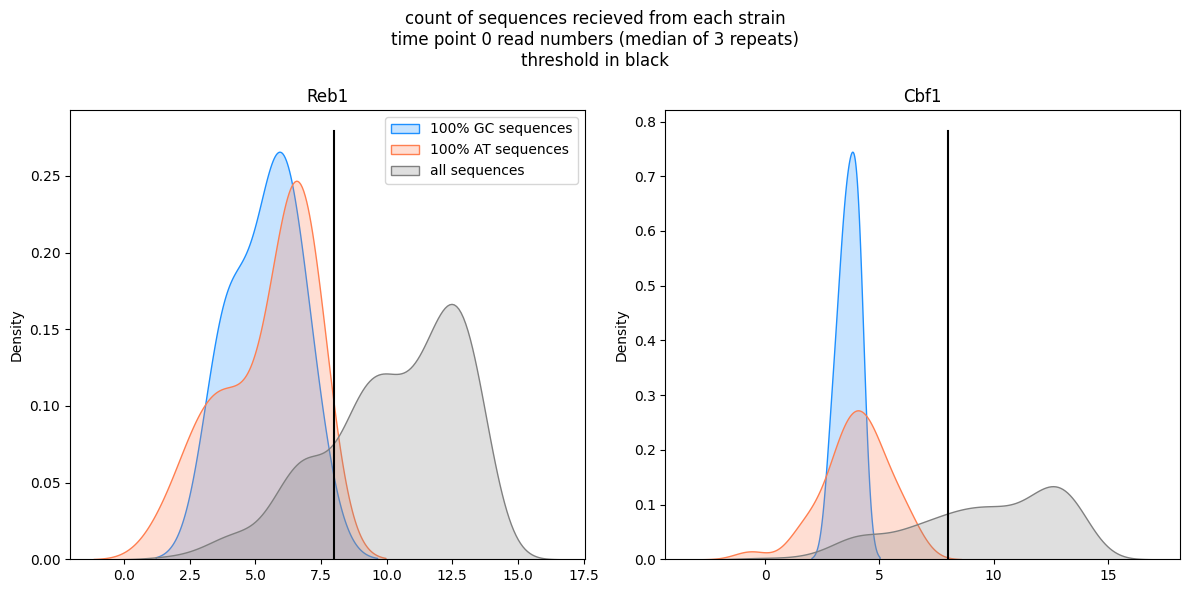

In [288]:
# load data

def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
          
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2) 
    # lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

      
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    med_180.columns = pd.DataFrame({0:med_0,1:med_0,2:med_0}).columns
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows





Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
res_dict = {}
threshold = 0
strains_list = [Msn2_strains, strains_2]
libs_list    = [Msn2_libs, libs_2]


for strain_list_i, strains in enumerate( strains_list ):
 
    for strain_i, strain in enumerate(strains):
        
        if strain == 'freeMnase':
            os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
            rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
            exp_num = 30
        else:
            os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
            rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
            exp_num = 29
            
        for lib_i, lib in enumerate(libs_list[strain_list_i][strain_i]):
            thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len( libs_list[strain_list_i][strain_i] )] * len(strains)] 
            thsld = thsld_list_8[strain_i][lib_i]
            
            lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')
            
            if strain+'_on' not in res_dict.keys():
                res_dict[strain] = lib_df
                res_dict[strain+'_on'] = on_rows
                res_dict[strain+'_off'] =  off_rows
            else:
                res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
                res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
                res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])


     
            
################ plot resutls ###################
fig, axs = plt.subplots(1,2, figsize=(12,6))
fig.suptitle('count of sequences recieved from each strain\ntime point 0 read numbers (median of 3 repeats)\nthreshold in black')
strains = ['Reb1', 'Cbf1']
# for strain_i, strain in enumerate(list(res_dict.keys())[::3]):
for strain_i, strain in enumerate(strains):

    curr_ax = np.ravel(axs)[strain_i]
    gc_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==100 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    at_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==0 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    all_vec = res_dict[strain].iloc[:,:3].median(axis=1).values

    sns.kdeplot( gc_vec, color='dodgerblue', fill=True, label='100% GC sequences', ax=curr_ax)
    sns.kdeplot( at_vec, color='coral', fill=True, label='100% AT sequences', ax=curr_ax)
    sns.kdeplot( all_vec, color='gray', fill=True, label='all sequences', ax=curr_ax)
    if strain_i ==0:
        curr_ax.legend()
    ymax = curr_ax.get_ylim()[1]  # Get the maximum y-value
    curr_ax.set_title(strain)
    curr_ax.plot([8,8],[0,ymax], color='black',label='threshold')
plt.tight_layout()


## Figure S1D - top bound STRs in Reb1, Cbf1 and Mot3

In [ ]:
''' top sequences for on+off avg '''
strains = ['Reb1', 'Cbf1', 'Mot3']
for strain_i, strain in enumerate(strains):
    curr_df = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('_on','_off'), left_index=True, right_index=True )
    curr_df = curr_df.loc[:,curr_df.columns.str.contains('delta_median')]
    curr_df['avg_delta_median'] = curr_df.mean(axis=1)
    curr_df = curr_df.sort_values(by='avg_delta_median')
    curr_df['group'] = curr_df.index.map(lambda x: assign_seq_group(x))
    curr_df['group_color'] = curr_df['group'].map(lambda x: 'orangered' if x[0] == 'AGG' else 'dodgerblue' if x[0] == 'AT_rich' else 'darkviolet' if x[0] == '3G' else 'black')
    
    plt.figure(figsize=(15,3))
    plt.title(strain+' top 15 '+'on+off avg'+' sequences')
    ax = sns.heatmap(curr_df.avg_delta_median[:15].values.reshape(1, -1), annot=True, fmt=".2f", xticklabels=curr_df.index[:15], cmap='PuBu_r')
    for tick_label, color in zip(ax.get_xticklabels(), curr_df['group_color'][:15]):
        tick_label.set_color(color)
    
    plt.show()


## Figure S1E - percentage of sequences passing read count threshold in Mot3

In [ ]:
# load data

def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
          
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2) 
    # lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

      
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    med_180.columns = pd.DataFrame({0:med_0,1:med_0,2:med_0}).columns
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows





Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
res_dict = {}
threshold = 0
strains_list = [Msn2_strains, strains_2]
libs_list    = [Msn2_libs, libs_2]


for strain_list_i, strains in enumerate( strains_list ):
 
    for strain_i, strain in enumerate(strains):
        
        if strain == 'freeMnase':
            os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
            rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
            exp_num = 30
        else:
            os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
            rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
            exp_num = 29
            
        for lib_i, lib in enumerate(libs_list[strain_list_i][strain_i]):
            thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len( libs_list[strain_list_i][strain_i] )] * len(strains)] 
            thsld = thsld_list_8[strain_i][lib_i]
            
            lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')
            
            if strain+'_on' not in res_dict.keys():
                res_dict[strain] = lib_df
                res_dict[strain+'_on'] = on_rows
                res_dict[strain+'_off'] =  off_rows
            else:
                res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
                res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
                res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])


     
            
################ plot resutls ###################
fig, axs = plt.subplots(1,1, figsize=(6,6))
fig.suptitle('count of sequences recieved from each strain\ntime point 0 read numbers (median of 3 repeats)\nthreshold in black')
strains = ['Mot3']
# for strain_i, strain in enumerate(list(res_dict.keys())[::3]):
for strain_i, strain in enumerate(strains):

    curr_ax = np.ravel(axs)[strain_i]
    gc_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==100 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    at_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==0 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    all_vec = res_dict[strain].iloc[:,:3].median(axis=1).values

    sns.kdeplot( gc_vec, color='dodgerblue', fill=True, label='100% GC sequences', ax=curr_ax)
    sns.kdeplot( at_vec, color='coral', fill=True, label='100% AT sequences', ax=curr_ax)
    sns.kdeplot( all_vec, color='gray', fill=True, label='all sequences', ax=curr_ax)
    if strain_i ==0:
        curr_ax.legend()
    ymax = curr_ax.get_ylim()[1]  # Get the maximum y-value
    curr_ax.set_title(strain)
    curr_ax.plot([8,8],[0,ymax], color='black',label='threshold')
plt.tight_layout()

## Figure S1F - score vs. std error in Mot3

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(8,9) )
marker_dict = {'on':'s','off':'s'}
color_dict = {'on':'coral','off':'purple'}
strains = ['Mot3','Cbf1','Reb1']
for strain_i, strain in enumerate(strains[:1]):
    curr_ax = np.ravel(axs)[strain_i]
    for c_on_i, c_on in enumerate(['on','off']):
        curr_y =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median
        curr_x =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median.rank()
        

        curr_hue = combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').std_error
        sns.scatterplot(x= curr_x,y= curr_y, color=color_dict[c_on], marker=marker_dict[c_on], label=c_on, ax=curr_ax)
        curr_ax.errorbar(x= curr_x, y=curr_y, yerr=curr_hue, fmt='.', alpha=0.8, color='black', zorder=0)
        
        curr_ax.set_title('sorted std error in '+strain+' colored by score', fontsize=16)
        curr_ax.set_xlabel('rank')
        curr_ax.set_ylabel('std_error')


## Figure S1G - correlation between technical repeats and between activated and non activated samples in Mot3

In [ ]:
''' correlate 1 TF, its 3 repeates '''
strains = ['Mot3', 'Cbf1', 'Reb1', 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'freeMnase']
for strain_i, strain in enumerate(strains[:1]):
    curr_df = pd.DataFrame()
    curr_df = res_dict[strain].iloc[:,:6]
    plt.figure(figsize=(8, 8) )
    sns.heatmap(curr_df.corr(), annot=True, square=True)
    plt.title('correlation 3 repeates of ' +strain, fontsize=16)

    plt.show()

## Figure S1H - sequence distribution of mutated and intact motif sequences in Mot3

In [ ]:
''' show dist before cyclic grouping '''
''' note: run after importing Mot3 data with a threshold of 8 '''

strains = [ 'Mot3' ]
fig, axs = plt.subplots(1,1, figsize=(6,6) )
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]

    
    ''' make a sworm plot '''
    curr_df = pd.DataFrame()
    min_percent = 2.5
    max_percent = 97.5
    mn, mx = np.percentile(res_dict[strain].query("on_state=='off'").delta_med180_med0, [min_percent, max_percent])
    curr_off = res_dict[strain].query("on_state=='off' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0        # use when showing 95 percent of results

    mn, mx = np.percentile(res_dict[strain].query("on_state=='on'").delta_med180_med0, [min_percent, max_percent])
    curr_on= res_dict[strain].query("on_state=='on' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0
    
    curr_df = pd.concat( [curr_off, curr_on ] )
    groups = ['off'] * len(curr_off) + ['on'] * len(curr_on)
    
    med_off = curr_off.median()
    med_on = curr_on.median()
    print(strain, med_off-med_on)
    
    sns.violinplot(y=curr_df, x=groups, ax=curr_ax, palette='plasma')
    sns.swarmplot(y=curr_df, x=groups, ax=curr_ax, color='ivory', s=3, zorder=3)

   

    curr_ax.legend()
    curr_ax.set_ylabel('score',fontsize=14)
    curr_ax.set_title('100% of on and off score distributions in\n'+ strain+'\nbefore cyclic grouping', fontsize=14)


# Figure S2

## Figure S2A - sequences passing read count threshold, bars, for Msn2 FL and free Mnase

In [ ]:
# load data

def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
          
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)
    if threshold!=0:
        lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

      
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    med_180.columns = pd.DataFrame({0:med_0,1:med_0,2:med_0}).columns
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows





Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
# res_dict = {}
threshold = 0
strains_list = [Msn2_strains, strains_2]
libs_list    = [Msn2_libs, libs_2]
thrs_seq_count_dict = {}

for threshold in [0,8]:
    res_dict = {}

    for strain_list_i, strains in enumerate( strains_list ):

        for strain_i, strain in enumerate(strains):

            if strain == 'freeMnase':
                os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
                rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
                exp_num = 30
            else:
                os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
                rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
                exp_num = 29

            for lib_i, lib in enumerate(libs_list[strain_list_i][strain_i]):
                thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len( libs_list[strain_list_i][strain_i] )] * len(strains)] 
                thsld = thsld_list_8[strain_i][lib_i]

                lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')

                if strain+'_on' not in res_dict.keys():
                    res_dict[strain] = lib_df
                    res_dict[strain+'_on'] = on_rows
                    res_dict[strain+'_off'] =  off_rows
                else:
                    res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
                    res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
                    res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])

    # count sequences in each strain for threshold 8 and threshold 0
    for strain in list(res_dict.keys())[::3]:
        thrs_seq_count_dict[strain+'_on_thrs_'+str(threshold)]  = res_dict[strain].query("on_state=='on'").shape[0]
        thrs_seq_count_dict[strain+'_off_thrs_'+str(threshold)] = res_dict[strain].query("on_state=='off'").shape[0]

        
two_to_four_bp_library_total = 668
two_to_five_bp_library_total = 1904
read_count_df = pd.DataFrame(columns=['on_reads','off_reads','total_reads','above_thrs_reads','above_thrs_percentage_from_detected', 'above_thrs_percentage_from_library'])
for strain in ['Msn2', 'freeMnase']:
    read_count_df.loc[strain, 'on_reads'] = thrs_seq_count_dict[strain+'_on_thrs_0']
    read_count_df.loc[strain, 'off_reads'] = thrs_seq_count_dict[strain+'_off_thrs_0']
    
    total_reads = thrs_seq_count_dict[strain+'_on_thrs_0'] + thrs_seq_count_dict[strain+'_off_thrs_0']
    above_thrs_reads = thrs_seq_count_dict[strain+'_on_thrs_8'] + thrs_seq_count_dict[strain+'_off_thrs_8']
    
    read_count_df.loc[strain, 'total_reads'] = total_reads
    read_count_df.loc[strain, 'above_thrs_reads'] = above_thrs_reads
    read_count_df.loc[strain, 'above_thrs_percentage_from_detected'] = ( above_thrs_reads / total_reads ) * 100
    read_count_df.loc[strain, 'above_thrs_percentage_from_library' ] = ( above_thrs_reads / two_to_five_bp_library_total ) * 100

plt.figure(figsize=(10,4))
sns.barplot(data=read_count_df, x=read_count_df.index, y='above_thrs_percentage_from_library')
plt.title('% of sequences above threshold / percentage out of original library')



## Figure S2B

In [ ]:
# load data

def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
          
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2) 
    # lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

      
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    med_180.columns = pd.DataFrame({0:med_0,1:med_0,2:med_0}).columns
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows





Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
res_dict = {}
threshold = 0
strains_list = [Msn2_strains, strains_2]
libs_list    = [Msn2_libs, libs_2]


for strain_list_i, strains in enumerate( strains_list ):
 
    for strain_i, strain in enumerate(strains):
        
        if strain == 'freeMnase':
            os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
            rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
            exp_num = 30
        else:
            os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
            rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
            exp_num = 29
            
        for lib_i, lib in enumerate(libs_list[strain_list_i][strain_i]):
            thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len( libs_list[strain_list_i][strain_i] )] * len(strains)] 
            thsld = thsld_list_8[strain_i][lib_i]
            
            lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')
            
            if strain+'_on' not in res_dict.keys():
                res_dict[strain] = lib_df
                res_dict[strain+'_on'] = on_rows
                res_dict[strain+'_off'] =  off_rows
            else:
                res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
                res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
                res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])


     
            
################ plot resutls ###################
fig, axs = plt.subplots(1,1, figsize=(6,6))
fig.suptitle('count of sequences recieved from each strain\ntime point 0 read numbers (median of 3 repeats)\nthreshold in black')
strains = ['Msn2']
# for strain_i, strain in enumerate(list(res_dict.keys())[::3]):
for strain_i, strain in enumerate(strains):

    curr_ax = np.ravel(axs)[strain_i]
    gc_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==100 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    at_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==0 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    all_vec = res_dict[strain].iloc[:,:3].median(axis=1).values

    sns.kdeplot( gc_vec, color='dodgerblue', fill=True, label='100% GC sequences', ax=curr_ax)
    sns.kdeplot( at_vec, color='coral', fill=True, label='100% AT sequences', ax=curr_ax)
    sns.kdeplot( all_vec, color='gray', fill=True, label='all sequences', ax=curr_ax)
    if strain_i ==0:
        curr_ax.legend()
    ymax = curr_ax.get_ylim()[1]  # Get the maximum y-value
    curr_ax.set_title(strain)
    curr_ax.plot([8,8],[0,ymax], color='black',label='threshold')
plt.tight_layout()


## Figure S2C - correlation between technical repeats and between activated and non activated samples in free Mnase

In [ ]:
''' correlate 1 TF, its 3 repeates '''
strains = ['Mot3', 'Cbf1', 'Reb1', 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'freeMnase']
for strain_i, strain in enumerate(strains[6:]):
    curr_df = pd.DataFrame()
    curr_df = res_dict[strain].iloc[:,:6]
    plt.figure(figsize=(8, 8) )
    sns.heatmap(curr_df.corr(), annot=True, square=True)
    plt.title('correlation 3 repeates of ' +strain, fontsize=16)

    plt.show()

## Figure S2D - score vs. std error in free Mnase

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(8,7) )
marker_dict = {'on':'s','off':'s'}
color_dict = {'on':'coral','off':'purple'}
strains = ['freeMnase']
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]
    for c_on_i, c_on in enumerate(['on','off']):
        curr_y =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median
        curr_x =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median.rank()
        

        curr_hue = combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').std_error
        sns.scatterplot(x= curr_x,y= curr_y, color=color_dict[c_on], marker=marker_dict[c_on], label=c_on, ax=curr_ax)
        curr_ax.errorbar(x= curr_x, y=curr_y, yerr=curr_hue, fmt='.', alpha=0.8, color='black', zorder=0)
        
        curr_ax.set_title('sorted std error in '+strain+' colored by score', fontsize=16)
        curr_ax.set_xlabel('rank')
        curr_ax.set_ylabel('std_error')


## Figure S2E - sequence distribution of mutated and intact motif sequences in Mot3

In [ ]:
''' show dist before cyclic grouping '''
strains = [ 'Msn2', 'freeMnase' ]
fig, axs = plt.subplots(1,2, figsize=(12,6) )
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]

    
    ''' make a sworm plot '''
    curr_df = pd.DataFrame()
    min_percent = 2.5
    max_percent = 97.5
    mn, mx = np.percentile(res_dict[strain].query("on_state=='off'").delta_med180_med0, [min_percent, max_percent])
    curr_off = res_dict[strain].query("on_state=='off' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0        # use when showing 95 percent of results

    mn, mx = np.percentile(res_dict[strain].query("on_state=='on'").delta_med180_med0, [min_percent, max_percent])
    curr_on= res_dict[strain].query("on_state=='on' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0
    
    curr_df = pd.concat( [curr_off, curr_on ] )
    groups = ['off'] * len(curr_off) + ['on'] * len(curr_on)
    
    med_off = curr_off.median()
    med_on = curr_on.median()
    print(strain, med_off-med_on)
    
    sns.violinplot(y=curr_df, x=groups, ax=curr_ax, palette='plasma')
    sns.swarmplot(y=curr_df, x=groups, ax=curr_ax, color='ivory', s=3, zorder=3)

   

    curr_ax.legend()
    curr_ax.set_ylabel('score',fontsize=14)
    curr_ax.set_title('100% of on and off score distributions in\n'+ strain+'\nbefore cyclic grouping', fontsize=14)


# Figure S3

## remove bad samples function

In [323]:
# path for rm_samples function .csv
rm_samples_path = os.path.join(curr_data_path, 'data')
def rm_samples(tf, lib_num, exp_num, res_table):
    '''This function removes from the result table the samples classified as bad. It gets the result table
    (before or after normalization) and the relevant tf, library number and experiment number.'''
    exp_num = int(exp_num)
    samples_to_remove = pd.read_csv(os.path.join(rm_samples_path, 'samples_to_remove.csv'))
    # read csv containing info about samples to remove
    curr_samples_to_rm = samples_to_remove.loc[(samples_to_remove['Lib_number'] == str(lib_num)) &
                                               (samples_to_remove['Exp_number'] == exp_num) &
                                               (samples_to_remove['TF'] == tf)]
    # get the names of samples to remove relevant to the input
    max_tech_rep_num = max(
        [int(name.split('_')[-1]) for name in res_table.columns])  # number of time point repeats in the experiment
    var_num = len(res_table)  # number of variants
    samples_to_rm_names = curr_samples_to_rm['Sample_name']  # the sample names that will be removed
    
    sample_bio_rep = np.array(
        [int(name.split('_')[0]) for name in samples_to_rm_names])  # the bio repeats of the bad samples
    sample_tps = np.array(
        [int(name.split('_')[1]) for name in samples_to_rm_names])  # the time point of the bad samples

    bad_bio_rep = ''
    for i, samp in enumerate(samples_to_rm_names):  # iterate over the names of samples to remove
        curr_tp = sample_tps[i]  # current time point
        curr_bio_rep = sample_bio_rep[i]  # current bio repeat
        np.unique(res_table.columns.str.split('_')[0])
        curr_biorep_tp = str(curr_bio_rep) + '_' + str(curr_tp) + '_'
        same_tp_biorep_samples_rm = [s for i, s in enumerate(samples_to_rm_names.values) if
                                     curr_biorep_tp in samples_to_rm_names.values[i]]
        # get all sample names to remove with the current tp and bio repeat
        all_bio_rep_tp_samples = res_table.columns[res_table.columns.str.contains(curr_biorep_tp)]
        # get all sample names (good and bad samples) from same tp and bio repeat as current sample
        good_samples = [s for s in all_bio_rep_tp_samples if sum(samples_to_rm_names.str.contains(s)) == 0]
        # returns only samples from the same time point and bio repeat that are good

        if (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 2):
            # when removing only one tp repeat of the bio repeat and there are 2 time point repeats
            res_table[samp] = res_table[good_samples]  # change bad sample values to the other good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 2):
            # when removing 2 tp repeats of the bio repeat and there are 2 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]  # change bad sample values to nans
            bad_bio_rep = str(curr_bio_rep)  # in case one bio repeat has an entire tp to remove - save the bio repeat number
        elif (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 3):
            # when removing only one tp repeat of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[res_table.columns.intersection(good_samples)].mean(axis=1)
            # change bad sample values to the mean of the other good time point repeats
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 3):
            # when removing 2 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[good_samples]
            # change bad sample values to the one good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 3) & (max_tech_rep_num == 3):
            # when removing 3 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]
            # change bad sample values to nans (no such scenario so far)
            bad_bio_rep = str(curr_bio_rep)
            # in case one bio repeat has an entire tp to remove - save the bio repeat number

    res_table_scatter = res_table.copy()  # copy the result table
    if bad_bio_rep:  # when one bio repeat has an entire tp to remove
        all_bio_rep = res_table_scatter.columns.str.split('_').str[0]  # get all the bio repeat sample names
        res_table_scatter[res_table_scatter.columns[all_bio_rep == bad_bio_rep]] = res_table_scatter[
            res_table_scatter.columns[all_bio_rep != bad_bio_rep]]
        # copy the "good" bio repeat instead of the "bad" ones
    return res_table, res_table_scatter

## Figure S3A - sequences passing read count threshold, bars, for Msn2 DBD OE and Msn2 non-DBD OE

In [ ]:
# load data

def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
          
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)
    if threshold!=0:
        lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

      
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    med_180.columns = pd.DataFrame({0:med_0,1:med_0,2:med_0}).columns
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows





Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
# res_dict = {}
threshold = 0
strains_list = [Msn2_strains, strains_2]
libs_list    = [Msn2_libs, libs_2]
thrs_seq_count_dict = {}

for threshold in [0,8]:
    res_dict = {}

    for strain_list_i, strains in enumerate( strains_list ):

        for strain_i, strain in enumerate(strains):

            if strain == 'freeMnase':
                os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
                rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
                exp_num = 30
            else:
                os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
                rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
                exp_num = 29

            for lib_i, lib in enumerate(libs_list[strain_list_i][strain_i]):
                thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len( libs_list[strain_list_i][strain_i] )] * len(strains)] 
                thsld = thsld_list_8[strain_i][lib_i]

                lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')

                if strain+'_on' not in res_dict.keys():
                    res_dict[strain] = lib_df
                    res_dict[strain+'_on'] = on_rows
                    res_dict[strain+'_off'] =  off_rows
                else:
                    res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
                    res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
                    res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])

    # count sequences in each strain for threshold 8 and threshold 0
    for strain in list(res_dict.keys())[::3]:
        thrs_seq_count_dict[strain+'_on_thrs_'+str(threshold)]  = res_dict[strain].query("on_state=='on'").shape[0]
        thrs_seq_count_dict[strain+'_off_thrs_'+str(threshold)] = res_dict[strain].query("on_state=='off'").shape[0]

        
two_to_four_bp_library_total = 668
two_to_five_bp_library_total = 1904
read_count_df = pd.DataFrame(columns=['on_reads','off_reads','total_reads','above_thrs_reads','above_thrs_percentage_from_detected', 'above_thrs_percentage_from_library'])
for strain in ['Msn2DBDOE', 'Msn2NONDBDOE']:
    read_count_df.loc[strain, 'on_reads'] = thrs_seq_count_dict[strain+'_on_thrs_0']
    read_count_df.loc[strain, 'off_reads'] = thrs_seq_count_dict[strain+'_off_thrs_0']
    
    total_reads = thrs_seq_count_dict[strain+'_on_thrs_0'] + thrs_seq_count_dict[strain+'_off_thrs_0']
    above_thrs_reads = thrs_seq_count_dict[strain+'_on_thrs_8'] + thrs_seq_count_dict[strain+'_off_thrs_8']
    
    read_count_df.loc[strain, 'total_reads'] = total_reads
    read_count_df.loc[strain, 'above_thrs_reads'] = above_thrs_reads
    read_count_df.loc[strain, 'above_thrs_percentage_from_detected'] = ( above_thrs_reads / total_reads ) * 100
    read_count_df.loc[strain, 'above_thrs_percentage_from_library' ] = ( above_thrs_reads / two_to_five_bp_library_total ) * 100

plt.figure(figsize=(10,4))
sns.barplot(data=read_count_df, x=read_count_df.index, y='above_thrs_percentage_from_library')
plt.title('% of sequences above threshold / percentage out pf original library')


## Figure S3B

In [ ]:
# load data

def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
    # print((strain, lib, exp_num, lib_df)      
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2) 
    # lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

      
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    med_180.columns = pd.DataFrame({0:med_0,1:med_0,2:med_0}).columns
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows





# Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
res_dict = {}
threshold = 0
strains_list = [Msn2_strains, strains_2]
libs_list    = [Msn2_libs, libs_2]


for strain_list_i, strains in enumerate( strains_list[:1] ):
 
    for strain_i, strain in enumerate(strains):

        # if strain == 'freeMnase':
        #     os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
        #     rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
        #     exp_num = 30
        # else:
        os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
        rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
        exp_num = 29
        for lib_i, lib in enumerate(libs_list[strain_list_i][strain_i]):
            thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len( libs_list[strain_list_i][strain_i] )] * len(strains)] 
            thsld = thsld_list_8[strain_i][lib_i]

            lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')

            if strain+'_on' not in res_dict.keys():
                res_dict[strain] = lib_df
                res_dict[strain+'_on'] = on_rows
                res_dict[strain+'_off'] =  off_rows
            else:
                res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
                res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
                res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])


     
            
################ plot resutls ###################
# fig, axs = plt.subplots(1,2, figsize=(12,6))
# fig.suptitle('count of sequences recieved from each strain\ntime point 0 read numbers (median of 3 repeats)\nthreshold in black')
# strains = ['Msn2DBDOE','Msn2NONDBDOE']
# # for strain_i, strain in enumerate(list(res_dict.keys())[::3]):
# for strain_i, strain in enumerate(strains):

#     curr_ax = np.ravel(axs)[strain_i]
#     gc_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==100 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
#     at_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==0 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
#     all_vec = res_dict[strain].iloc[:,:3].median(axis=1).values

#     sns.kdeplot( gc_vec, color='dodgerblue', fill=True, label='100% GC sequences', ax=curr_ax)
#     sns.kdeplot( at_vec, color='coral', fill=True, label='100% AT sequences', ax=curr_ax)
#     sns.kdeplot( all_vec, color='gray', fill=True, label='all sequences', ax=curr_ax)
#     if strain_i ==0:
#         curr_ax.legend()
#     ymax = curr_ax.get_ylim()[1]  # Get the maximum y-value
#     curr_ax.set_title(strain)
#     curr_ax.plot([8,8],[0,ymax], color='black',label='threshold')
# plt.tight_layout()


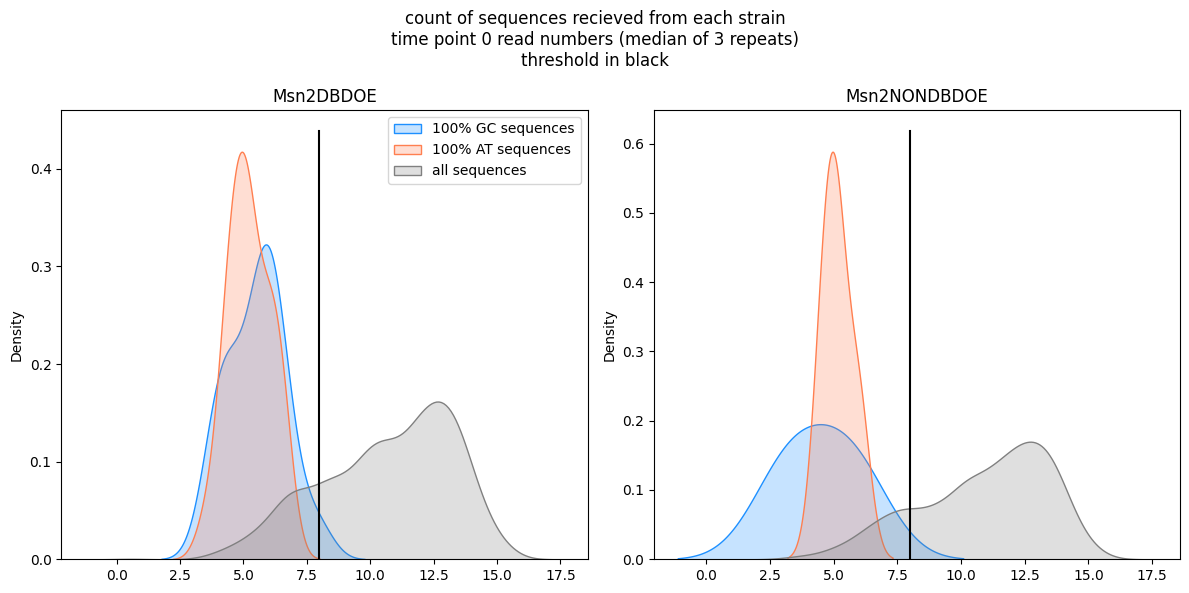

In [328]:
############### plot resutls ###################
fig, axs = plt.subplots(1,2, figsize=(12,6))
fig.suptitle('count of sequences recieved from each strain\ntime point 0 read numbers (median of 3 repeats)\nthreshold in black')
strains = ['Msn2DBDOE','Msn2NONDBDOE']
# for strain_i, strain in enumerate(list(res_dict.keys())[::3]):
for strain_i, strain in enumerate(strains):

    curr_ax = np.ravel(axs)[strain_i]
    gc_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==100 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    at_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==0 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    all_vec = res_dict[strain].iloc[:,:3].median(axis=1).values

    sns.kdeplot( gc_vec, color='dodgerblue', fill=True, label='100% GC sequences', ax=curr_ax)
    sns.kdeplot( at_vec, color='coral', fill=True, label='100% AT sequences', ax=curr_ax)
    sns.kdeplot( all_vec, color='gray', fill=True, label='all sequences', ax=curr_ax)
    if strain_i ==0:
        curr_ax.legend()
    ymax = curr_ax.get_ylim()[1]  # Get the maximum y-value
    curr_ax.set_title(strain)
    curr_ax.plot([8,8],[0,ymax], color='black',label='threshold')
plt.tight_layout()

## Figure S3C - correlation between technical repeats and between activated and non activated samples in Msn2 DBD OE and Msn2 non-DBD OE

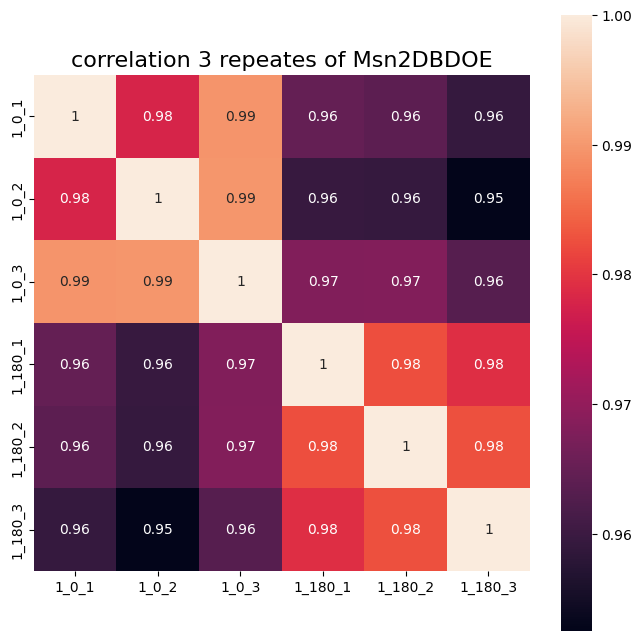

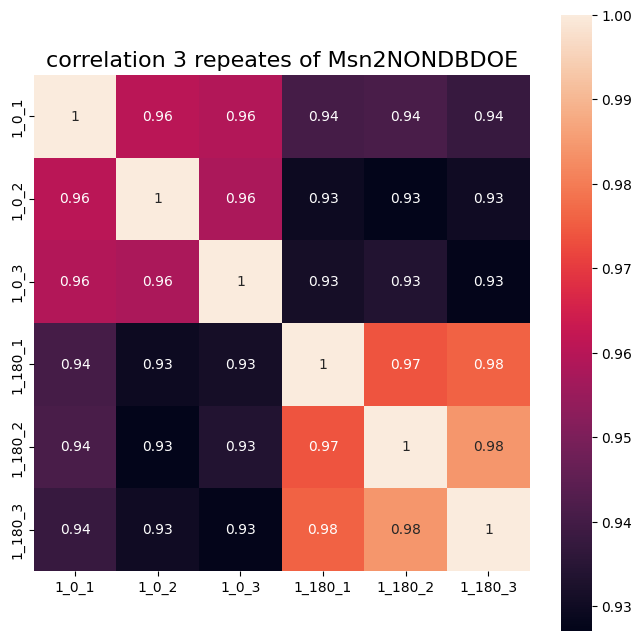

In [329]:
''' correlate 1 TF, its 3 repeates '''
strains = [ 'Msn2DBDOE', 'Msn2NONDBDOE']
for strain_i, strain in enumerate(strains):
    curr_df = pd.DataFrame()
    curr_df = res_dict[strain].iloc[:,:6]
    plt.figure(figsize=(8, 8) )
    sns.heatmap(curr_df.corr(), annot=True, square=True)
    plt.title('correlation 3 repeates of ' +strain, fontsize=16)

    plt.show()

## Figure S3D - score vs. std error in Msn2 DBD OE and Msn2 non-DBD OE

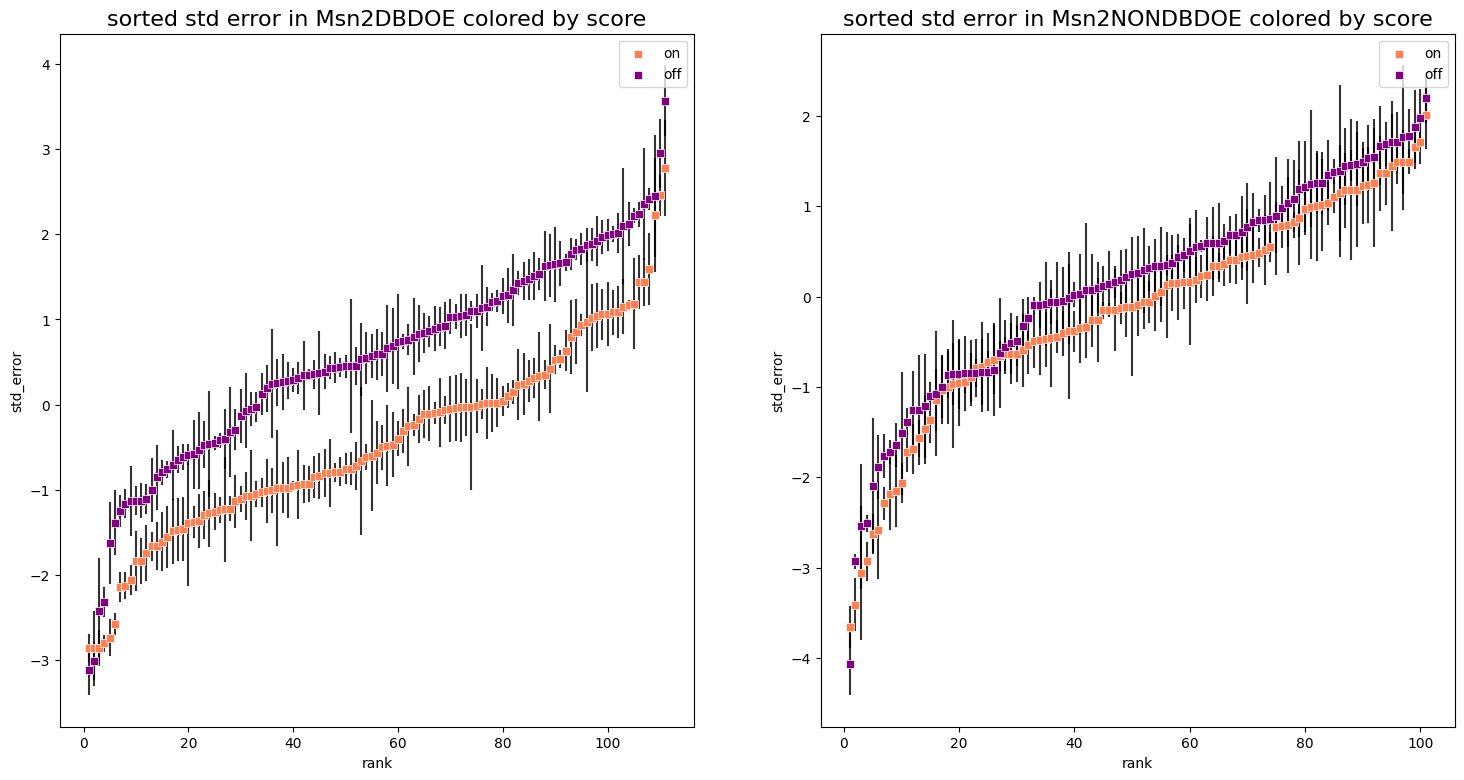

In [330]:
fig, axs = plt.subplots(1,2, figsize=(18,9) )
marker_dict = {'on':'s','off':'s'}
color_dict = {'on':'coral','off':'purple'}
strains = ['Msn2DBDOE','Msn2NONDBDOE']
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]
    for c_on_i, c_on in enumerate(['on','off']):
        curr_y =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median
        curr_x =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median.rank()
        

        curr_hue = combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').std_error
        sns.scatterplot(x= curr_x,y= curr_y, color=color_dict[c_on], marker=marker_dict[c_on], label=c_on, ax=curr_ax)
        curr_ax.errorbar(x= curr_x, y=curr_y, yerr=curr_hue, fmt='.', alpha=0.8, color='black', zorder=0)
        
        curr_ax.set_title('sorted std error in '+strain+' colored by score', fontsize=16)
        curr_ax.set_xlabel('rank')
        curr_ax.set_ylabel('std_error')


## Figure S3E - scatter of Msn2 DBD OE and Msn2 non-DBD OE vs. free Mnase

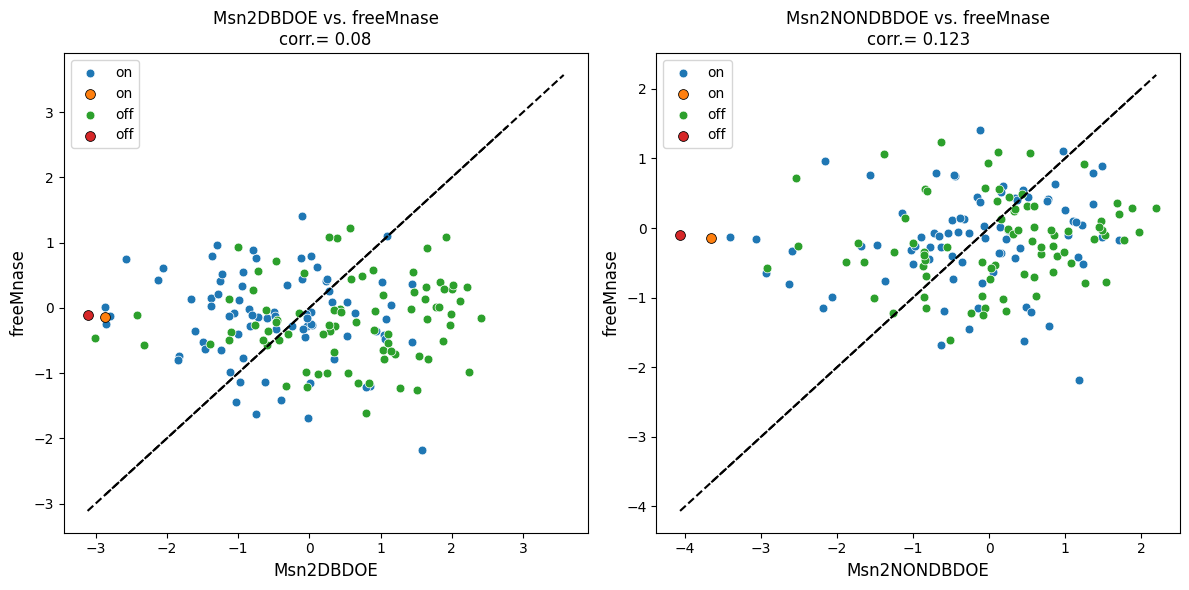

In [331]:
''' plot TF 1 vs. TF 2, omit dots with a signle sequence '''

strains = ['Msn2DBDOE','Msn2NONDBDOE', 'freeMnase']
fig, axs = plt.subplots(1, 2, figsize=(12,6) )


strain_combo_list = [(0,2),(1,2)]
for fig_i, strain_combo in enumerate(strain_combo_list):
    strain1 = strain_combo[0]
    strain2 = strain_combo[1]
    curr_ax = np.ravel(axs)[fig_i]
    for c_on in ['on','off']:
        curr_df = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened']
        samp_on = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened'].delta_median
        samp_off = combined_seq_dict[strains[strain2]+'_'+c_on+'_screened'].delta_median

        genome_df = pd.DataFrame()
        genome_df.loc['genome','on'] = samp_on.genome
        genome_df.loc['genome','off'] = samp_off.genome

        # plot a scatter Tf 1 vs. TF 2

        curr_corr = np.round(pd.concat([samp_on,samp_off],axis=1).corr().iloc[0,1],3)
        sns.scatterplot(x=samp_on, y=samp_off, s=40,  ax=curr_ax, label=c_on, legend=False)
        sns.scatterplot(x=genome_df['on'], y=genome_df['off'], edgecolor='black', s=50, ax=curr_ax, label=c_on, zorder=1, legend=False)


        min_val = min(np.nanmin(samp_on), np.nanmin(samp_off))
        max_val = max(np.nanmax(samp_on), np.nanmax(samp_off))

        curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
        curr_ax.set_title(strains[strain1]+' vs. '+strains[strain2]+'\ncorr.= '+str(curr_corr), fontsize=12 )
        curr_ax.set_xlabel(strains[strain1],fontsize=12)
        curr_ax.set_ylabel(strains[strain2],fontsize=12)
        curr_ax.legend()
        plt.tight_layout()
        

# Figure S4

## Figure S4A-B: Msn2, Msn2 non-DBD and Msn2 non-DBD dMsn4 scatters

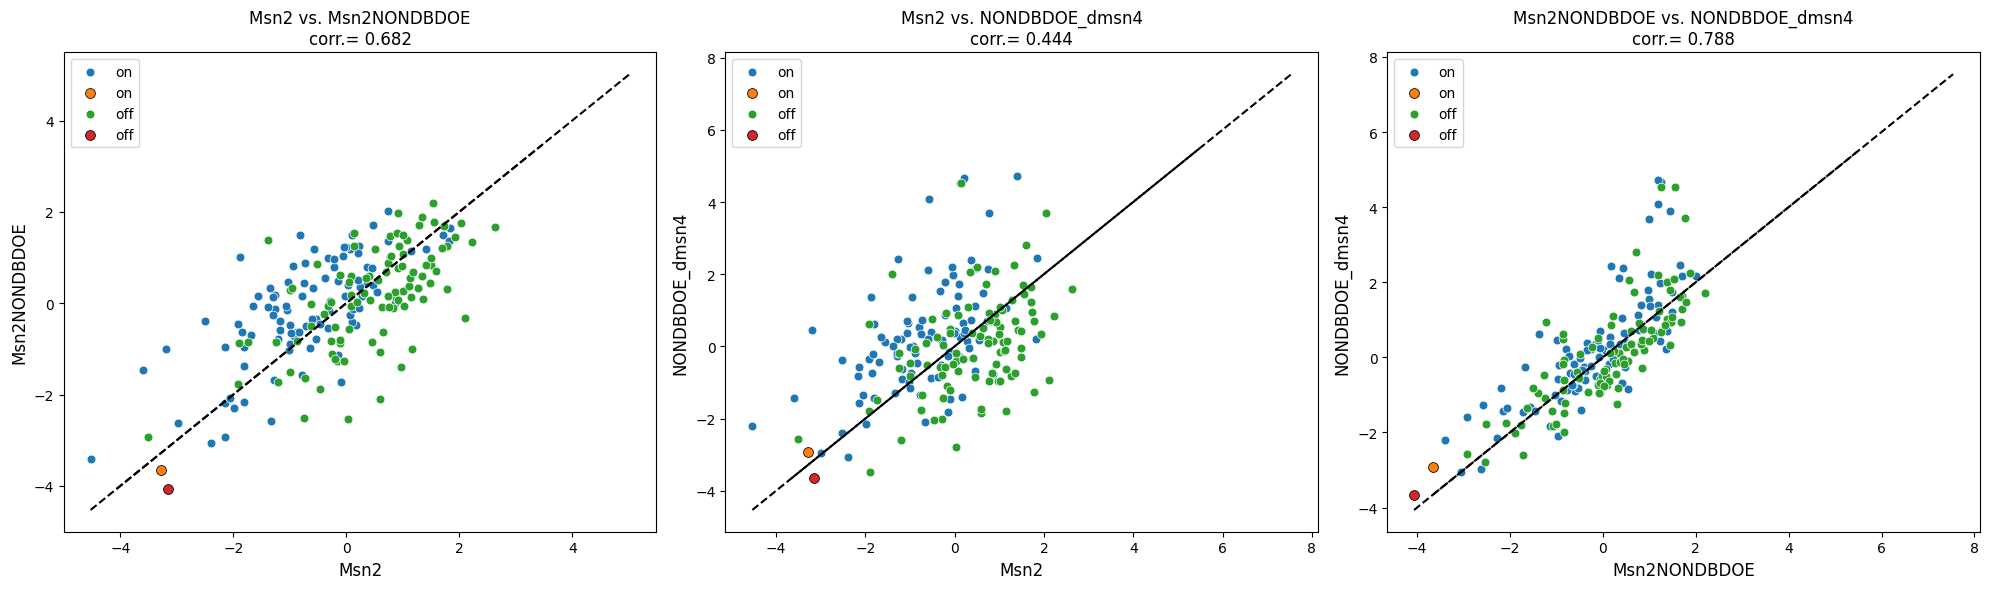

In [334]:
''' plot TF 1 vs. TF 2, hide dots with a signle sequence '''

strains = ['Msn2_LIVFtoY', 'Msn2_DEKRtoN', 'Msn2_NtoH', 'Msn2', 'Msn2DBDOE','Msn2NONDBDOE', 'Med15', 'NONDBDOE_dmsn4', 'Med15_ddmsns']
fig, axs = plt.subplots(1, 3, figsize=(20,6) )

strain_combos = [(3,5),(3,7),(5,7)]
for comb_i, strain_comb in enumerate(strain_combos):
    strain1 = strain_comb[0]
    strain2 = strain_comb[1]
    curr_ax = np.ravel(axs)[comb_i]
    corr_df = pd.DataFrame()
    for c_on in ['on','off']:
        curr_df = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened']
        samp_on = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened'].delta_median
        samp_off = combined_seq_dict[strains[strain2]+'_'+c_on+'_screened'].delta_median

        
        half_corr_df = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened'].merge(combined_seq_dict[strains[strain2]+'_'+c_on+'_screened'], 
                                                               suffixes=( '_'+strains[strain1],'_'+strains[strain2] ),
                                                               how='inner', left_index=True, right_index=True)
        
        half_corr_df = half_corr_df.loc[:,half_corr_df.columns.str.contains('delta_median')]
        # corr_df = corr_df.append(half_corr_df, ignore_index=True)
        corr_df = pd.concat([corr_df, half_corr_df])

    
        genome_df = pd.DataFrame()
        genome_df.loc['genome','on'] = samp_on.genome
        genome_df.loc['genome','off'] = samp_off.genome

        # plot a scatter Tf 1 vs. TF 2
        curr_corr = np.round( corr_df.corr().iloc[0,1],3)
        sns.scatterplot(x=samp_on, y=samp_off, s=40,  ax=curr_ax, label=c_on, legend=False)
        sns.scatterplot(x=genome_df['on'], y=genome_df['off'], edgecolor='black', s=50, ax=curr_ax, label=c_on, zorder=1, legend=False)

        min_val = min(np.nanmin(samp_on), np.nanmin(samp_off))
        max_val = max(np.nanmax(samp_on), np.nanmax(samp_off))

        # min_val = -4.5
        # max_val = 2

        curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
        curr_ax.set_title(strains[strain1]+' vs. '+strains[strain2]+'\ncorr.= '+str(curr_corr), fontsize=12 )
        curr_ax.set_xlabel(strains[strain1],fontsize=12)
        curr_ax.set_ylabel(strains[strain2],fontsize=12)
        curr_ax.legend()
        plt.tight_layout()


## Figure S4C: Msn2 non-DBD dMsn4 score vs. error

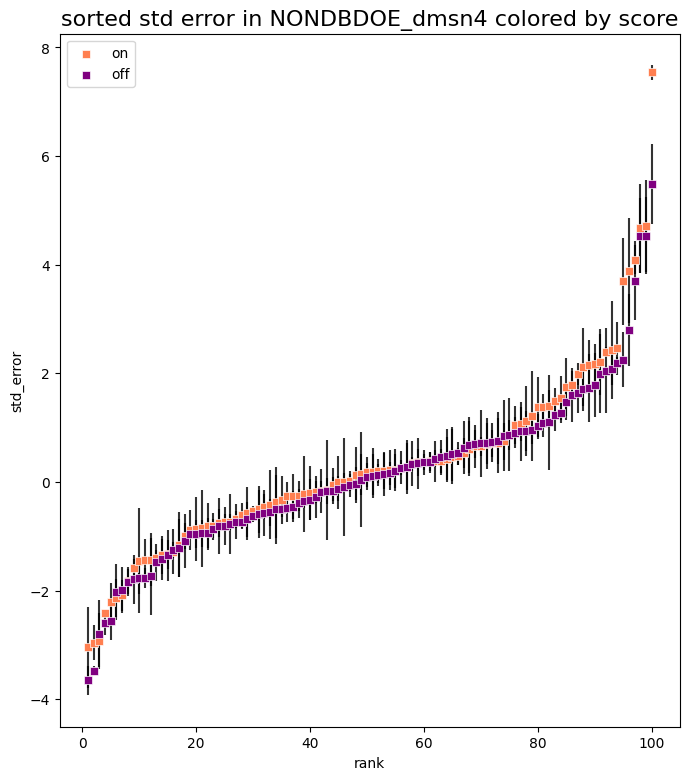

In [335]:
fig, axs = plt.subplots(1,1, figsize=(8,9) )
marker_dict = {'on':'s','off':'s'}
color_dict = {'on':'coral','off':'purple'}
strains = ['NONDBDOE_dmsn4']
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]
    for c_on_i, c_on in enumerate(['on','off']):

        curr_y =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median
        curr_x =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median.rank()
        
        if strain == 'Cbf1':
            print(c_on,curr_y.index[2])
        curr_hue = combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').std_error
        sns.scatterplot(x= curr_x,y= curr_y, color=color_dict[c_on], marker=marker_dict[c_on], label=c_on, ax=curr_ax)
        curr_ax.errorbar(x= curr_x, y=curr_y, yerr=curr_hue, fmt='.', alpha=0.8, color='black', zorder=0)
        
        curr_ax.set_title('sorted std error in '+strain+' colored by score', fontsize=16)
        curr_ax.set_xlabel('rank')
        curr_ax.set_ylabel('std_error')



## Figure S4D: correlation of Msn2, Msn2 non-DBD and Msn2 non-DBD dMsn4

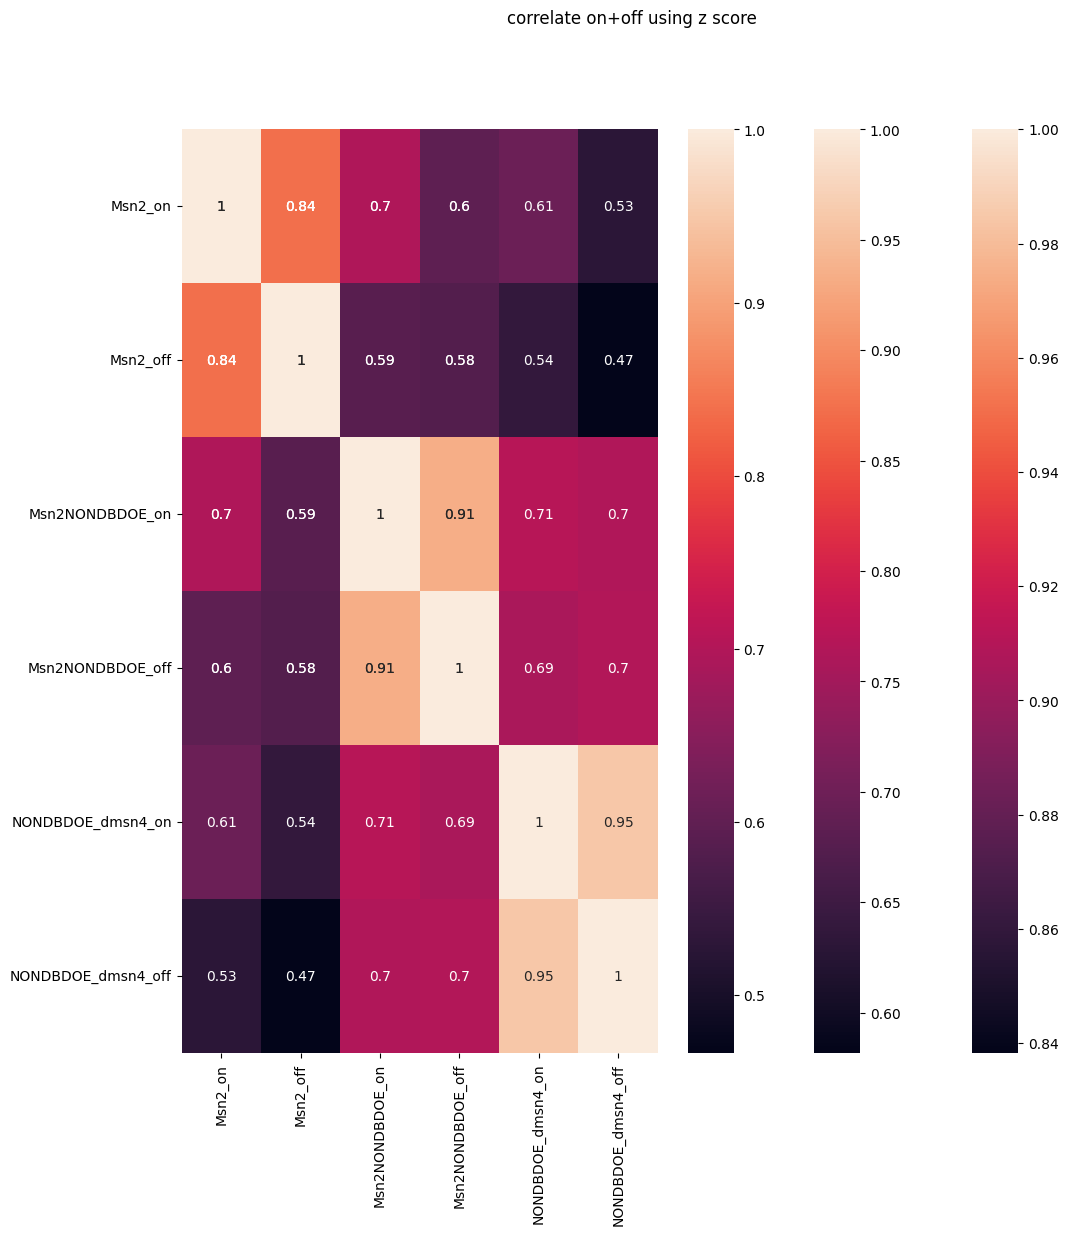

In [350]:
''' correlate strains using z score, on + off in the same plot '''
strains = ['Msn2','Msn2NONDBDOE', 'Med15', 'NONDBDOE_dmsn4', 'Med15_ddmsns']
fig, axs = plt.subplots(1,1, figsize=(12,12))
fig.suptitle('correlate on+off using z score')
corr_df = pd.DataFrame()

strains = strains[:2] + [ strains[3]]
for strain in strains:
    for c_on in ['on','off']:
        corr_df = corr_df.merge(combined_seq_dict[strain+'_'+c_on].delta_median, how='outer', left_index=True, right_index=True, suffixes=['','_'+strain+'_'+c_on])
        corr_df.columns = corr_df.columns.str.replace('delta_median',strain+'_'+c_on)
        # corr_df.columns = [col + '_' + c_on if not col.endswith(('on', 'off')) else col for col in corr_df.columns]
    # create a corrolation heatmap        
    curr_ax = axs
    sns.heatmap(corr_df.corr(), annot=True, ax=curr_ax)
    


## Figure S4E: score distribution

Msn2NONDBDOE 0.15570959234701026


/tmp/ipykernel_734330/1045678266.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=curr_df, x=groups, ax=curr_ax, palette='plasma')
/tmp/ipykernel_734330/1045678266.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  curr_ax.legend()
/tmp/ipykernel_734330/1045678266.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=curr_df, x=groups, ax=curr_ax, palette='plasma')
/tmp/ipykernel_734330/1045678266.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is call

NONDBDOE_dmsn4 -0.03194030721100265


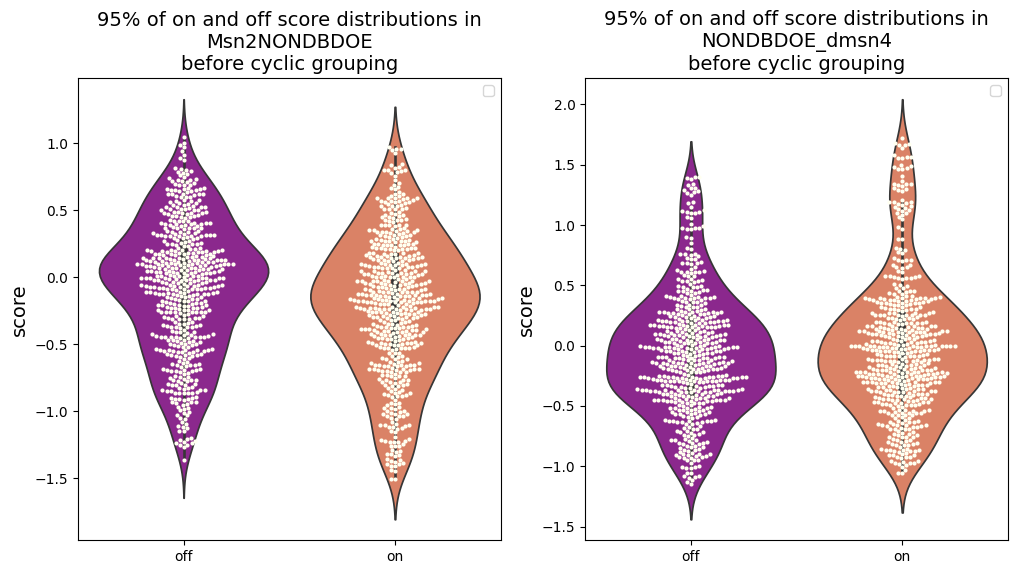

In [357]:
''' show dist before cyclic grouping '''
strains = ['Msn2NONDBDOE', 'NONDBDOE_dmsn4']
fig, axs = plt.subplots(1,2, figsize=(12,6) )
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]

    
    ''' make a sworm plot '''
    curr_df = pd.DataFrame()
    min_percent = 2.5
    max_percent = 97.5
    mn, mx = np.percentile(res_dict[strain].query("on_state=='off'").delta_med180_med0, [min_percent, max_percent])
    curr_off = res_dict[strain].query("on_state=='off' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0        # use when showing 95 percent of results

    mn, mx = np.percentile(res_dict[strain].query("on_state=='on'").delta_med180_med0, [min_percent, max_percent])
    curr_on= res_dict[strain].query("on_state=='on' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0
    
    curr_df = pd.concat( [curr_off, curr_on ] )
    groups = ['off'] * len(curr_off) + ['on'] * len(curr_on)
    
    med_off = curr_off.median()
    med_on = curr_on.median()
    print(strain, med_off-med_on)
    
    sns.violinplot(y=curr_df, x=groups, ax=curr_ax, palette='plasma')
    sns.swarmplot(y=curr_df, x=groups, ax=curr_ax, color='ivory', s=3, zorder=3)

   

    curr_ax.legend()
    curr_ax.set_ylabel('score',fontsize=14)
    curr_ax.set_title('95% of on and off score distributions in\n'+ strain+'\nbefore cyclic grouping', fontsize=14)


## Figure S4F: Msn2, Med15 and Med15 ddMsn2/4 scatters

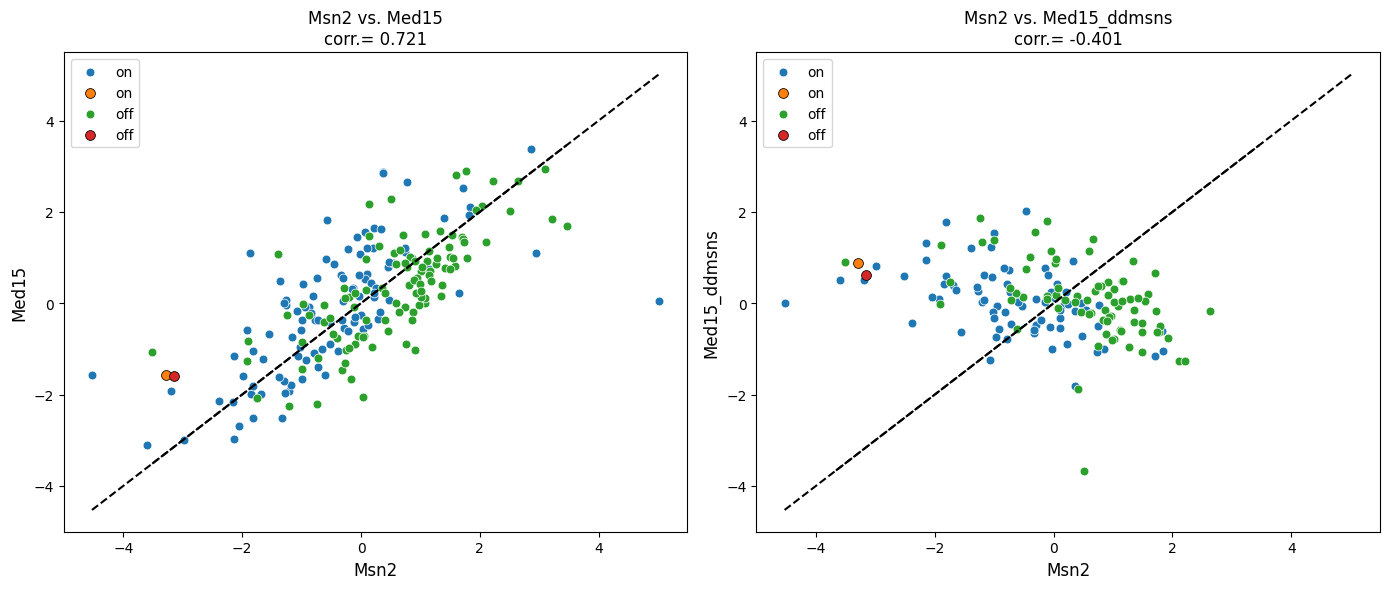

In [358]:
''' plot TF 1 vs. TF 2, hide dots with a signle sequence '''

strains = ['Msn2', 'Msn2DBDOE','Msn2NONDBDOE', 'Med15', 'NONDBDOE_dmsn4', 'Med15_ddmsns']
fig, axs = plt.subplots(1, 2, figsize=(14,6) )

strain_combos = [(0,3),(0,5)]
for comb_i, strain_comb in enumerate(strain_combos):
    strain1 = strain_comb[0]
    strain2 = strain_comb[1]
    curr_ax = np.ravel(axs)[comb_i]
    corr_df = pd.DataFrame()
    for c_on in ['on','off']:
        curr_df = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened']
        samp_on = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened'].delta_median
        samp_off = combined_seq_dict[strains[strain2]+'_'+c_on+'_screened'].delta_median

        
        half_corr_df = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened'].merge(combined_seq_dict[strains[strain2]+'_'+c_on+'_screened'], 
                                                               suffixes=( '_'+strains[strain1],'_'+strains[strain2] ),
                                                               how='inner', left_index=True, right_index=True)
        
        half_corr_df = half_corr_df.loc[:,half_corr_df.columns.str.contains('delta_median')]
        # corr_df = corr_df.append(half_corr_df, ignore_index=True)
        corr_df = pd.concat([corr_df, half_corr_df])

    
        genome_df = pd.DataFrame()
        genome_df.loc['genome','on'] = samp_on.genome
        genome_df.loc['genome','off'] = samp_off.genome

        # plot a scatter Tf 1 vs. TF 2
        curr_corr = np.round( corr_df.corr().iloc[0,1],3)
        sns.scatterplot(x=samp_on, y=samp_off, s=40,  ax=curr_ax, label=c_on, legend=False)
        sns.scatterplot(x=genome_df['on'], y=genome_df['off'], edgecolor='black', s=50, ax=curr_ax, label=c_on, zorder=1, legend=False)

        min_val = min(np.nanmin(samp_on), np.nanmin(samp_off))
        max_val = max(np.nanmax(samp_on), np.nanmax(samp_off))

        # min_val = -4.5
        # max_val = 2

        curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
        curr_ax.set_title(strains[strain1]+' vs. '+strains[strain2]+'\ncorr.= '+str(curr_corr), fontsize=12 )
        curr_ax.set_xlabel(strains[strain1],fontsize=12)
        curr_ax.set_ylabel(strains[strain2],fontsize=12)
        curr_ax.legend()
        plt.tight_layout()


## Figure S4G: Med 15 and Med15 ddMsn2/4 score vs. error

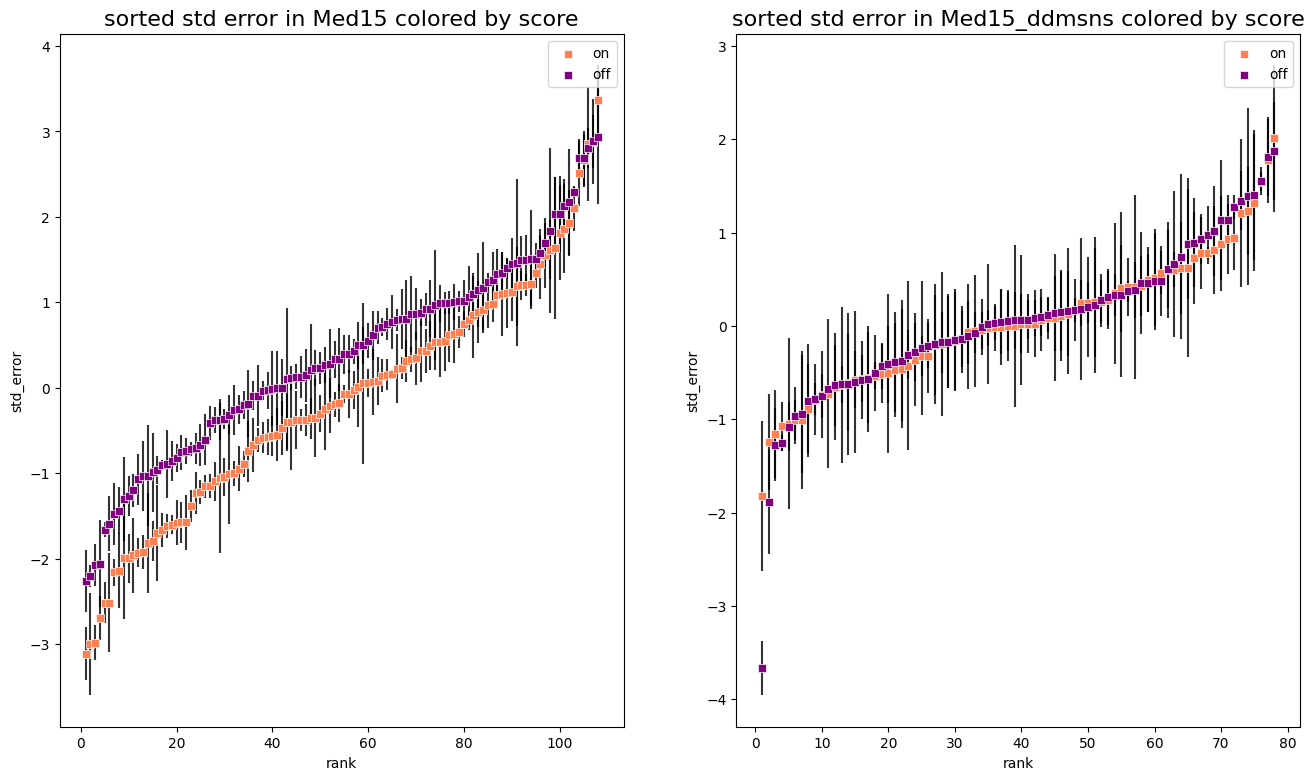

In [360]:
fig, axs = plt.subplots(1,2, figsize=(16,9) )
marker_dict = {'on':'s','off':'s'}
color_dict = {'on':'coral','off':'purple'}
strains = ['Med15','Med15_ddmsns']
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]
    for c_on_i, c_on in enumerate(['on','off']):

        curr_y =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median
        curr_x =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median.rank()
        
        if strain == 'Cbf1':
            print(c_on,curr_y.index[2])
        curr_hue = combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').std_error
        sns.scatterplot(x= curr_x,y= curr_y, color=color_dict[c_on], marker=marker_dict[c_on], label=c_on, ax=curr_ax)
        curr_ax.errorbar(x= curr_x, y=curr_y, yerr=curr_hue, fmt='.', alpha=0.8, color='black', zorder=0)
        
        curr_ax.set_title('sorted std error in '+strain+' colored by score', fontsize=16)
        curr_ax.set_xlabel('rank')
        curr_ax.set_ylabel('std_error')



## Figure S4H correlation of Msn2, Med15 and Med15 ddMsn2/4

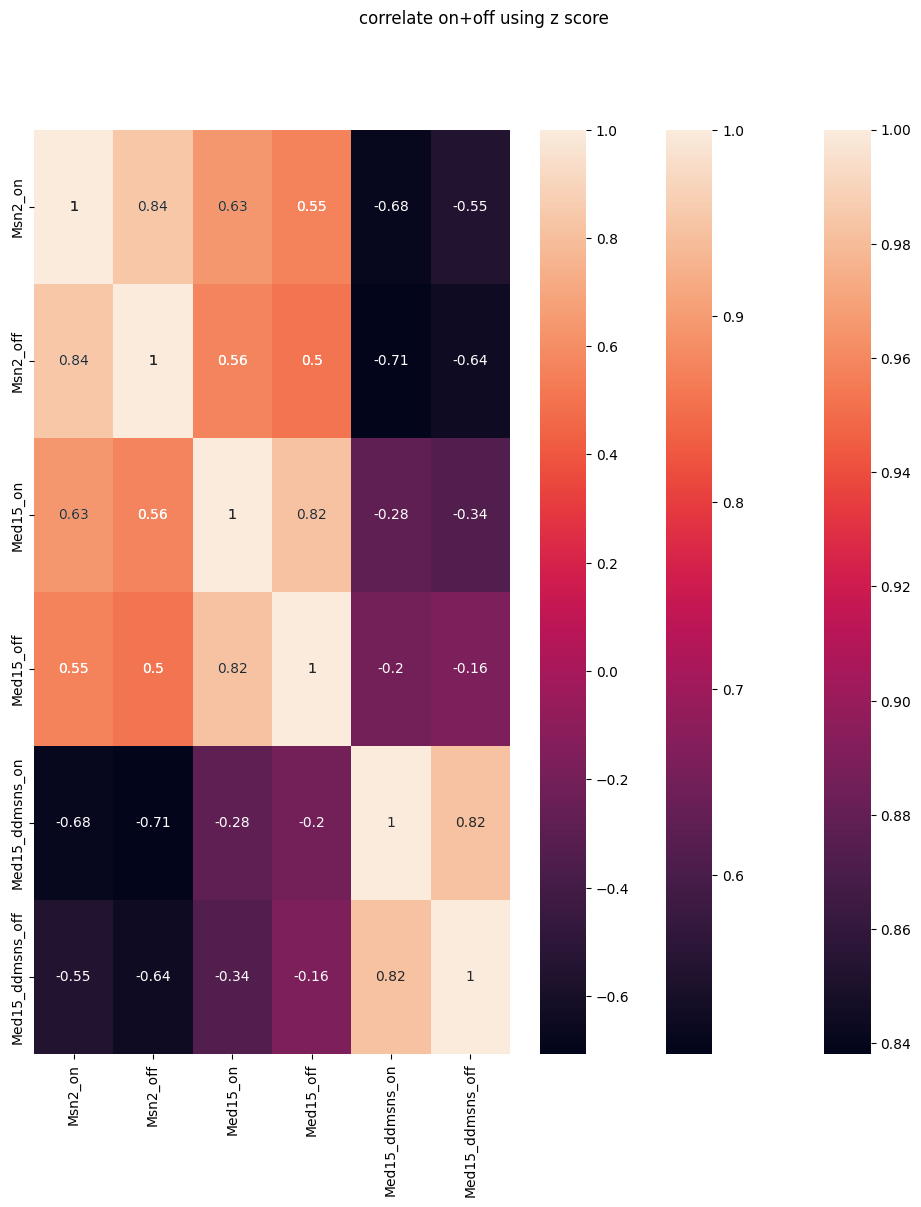

In [361]:
''' correlate strains using z score, on + off in the same plot '''
strains = ['Msn2', 'Med15', 'Med15_ddmsns']
fig, axs = plt.subplots(1,1, figsize=(12,12))
fig.suptitle('correlate on+off using z score')
corr_df = pd.DataFrame()

for strain in strains:
    for c_on in ['on','off']:
        corr_df = corr_df.merge(combined_seq_dict[strain+'_'+c_on].delta_median, how='outer', left_index=True, right_index=True, suffixes=['','_'+strain+'_'+c_on])
        corr_df.columns = corr_df.columns.str.replace('delta_median',strain+'_'+c_on)
        # corr_df.columns = [col + '_' + c_on if not col.endswith(('on', 'off')) else col for col in corr_df.columns]
    # create a corrolation heatmap        
    curr_ax = axs
    sns.heatmap(corr_df.corr(), annot=True, ax=curr_ax)
    


# Figure S5

## Figure S5A: top 15 sequences in Msn2 non tadem STR libraries

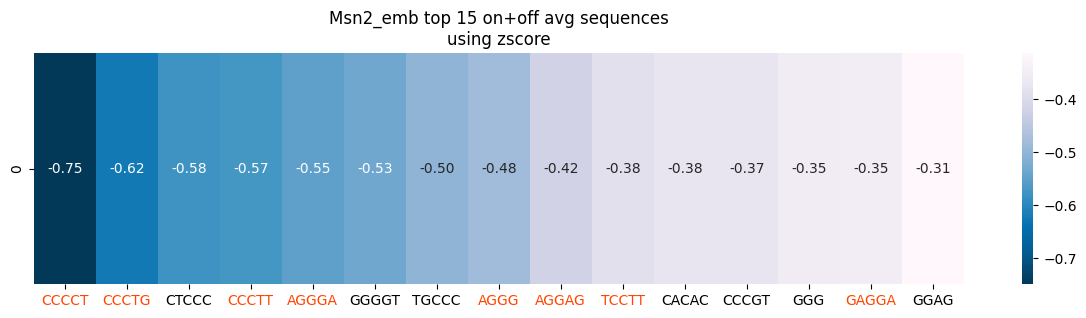

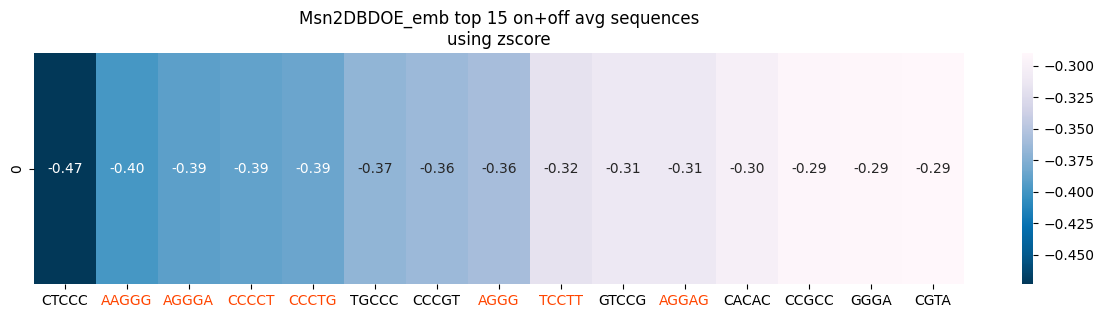

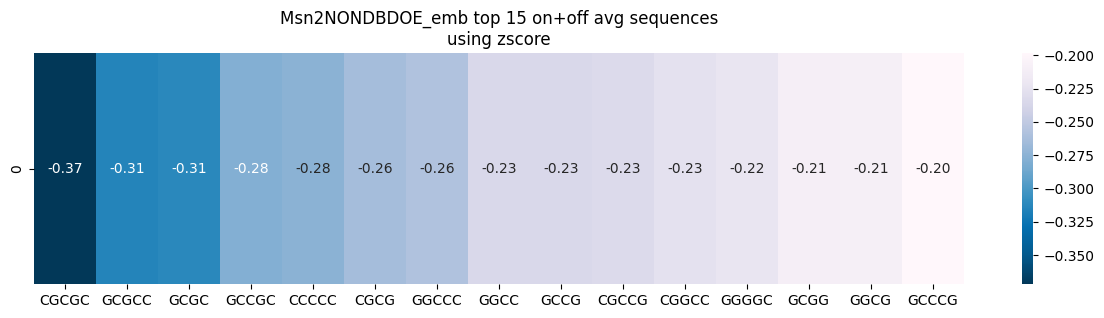

In [364]:
''' top sequences for on+off avg '''

def assign_seq_group(sequence):
    ''' use for non-cyclic STRs. get a sequence as a string and assign it to 1 of 4 sequence groups:\n1. AGG\n2. A/T + 3[G,C] + A/T\n3. %AT >= 75%\n4. general sequences
    function will look for the sequenece pattern and its reverse compliment (not the cyclic pattern) in the input sequence, not in its cyclic options. '''
#     build  a decision tree
#     a sequences can be assigned to more than one group, so it has to be put in the tree in different starting points
    group = []
    agggt_pattern = re.compile(r'[AT](GGG|CCC|GCG|CGC|GGC|CGG|CCG|GCC)[AT]')

    if 'AGG' in sequence or 'CCT' in sequence:
        group.append('AGG')
    if bool(agggt_pattern.search(sequence)):
        group.append('3G')
    if calculate_gc_content(sequence) < 26:
        group.append('AT_rich')
    if len(group)==0:
        group.append('general_sequence')
    return group

Msn2_strains = ['Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE']
for lib in ['_emb','_flank'][:1]:
    for strain_i, strain in enumerate(Msn2_strains):
        curr_df = combined_seq_dict[strain+lib+'_'+'on'].merge(combined_seq_dict[strain+lib+'_'+'off'], how='inner', suffixes=('_on','_off'), left_index=True, right_index=True )
        curr_df = curr_df.loc[:,curr_df.columns.str.contains('delta_median')]
        curr_df['avg_delta_median'] = curr_df.mean(axis=1)
        curr_df = curr_df.sort_values(by='avg_delta_median')
        curr_df['group'] = curr_df.index.map(lambda x: assign_seq_group(x))
        curr_df['group_color'] = curr_df['group'].map(lambda x: 'orangered' if x[0] == 'AGG' else 'dodgerblue' if x[0] == 'AT_rich' else 'darkviolet' if x[0] == '3G' else 'black')

        plt.figure(figsize=(15,3))
        plt.title(strain+lib+' top 15 '+'on+off avg'+' sequences\nusing zscore')
        ax = sns.heatmap(curr_df.avg_delta_median[:15].values.reshape(1, -1), annot=True, fmt=".2f", xticklabels=curr_df.index[:15], cmap='PuBu_r')
        for tick_label, color in zip(ax.get_xticklabels(), curr_df['group_color'][:15]):
            tick_label.set_color(color)



## Figure S5B: context spread and motif effect

/tmp/ipykernel_734330/902492724.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dist_df.index, y=dist_df.loc[:,curr_col], ax=curr_ax, palette='plasma')
/tmp/ipykernel_734330/902492724.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dist_df.index, y=dist_df.loc[:,curr_col], ax=curr_ax, palette='plasma')
/tmp/ipykernel_734330/902492724.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dist_df.index, y=dist_df.loc[:,curr_col], ax=curr_ax, palette='plasma')
/tmp/ipykernel_734330/902492724.py:20: FutureWarning: 

Passing `palet

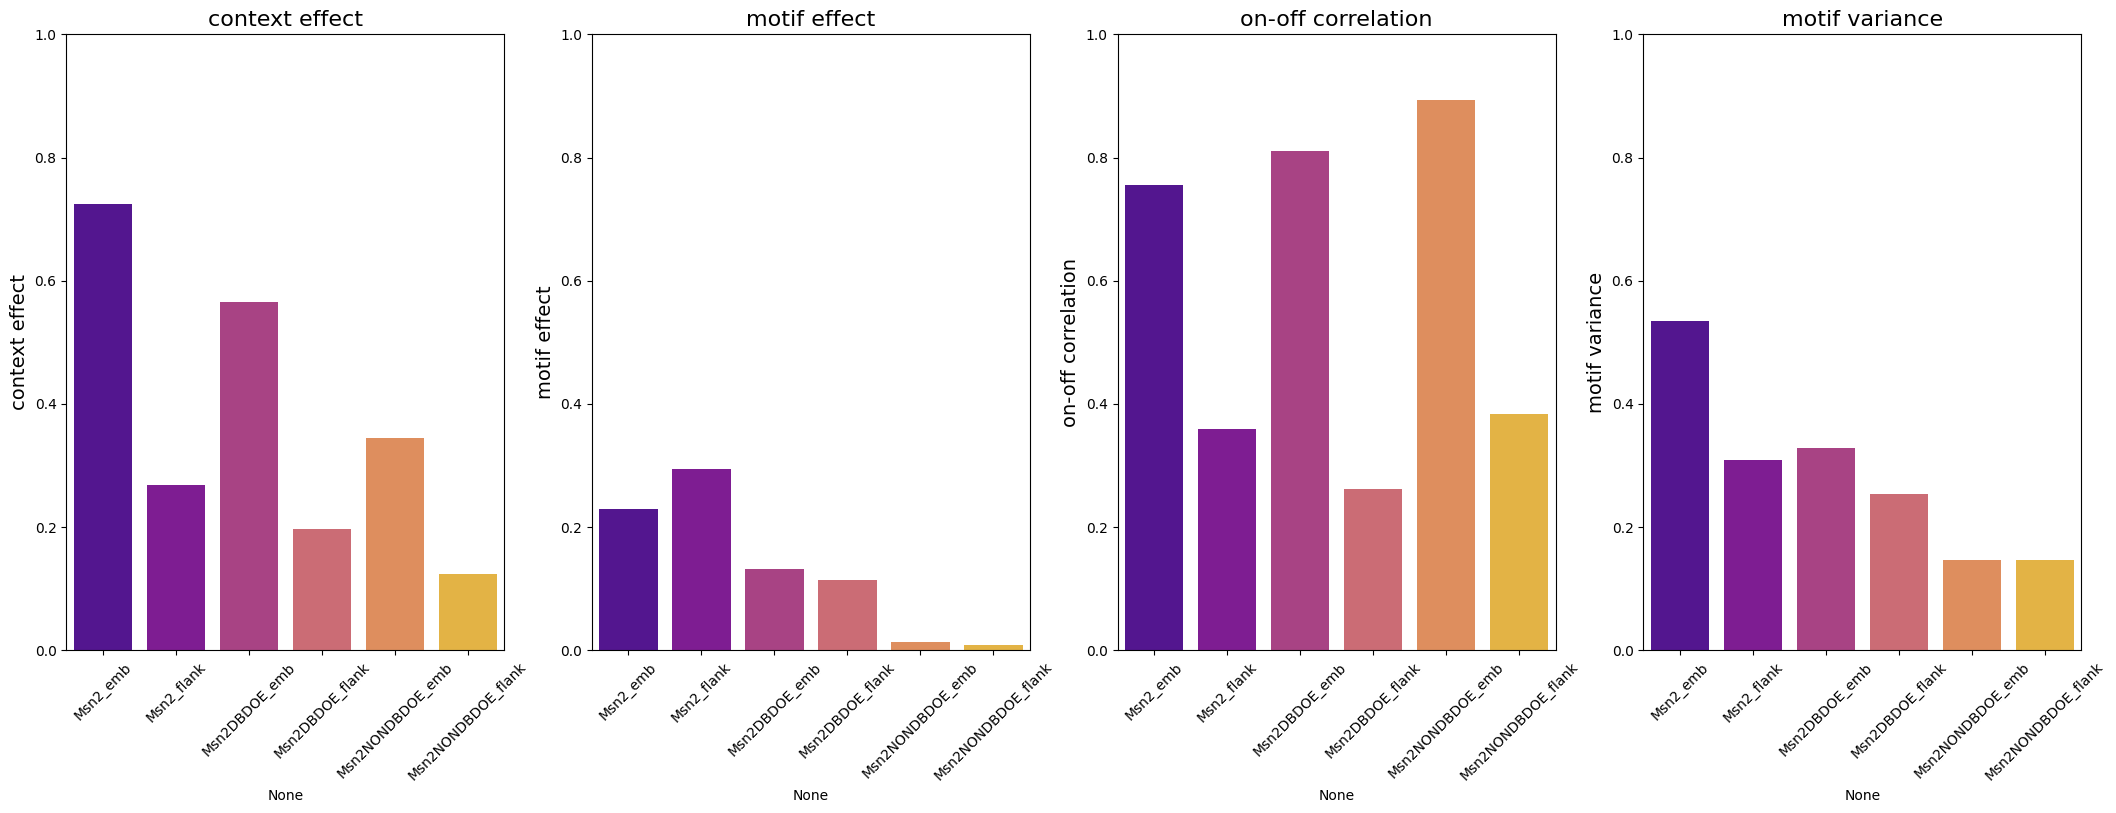

In [374]:
dist_df = pd.DataFrame(columns=['on_spread','off_spread', 'mean_spread','on_d_off_spread','bias'])
for strain in Msn2_strains:
    for lib in ['_emb','_flank']:
        vec_on = combined_seq_dict[strain+lib+'_on'].delta_median
        vec_off = combined_seq_dict[strain+lib+'_off'].delta_median
        if strain == 'Msn2' and lib == '':
            print(np.percentile(vec_on,95) - np.percentile(vec_on,5))
        dist_df.loc[strain+lib,'on_spread'] =  np.percentile(vec_on,95) - np.percentile(vec_on,5)
        dist_df.loc[strain+lib,'off_spread'] =  np.percentile(vec_off,95) - np.percentile(vec_off,5)
        dist_df.loc[strain+lib,'mean_spread'] =  np.mean([dist_df.loc[strain+lib,'on_spread'], dist_df.loc[strain+lib,'off_spread']])
        dist_df.loc[strain+lib,'on_d_off_spread'] =  np.percentile((vec_on - vec_off),95) - np.percentile((vec_on - vec_off),5)
        dist_df.loc[strain+lib,'bias'] =  (vec_off - vec_on).median(axis=0)
        dist_df.loc[strain+lib,'on_off_corr'] =  pd.concat([vec_on,vec_off],axis=1).corr().iloc[0,1]

fig, axs = plt.subplots(1,4,figsize=(26,8))
titles = ['context effect', 'motif effect', 'on-off correlation', 'motif variance']
# for col_i, curr_col in enumerate(dist_df.columns):
for col_i, curr_col in enumerate(['mean_spread', 'bias', 'on_off_corr', 'on_d_off_spread']):
    curr_ax = np.ravel(axs)[col_i]
    sns.barplot(x=dist_df.index, y=dist_df.loc[:,curr_col], ax=curr_ax, palette='plasma')
    curr_ax.set_title(titles[col_i], fontsize=16)
    curr_ax.tick_params(axis='x', rotation=45)
    curr_ax.set_ylabel(titles[col_i], fontsize=14)

    curr_ax.set_ylim(0, 1) 


## Figure S5C: correlate 3 Msn2 strains in tandem and non - tandem libraires

<Axes: >

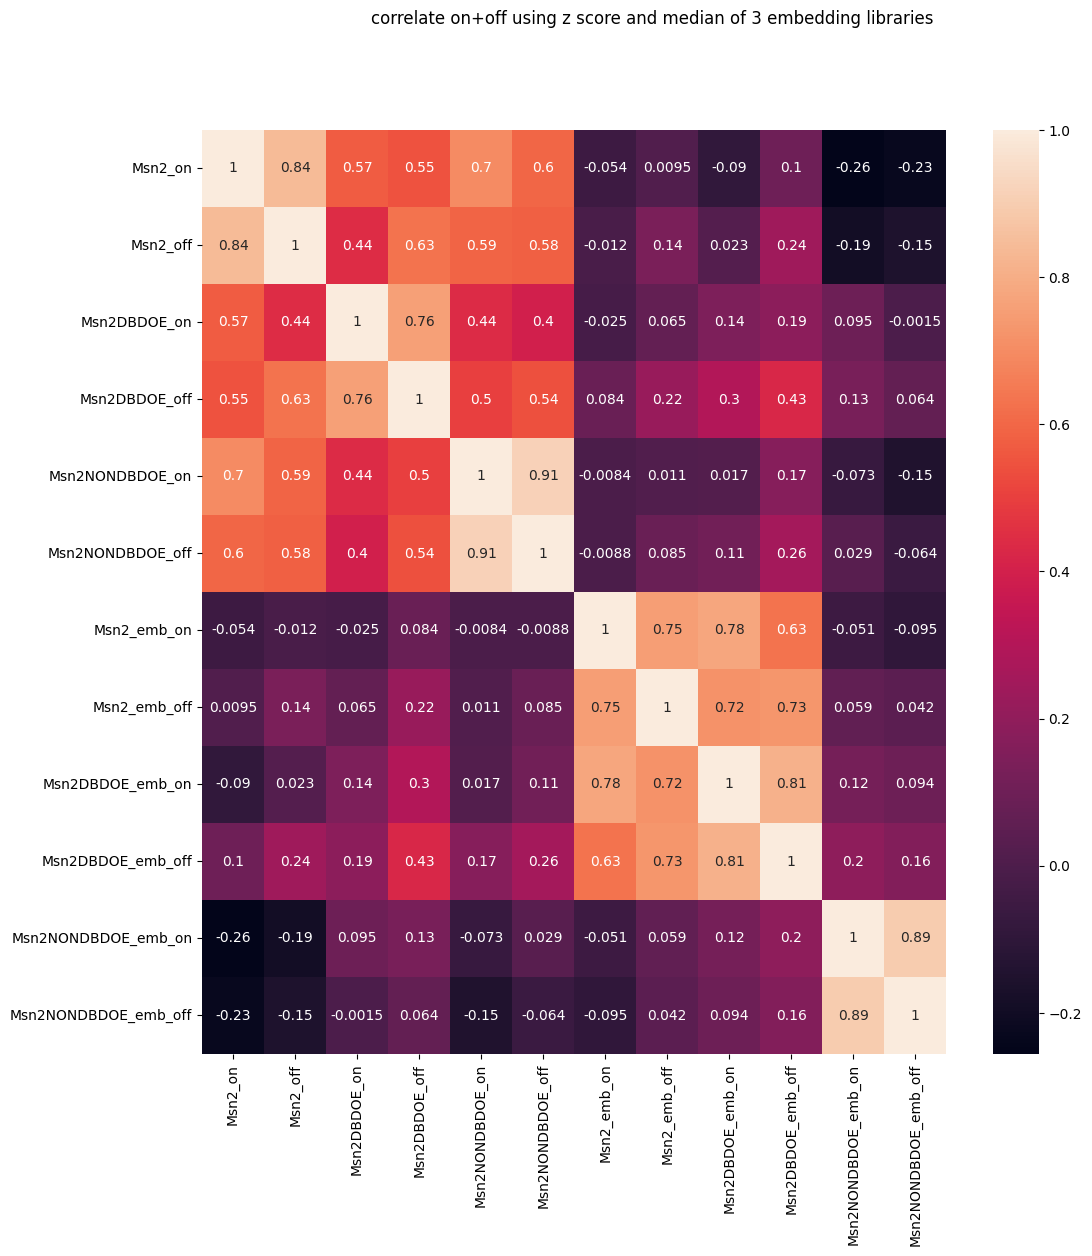

In [373]:
## written on september '24
''' correlate libraires using z score, for all 3 strains, avg over libraries, on + off in the same plot '''
strains = [ 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'Msn2_emb', 'Msn2DBDOE_emb', 'Msn2NONDBDOE_emb']
fig, axs = plt.subplots(1,1, figsize=(12,12))
fig.suptitle('correlate on+off using z score and median of 3 embedding libraries')
corr_df = pd.DataFrame()
mo_strains = [ strain + c_on for strain in strains for c_on in ['_on','_off'] ]

for mo_strain in mo_strains:
    corr_df = corr_df.merge(combined_seq_dict[mo_strain].delta_median, how='outer', left_index=True, right_index=True, suffixes=['','_'+'_'.join(mo_strain.split('_')[1:])])
    corr_df.columns = corr_df.columns.str.replace('delta_median',mo_strain)
    # corr_df.columns = [col + '_' + c_on if not col.endswith(('on', 'off')) else col for col in corr_df.columns]
# create a corrolation heatmap        
curr_ax = axs
# print(corr_df)
sns.heatmap(corr_df.corr(), annot=True, ax=curr_ax)



## Figure S5D: Msn2 strains scatter: tandem vs. non-tandem libraries

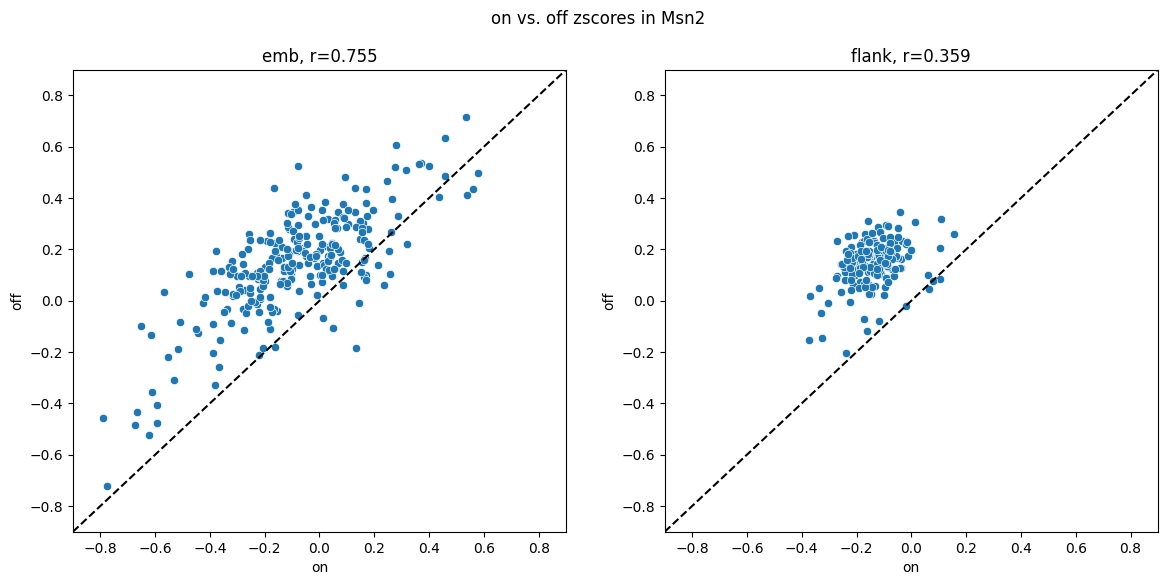

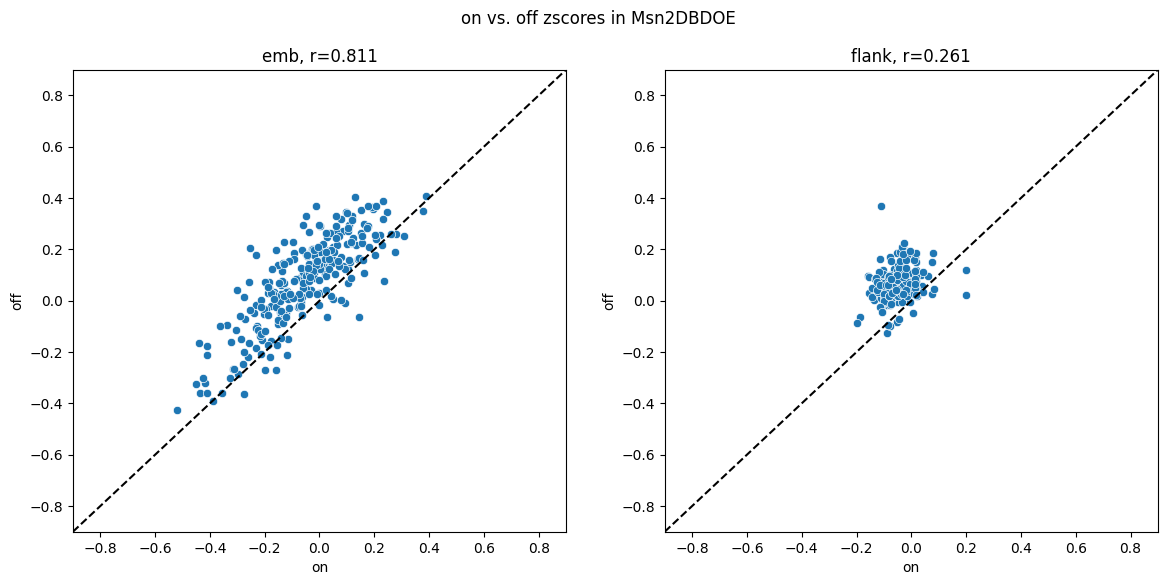

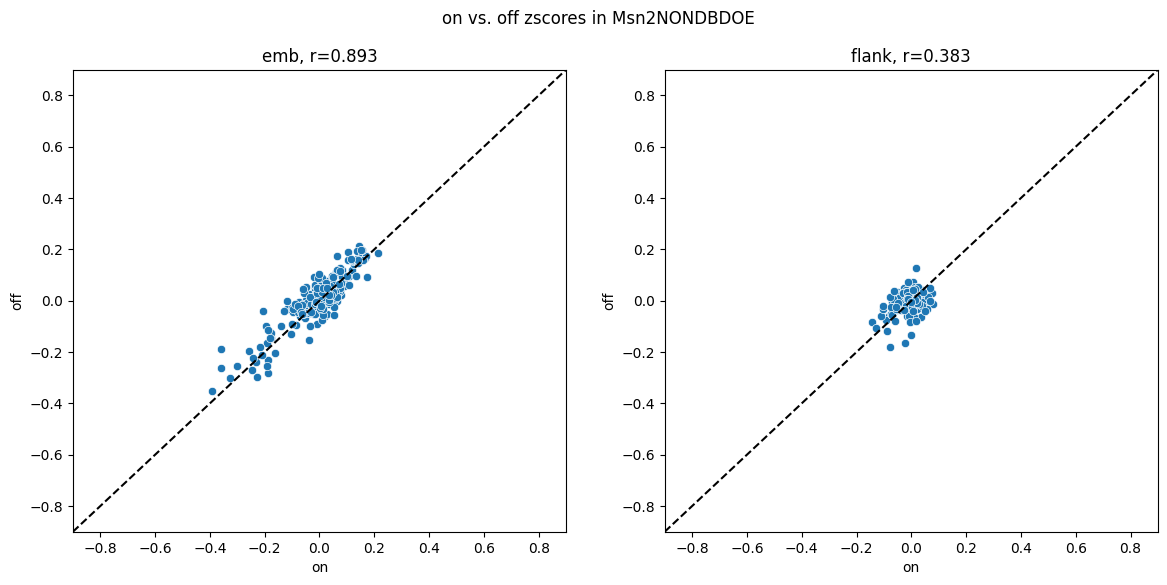

In [376]:
''' scatter on vs. off using z score '''
# global_min = 0
# global_maz = 0
for strain in Msn2_strains:
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('on vs. off zscores in '+strain)
    for fig_i, lib in enumerate(['emb', 'flank']):
        curr_x = combined_seq_dict[strain+'_'+lib+'_on'].delta_median
        curr_y = combined_seq_dict[strain+'_'+lib+'_off'].delta_median
        curr_corr = np.round(pd.concat([curr_x,curr_y],axis=1).corr().iloc[-0,1],3)
        # global_min = min(global_min, np.nanmin(curr_x), np.nanmin(curr_y))
        # global_max = max(global_max, np.nanmax(curr_x), np.nanmax(curr_y))
        
        curr_ax = np.ravel(axs)[fig_i]
        sns.scatterplot(x=curr_x, y=curr_y, ax=curr_ax)
        curr_ax.set_xlabel('on')
        curr_ax.set_ylabel('off')
        curr_ax.set_title(lib+', r='+str(curr_corr))
        
        # min_val = min(np.nanmin(curr_x), np.nanmin(curr_y))
        # max_val = max(np.nanmax(curr_x), np.nanmax(curr_y))
        # curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
        
        curr_ax.set_xlim(-0.9,0.9)
        curr_ax.set_ylim(-0.9,0.9)
        curr_ax.plot([-0.9, 0.9], [-0.9, 0.9], linestyle='--', color='black')
    plt.savefig('/home/labs/barkailab/matanv/CCCA/spaced_STRs/plots/on_vs_off_'+strain+'_zscore_scatter.pdf')

# Figure S6

## Figrue S6A-C: 
    Msn2 vs. freeMnase scatter 
    binding score vs. residuals scatter
    distribution of linear fit errors

/tmp/ipykernel_734330/188960283.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[1]  # Slope
/tmp/ipykernel_734330/188960283.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[0]   # Intercept


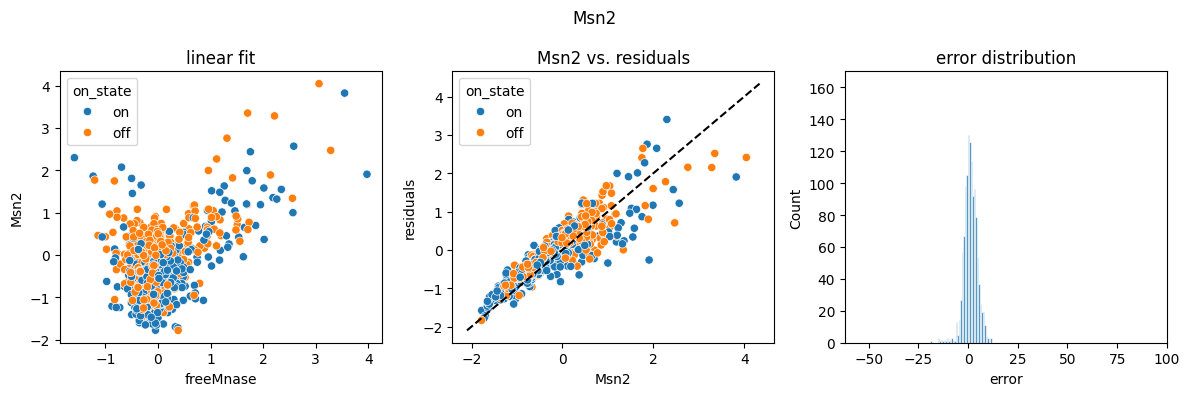

In [402]:
import statsmodels.api as sm
residual_dict = {}


for strain in ['Msn2']:
    curr_x = res_dict['freeMnase'].reset_index(drop=True)
    curr_y = res_dict[strain].reset_index(drop=True)


    merged_df = curr_x.merge(curr_y, suffixes=('_freeMnase', '_'+strain), on=['lib','nuc_comb','on_state'])
    
    rows_to_delete = []
    for row_i, row in merged_df.iterrows():
        c_nuc_comb = row['nuc_comb']
        c_lib = row['lib']
        if merged_df.query(" nuc_comb == @c_nuc_comb & lib == @c_lib ").shape[0] %2 != 0:
            # Append the index of the row to delete
            rows_to_delete.append(row_i)
    # Drop the collected rows from the DataFrame
    merged_df.drop(rows_to_delete, inplace=True)



    curr_y = merged_df['delta_med180_med0_'+strain]
    curr_x = merged_df['delta_med180_med0_'+'freeMnase']
    # sns.scatterplot(curr_x, curr_y)

    # Perform linear regression
    X = sm.add_constant(curr_x)  # Adds a constant term to the predictor
    model = sm.OLS(curr_y, X).fit()
    alpha = model.params[1]  # Slope
    beta = model.params[0]   # Intercept

    # Calculate the error for each value of curr_y
    errors = (-alpha * curr_x + curr_y) / beta
    residuals = curr_y - (alpha * curr_x + beta )
    # Display the errors
    errors_df = pd.DataFrame({'lib':merged_df.lib, 'nuc_comb':merged_df.nuc_comb ,'on_state':merged_df.on_state ,
                              'freeMnase': curr_x, strain: curr_y, 'residuals': residuals, 'errors':errors, 'z_score':merged_df['z_score_'+strain]})
    residual_dict[strain] = errors_df.set_index('nuc_comb', drop=False)
    fig, axs = plt.subplots(1,3,figsize=(12,4))
    fig.suptitle(strain)
    
    sns.scatterplot(y=errors_df[strain], x=errors_df['freeMnase'], hue=errors_df['on_state'], ax=axs[0])
    # reg_line_df = pd.DataFrame({ 'freeMnase': curr_x, 'fit': alpha * curr_x + beta})
    # sns.lineplot(x=reg_line_df['freeMnase'], y=reg_line_df['fit'], color='red', ax=axs[0])
    axs[0].set_title('linear fit')
    axs[0].set_xlabel('freeMnase')
    axs[0].set_ylabel(strain)
    
    sns.scatterplot(x=errors_df[strain], y=errors_df['residuals'], hue=errors_df['on_state'], ax=axs[1])
    min_val = min(axs[1].get_xlim()[0], axs[1].get_ylim()[0])
    max_val = max(axs[1].get_xlim()[1], axs[1].get_ylim()[1])
    axs[1].plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

    axs[1].set_title(strain+' vs. residuals')

    sns.histplot(x=errors_df['errors'], edgecolor='white', ax=axs[2])
    # axs[2].hist(x=errors_df['errors'], edgecolor='white') 
    axs[2].set_title('error distribution')
    axs[2].set_xlabel('error')
    axs[2].set_xlim( -62, 100)
    axs[2].set_ylim( 0, 170)

    
    plt.tight_layout()
    


## Figrue S6D-F: 
    Msn2 DBD vs. freeMnase scatter 
    binding score vs. residuals scatter
    distribution of linear fit errors

/tmp/ipykernel_734330/4066535999.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[1]  # Slope
/tmp/ipykernel_734330/4066535999.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[0]   # Intercept


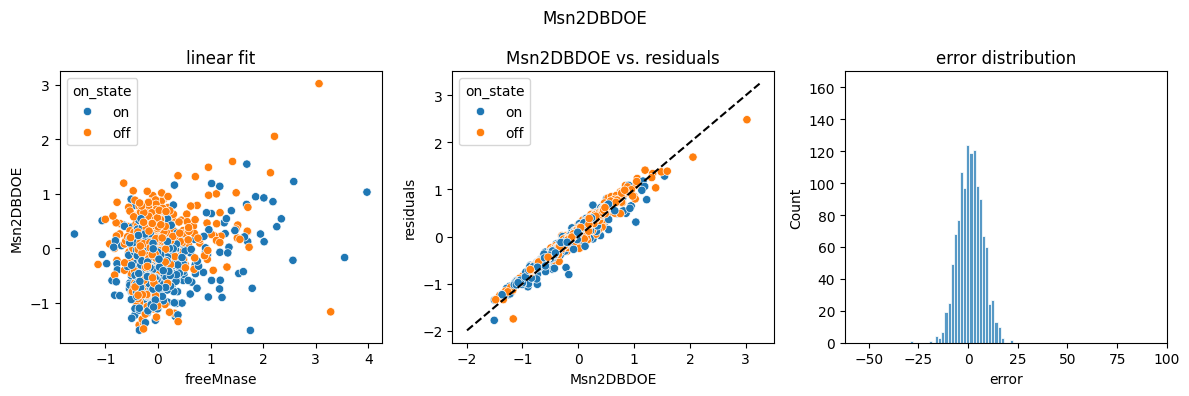

In [403]:
import statsmodels.api as sm
residual_dict = {}


for strain in ['Msn2DBDOE']:
    curr_x = res_dict['freeMnase'].reset_index(drop=True)
    curr_y = res_dict[strain].reset_index(drop=True)


    merged_df = curr_x.merge(curr_y, suffixes=('_freeMnase', '_'+strain), on=['lib','nuc_comb','on_state'])
    
    rows_to_delete = []
    for row_i, row in merged_df.iterrows():
        c_nuc_comb = row['nuc_comb']
        c_lib = row['lib']
        if merged_df.query(" nuc_comb == @c_nuc_comb & lib == @c_lib ").shape[0] %2 != 0:
            # Append the index of the row to delete
            rows_to_delete.append(row_i)
    # Drop the collected rows from the DataFrame
    merged_df.drop(rows_to_delete, inplace=True)



    curr_y = merged_df['delta_med180_med0_'+strain]
    curr_x = merged_df['delta_med180_med0_'+'freeMnase']
    # sns.scatterplot(curr_x, curr_y)

    # Perform linear regression
    X = sm.add_constant(curr_x)  # Adds a constant term to the predictor
    model = sm.OLS(curr_y, X).fit()
    alpha = model.params[1]  # Slope
    beta = model.params[0]   # Intercept

    # Calculate the error for each value of curr_y
    errors = (-alpha * curr_x + curr_y) / beta
    residuals = curr_y - (alpha * curr_x + beta )
    # Display the errors
    errors_df = pd.DataFrame({'lib':merged_df.lib, 'nuc_comb':merged_df.nuc_comb ,'on_state':merged_df.on_state ,
                              'freeMnase': curr_x, strain: curr_y, 'residuals': residuals, 'errors':errors, 'z_score':merged_df['z_score_'+strain]})
    residual_dict[strain] = errors_df.set_index('nuc_comb', drop=False)
    fig, axs = plt.subplots(1,3,figsize=(12,4))
    fig.suptitle(strain)
    
    sns.scatterplot(y=errors_df[strain], x=errors_df['freeMnase'], hue=errors_df['on_state'], ax=axs[0])
    # reg_line_df = pd.DataFrame({ 'freeMnase': curr_x, 'fit': alpha * curr_x + beta})
    # sns.lineplot(x=reg_line_df['freeMnase'], y=reg_line_df['fit'], color='red', ax=axs[0])
    axs[0].set_title('linear fit')
    axs[0].set_xlabel('freeMnase')
    axs[0].set_ylabel(strain)
    
    sns.scatterplot(x=errors_df[strain], y=errors_df['residuals'], hue=errors_df['on_state'], ax=axs[1])
    min_val = min(axs[1].get_xlim()[0], axs[1].get_ylim()[0])
    max_val = max(axs[1].get_xlim()[1], axs[1].get_ylim()[1])
    axs[1].plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

    axs[1].set_title(strain+' vs. residuals')

    sns.histplot(x=errors_df['errors'], edgecolor='white', ax=axs[2])
    # axs[2].hist(x=errors_df['errors'], edgecolor='white') 
    axs[2].set_title('error distribution')
    axs[2].set_xlabel('error')
    axs[2].set_xlim( -62, 100)
    axs[2].set_ylim( 0, 170)

    
    plt.tight_layout()
    

    

## Figrue S6D-F: 
    Msn2 non-DBD vs. freeMnase scatter 
    binding score vs. residuals scatter
    distribution of linear fit errors

/tmp/ipykernel_734330/3939348738.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[1]  # Slope
/tmp/ipykernel_734330/3939348738.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[0]   # Intercept


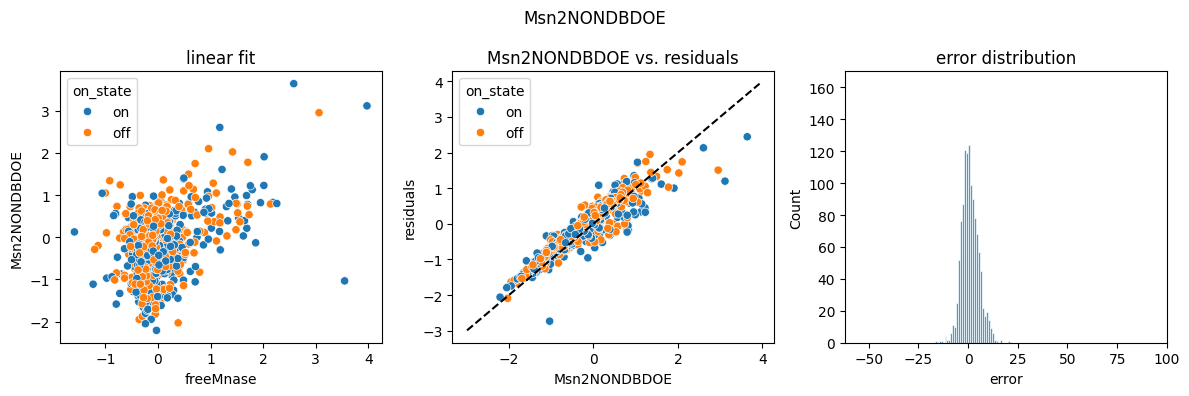

In [413]:
import statsmodels.api as sm
residual_dict = {}


for strain in ['Msn2NONDBDOE']:
    curr_x = res_dict['freeMnase'].reset_index(drop=True)
    curr_y = res_dict[strain].reset_index(drop=True)


    merged_df = curr_x.merge(curr_y, suffixes=('_freeMnase', '_'+strain), on=['lib','nuc_comb','on_state'])
    
    rows_to_delete = []
    for row_i, row in merged_df.iterrows():
        c_nuc_comb = row['nuc_comb']
        c_lib = row['lib']
        if merged_df.query(" nuc_comb == @c_nuc_comb & lib == @c_lib ").shape[0] %2 != 0:
            # Append the index of the row to delete
            rows_to_delete.append(row_i)
    # Drop the collected rows from the DataFrame
    merged_df.drop(rows_to_delete, inplace=True)



    curr_y = merged_df['delta_med180_med0_'+strain]
    curr_x = merged_df['delta_med180_med0_'+'freeMnase']
    # sns.scatterplot(curr_x, curr_y)

    # Perform linear regression
    X = sm.add_constant(curr_x)  # Adds a constant term to the predictor
    model = sm.OLS(curr_y, X).fit()
    alpha = model.params[1]  # Slope
    beta = model.params[0]   # Intercept

    # Calculate the error for each value of curr_y
    errors = (-alpha * curr_x + curr_y) / beta
    residuals = curr_y - (alpha * curr_x + beta )
    # Display the errors
    errors_df = pd.DataFrame({'lib':merged_df.lib, 'nuc_comb':merged_df.nuc_comb ,'on_state':merged_df.on_state ,
                              'freeMnase': curr_x, strain: curr_y, 'residuals': residuals, 'errors':errors, 'z_score':merged_df['z_score_'+strain]})
    residual_dict[strain] = errors_df.set_index('nuc_comb', drop=False)
    fig, axs = plt.subplots(1,3,figsize=(12,4))
    fig.suptitle(strain)
    
    sns.scatterplot(y=errors_df[strain], x=errors_df['freeMnase'], hue=errors_df['on_state'], ax=axs[0])
    # reg_line_df = pd.DataFrame({ 'freeMnase': curr_x, 'fit': alpha * curr_x + beta})
    # sns.lineplot(x=reg_line_df['freeMnase'], y=reg_line_df['fit'], color='red', ax=axs[0])
    axs[0].set_title('linear fit')
    axs[0].set_xlabel('freeMnase')
    axs[0].set_ylabel(strain)
    
    sns.scatterplot(x=errors_df[strain], y=errors_df['residuals'], hue=errors_df['on_state'], ax=axs[1])
    min_val = min(axs[1].get_xlim()[0], axs[1].get_ylim()[0])
    max_val = max(axs[1].get_xlim()[1], axs[1].get_ylim()[1])
    axs[1].plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

    axs[1].set_title(strain+' vs. residuals')

    sns.histplot(x=errors_df['errors'], edgecolor='white', ax=axs[2])
    # axs[2].hist(x=errors_df['errors'], edgecolor='white') 
    axs[2].set_title('error distribution')
    axs[2].set_xlabel('error')
    axs[2].set_xlim( -62, 100)
    axs[2].set_ylim( 0, 170)

    
    plt.tight_layout()
    

    

## Figrue S6G-I: PFMs

In [ ]:

def pfm_score(pfm, sequence): # calculate a PFM scre for a given sequence

    def parse_pfm(pfm_string):
        # Initialize an empty dictionary to store the PFM
        pfm = {}

        # Split the input string into lines
        lines = pfm_string.strip().split('\n')

        # Iterate over each line in the PFM string
        for line in lines:
            # Split each line into elements
            elements = line.split()
            # The first element is the nucleotide
            nucleotide = elements[0]
            # The rest of the elements are the probabilities
            probabilities = list(map(float, elements[1:]))
            # Add the nucleotide and its probabilities to the dictionary
            pfm[nucleotide] = probabilities

        return pfm
    
    pfm = parse_pfm(pfm)
    seq = sequence
    # Convert PFM to numpy array for easier computation
    pfm_array = np.array([pfm['A'], pfm['T'], pfm['G'], pfm['C']])

    # Map nucleotides to indices
    nucleotide_to_index = {'A': 0, 'T': 1, 'G': 2, 'C': 3}

    # Lengths
    pfm_length = pfm_array.shape[1]
    dna_length = len(seq)
    # Initialize sum of products
    sum_of_products = 0.0
    sum_of_log_products = 0.0

    # Iterate over all possible alignments
    for start in range(dna_length - pfm_length + 1):
        product = 1.0
        log_product = 0.0
        for i in range(pfm_length):
            nucleotide = seq[start + i]
            nucleotide_index = nucleotide_to_index[nucleotide]
            product *= pfm_array[nucleotide_index, i]
        
        # log_product = np.log(product)
        sum_of_products += product
        sum_of_log_products += log_product
    return(sum_of_products)



def pfm_score_list(pfm, sequence): # make a list of all PFM calculations for a sequence
    list_sum_of_products = []
    def parse_pfm(pfm_string):
        # Initialize an empty dictionary to store the PFM
        pfm = {}

        # Split the input string into lines
        lines = pfm_string.strip().split('\n')

        # Iterate over each line in the PFM string
        for line in lines:
            # Split each line into elements
            elements = line.split()
            # The first element is the nucleotide
            nucleotide = elements[0]
            # The rest of the elements are the probabilities
            probabilities = list(map(float, elements[1:]))
            # Add the nucleotide and its probabilities to the dictionary
            pfm[nucleotide] = probabilities

        return pfm
    
    pfm = parse_pfm(pfm)
    seq = sequence
    # Convert PFM to numpy array for easier computation
    pfm_array = np.array([pfm['A'], pfm['T'], pfm['G'], pfm['C']])

    # Map nucleotides to indices
    nucleotide_to_index = {'A': 0, 'T': 1, 'G': 2, 'C': 3}

    # Lengths
    pfm_length = pfm_array.shape[1]
    dna_length = len(seq)
    # Initialize sum of products
    sum_of_products = 0.0
    sum_of_log_products = 0.0

    # Iterate over all possible alignments
    for start in range(dna_length - pfm_length + 1):
        product = 1.0
        log_product = 0.0
        for i in range(pfm_length):
            nucleotide = seq[start + i]
            nucleotide_index = nucleotide_to_index[nucleotide]
            product *= pfm_array[nucleotide_index, i]
        
        # log_product = np.log(product)
        list_sum_of_products.append( product )
        
    return(list_sum_of_products)




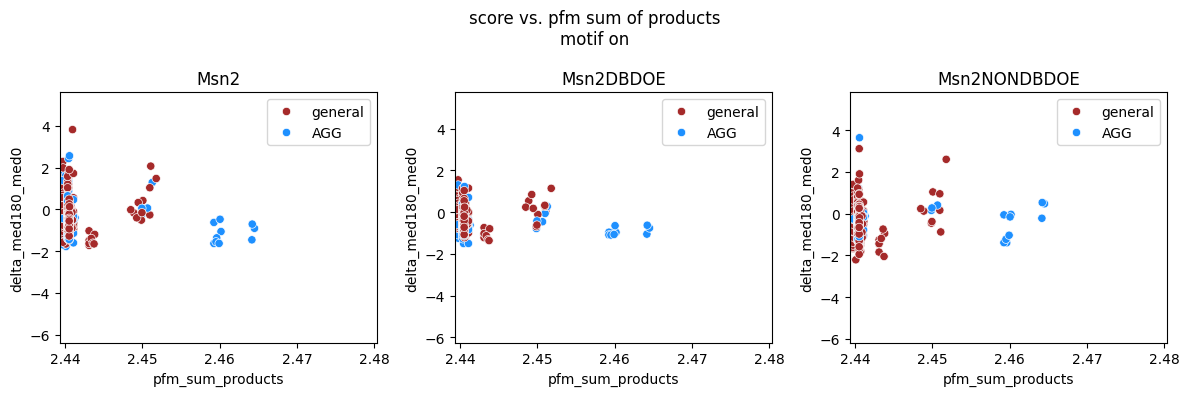

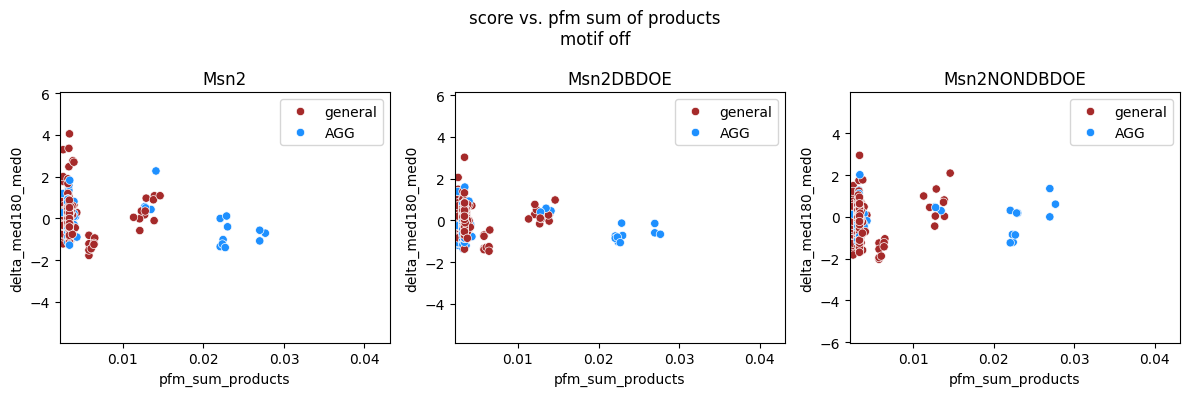

In [412]:
sheet_names = ['Msn2', 'Msn2 DBD OE', 'Msn2 non-DBD OE', 'Mot3', 'Cbf1', 'Reb1', 'freeMnase']
for c_on in ['on', 'off']:
    fig, axs = plt.subplots( 1, 3, figsize=(12,4) )
    fig.suptitle("score vs. pfm sum of products\nmotif "+c_on)

    for strain_i, strain in enumerate( [ 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE' ] ):
        curr_df = res_dict[strain].loc[:,['lib_i','on_state','delta_med180_med0']]
        parent_directory = os.path.dirname(original_path)
        excel_path = os.path.join(parent_directory, 'out_data/supp. table 1 - sequence libraries and results.xlsx')
        insert_sequence_df = pd.read_excel(excel_path, sheet_name=sheet_names[strain_i])
        insert_sequence_df.rename(columns={'Motif state': 'Motif_state', 'Insert Sequence':'Insert_Sequence'}, inplace=True)
        insert_sequence_df['Motif_state'] = insert_sequence_df['Motif_state'].map({'intact': 'on', 'mutated': 'off'})

        Msn2_pfm = '''A 0.603012048 0.00060241 0.00060241 0.00060241 0.00060241
        T 0.00060241 0.00060241 0.00060241 0.00060241 0.00060241
        G 0.323493976 0.998192771 0.998192771 0.998192771 0.998192771
        C 0.072891566 0.00060241 0.00060241 0.00060241 0.00060241'''

        # Function to calculate pfm_sum_products for each row
        def calculate_pfm_sum_products(row):
            curr_str = row.name
            curr_lib_i = row['lib_i']
            curr_motif_state = row['on_state']
            curr_sequence = insert_sequence_df.query( "STR == @curr_str & Motif_state == @curr_motif_state & lib_i == @curr_lib_i" ).Insert_Sequence.values[0]
            # print(pfm_score(Msn2_pfm, curr_sequence))
            return pfm_score(Msn2_pfm, curr_sequence)

        # Apply the function to all rows and create the new column
        curr_df['pfm_sum_products'] = curr_df.apply(calculate_pfm_sum_products, axis=1)

        ''' plot the score vs. sum of product '''
        curr_y = curr_df.query( "on_state==@c_on" ).delta_med180_med0
        curr_x = curr_df.query( "on_state==@c_on" ).pfm_sum_products
        seq_groups = ['AGG' if 'AGG' in x else 'general' for x in curr_y.index.map(lambda x: assign_seq_group(x)) ]
        curr_ax = np.ravel(axs)[strain_i]
        sns.scatterplot(x=curr_x, y=curr_y, hue=seq_groups, palette={'AGG':'dodgerblue','general':'brown'}, ax=curr_ax)
    
        curr_ax.set_xlim( curr_x.median()-0.001, curr_x.median()+0.04)
        curr_ax.set_ylim( curr_y.median()-6, curr_y.median()+6)
        curr_ax.set_title(strain)
    plt.tight_layout()
    

# Figure S7

## Figure S7A-B: PSAM model for Msn2 binding motif

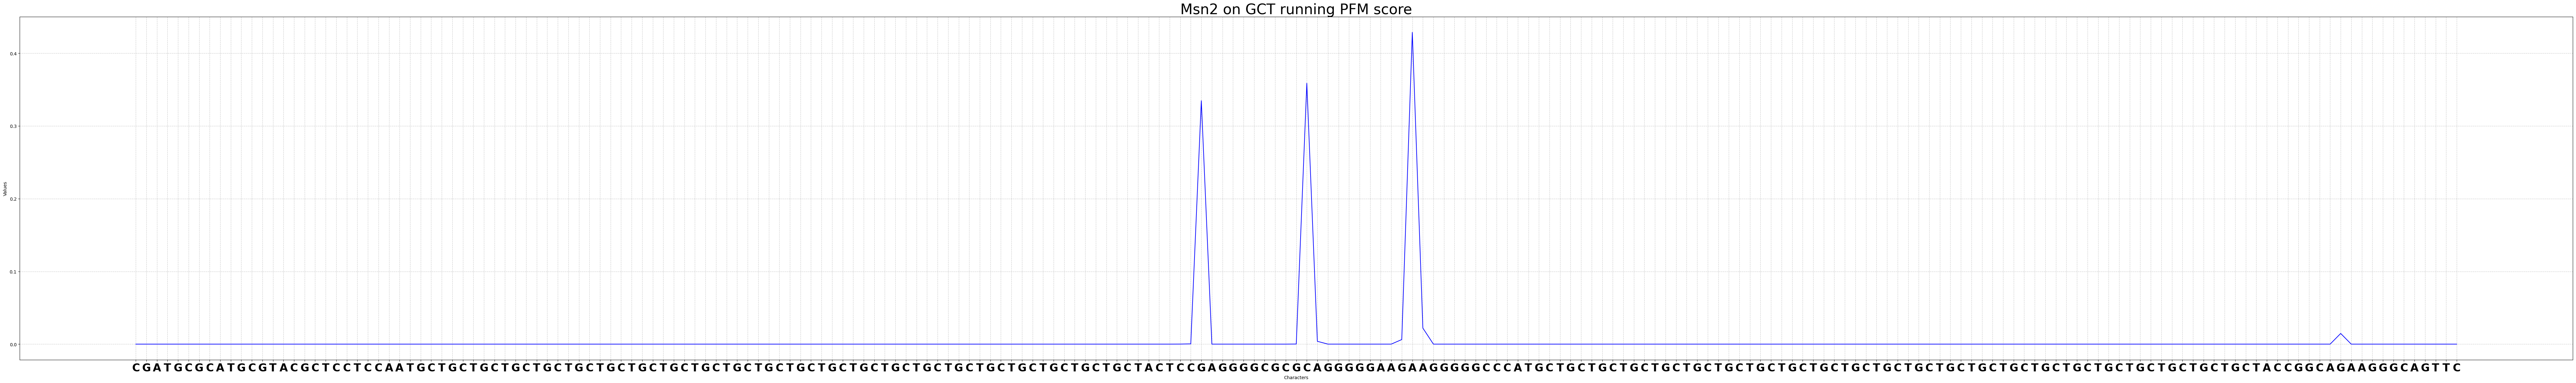

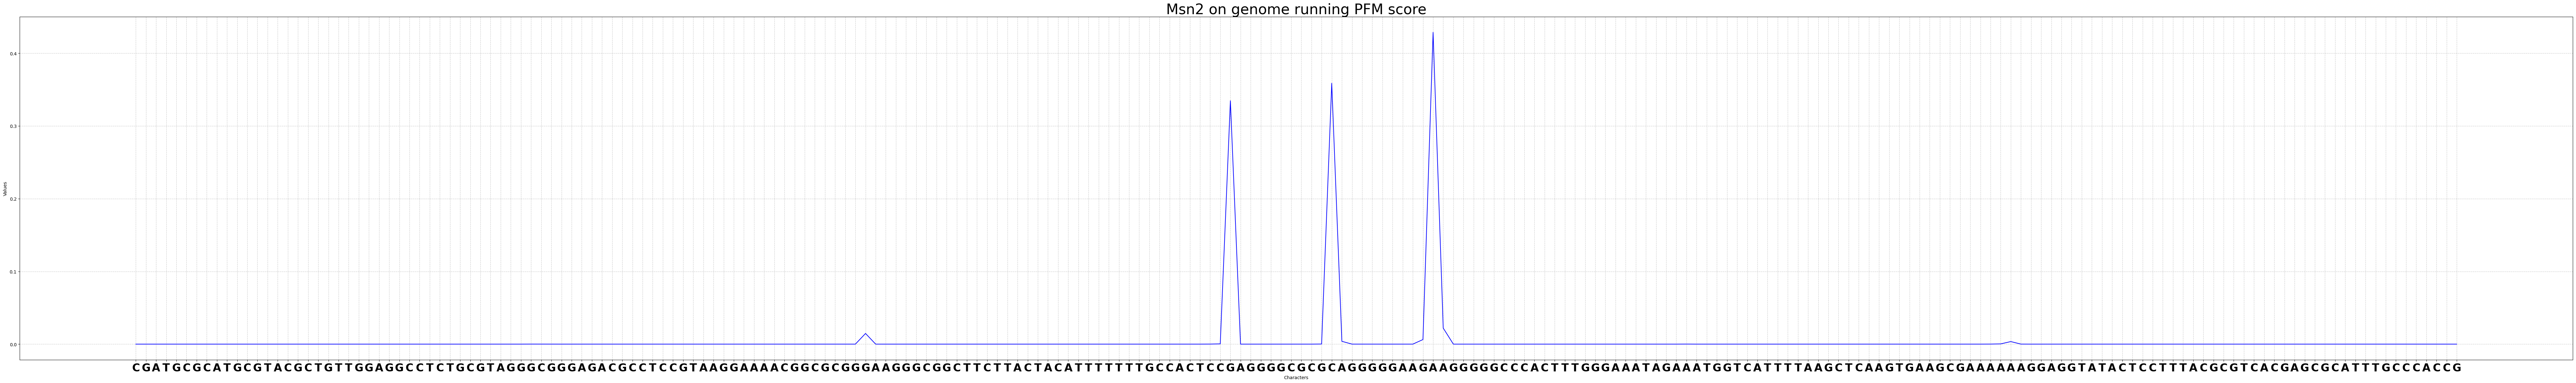

In [460]:
''' Msn2 motif importance in different STR - prediction '''

sheet_names = ['Msn2', 'Msn2 DBD OE', 'Msn2 non-DBD OE', 'Mot3', 'Cbf1', 'Reb1', 'freeMnase']
promoter_region_5motif = {'on': 'AGGGGCGCGCAGGGGGAAGAAGGGG', 'off':'AGAGGCGCGCAGAGGGAAGAAGAGG' }
promoter_region_7motif = {'on': 'GAGGGGCGCGCAGGGGGAAGAAGGGGG', 'off':'GAGAGGCGCGCAGAGGGAAGAAGAGGG' }
Msn2_pfm = '''A 0.603012048 0.00060241 0.00060241 0.00060241 0.00060241
T 0.00060241 0.00060241 0.00060241 0.00060241 0.00060241
G 0.323493976 0.998192771 0.998192771 0.998192771 0.998192771
C 0.072891566 0.00060241 0.00060241 0.00060241 0.00060241'''
        
# Function to calculate pfm_sum_products for each row
def calculate_pfm_sum_products(row):
    curr_str = row.name
    curr_lib_i = row['lib_i']
    curr_motif_state = row['on_state']
    curr_sequence = insert_sequence_df.query( "STR == @curr_str & Motif_state == @curr_motif_state & lib_i == @curr_lib_i" ).Insert_Sequence.values[0]
    # print(pfm_score(Msn2_pfm, curr_sequence))
    return pfm_score(msn2_formatted_psam, curr_sequence)

def calculate_pfm_sum_products_sequence(sequence):
    curr_sequence = sequence
    return pfm_score(msn2_formatted_psam, curr_sequence)
        
''' plot PFM score running along a selected sequence '''

sheet_names = ['Msn2', 'Msn2 DBD OE', 'Msn2 non-DBD OE', 'Mot3', 'Cbf1', 'Reb1', 'freeMnase']
def calculate_pfm_sum_products(row):
    curr_str = row.name
    curr_lib_i = row['lib_i']
    curr_motif_state = row['on_state']
    curr_sequence = insert_sequence_df.query( "STR == @curr_str & Motif_state == @curr_motif_state & lib_i == @curr_lib_i" ).Insert_Sequence.values[0]

    return curr_sequence

        
for c_on in ['on']:
    for c_str in ['TGC','genome']:
        for strain_i, strain in enumerate( [ 'Msn2' ] ):

            curr_df = res_dict[strain].loc[:,['lib_i','on_state','delta_med180_med0']]
            curr_df = curr_df.query("on_state==@c_on")
            parent_directory = os.path.dirname(original_path)
            excel_path = os.path.join(parent_directory, 'out_data/supp. table 1 - sequence libraries and results.xlsx')
            insert_sequence_df = pd.read_excel(excel_path, sheet_name=sheet_names[strain_i])
            insert_sequence_df.rename(columns={'Motif state': 'Motif_state', 'Insert Sequence':'Insert_Sequence'}, inplace=True)
            insert_sequence_df['Motif_state'] = insert_sequence_df['Motif_state'].map({'intact': 'on', 'mutated': 'off'})

            # Apply the function to all rows and create the new column
            curr_df['pfm_sum_products'] = curr_df.apply(calculate_pfm_sum_products, axis=1)
            # choose the c_str equivalent that appears in your data
            c_str = [nuc for nuc in get_seq_set(c_str) if nuc in curr_df.index][0]
            # see if your c_str appears more than ones
            if len(curr_df.loc[ c_str, : ].shape)>1:
                curr_seq = calculate_pfm_sum_products(curr_df.loc[ c_str, : ].iloc[0,:])
            else:
                curr_seq = calculate_pfm_sum_products(curr_df.loc[ c_str, : ])
            score_list = pfm_score_list(msn2_formatted_psam, curr_seq)


        string = curr_seq
        values = score_list+[0,0,0,0,0,0]

        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(80, 12))

        # Plot the values with markers
        indices = range(len(values))
        ax.plot(indices, values, marker='', linestyle='-', color='b')

        # Set x-ticks to match string indices and label with the characters
        ax.set_xticks(indices)
        ax.set_xticklabels(list(string), fontsize=24, fontweight='bold')
        ax.set_xlabel('Characters')
        ax.set_ylabel('Values')
        ax.set_title('Msn2 on '+c_str+' running PFM score', fontsize=32)

        # Customize plot appearance for clarity
        ax.grid(True, linestyle='--', alpha=0.7)

        # Display the plot
        plt.tight_layout()
        plt.show()
        

## Figure S7C: Msn2 consensus motif

/tmp/ipykernel_734330/3734669944.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(data_file, delim_whitespace=True, header=None, index_col=0)
/tmp/ipykernel_734330/3734669944.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0 if x < 0.48 else x)
/home/labs/barkailab/matanv/.local/lib/python3.11/site-packages/logomaker/src/matrix.py:414: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.15075301 -0.24954819 -0.24954819 -0.24954819 -0.24954819]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  out_df.loc[:, :] = df.values - means[:, np.newaxis]
/home/labs/barkailab/matanv/.local/lib/python3.11/site-packages/logomaker/src/matrix.py:414: FutureWarning: Setting an item of incompatible dtype is de

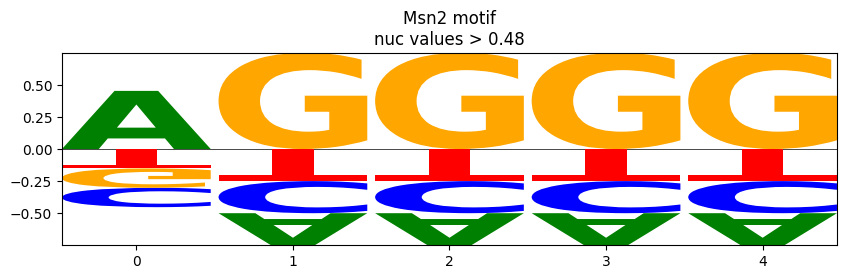

In [470]:
from io import StringIO
msn2_data = '''A 0.603012048 0.00060241 0.00060241 0.00060241 0.00060241
T 0.00060241 0.00060241 0.00060241 0.00060241 0.00060241
G 0.323493976 0.998192771 0.998192771 0.998192771 0.998192771
C 0.072891566 0.00060241 0.00060241 0.00060241 0.00060241'''
msn2_formatted_psam = '''A 1.00000000000000000000 1.00000000000000000000 0.04379770000000000191 0.00817254000000000071 0.00817254000000000071 0.01679299999999999890 0.17519100000000001338
C 0.83682599999999995877 0.02205119999999999997 0.00000001699870000000 0.00000001332770000000 0.00000001332770000000 0.00000001629490000000 1.00000000000000000000
G 0.33471400000000001151 0.02205119999999999997 1.00000000000000000000 1.00000000000000000000 1.00000000000000000000 1.00000000000000000000 0.42868800000000001349
T 0.23084599999999999564 0.00000001770830000000 0.00875911000000000051 0.00000000817010000000 0.00000000817010000000 0.00839647999999999957 0.28029199999999998560'''

curr_data = msn2_data
curr_tf = 'Msn2'

data_file = StringIO(curr_data)
df = pd.read_csv(data_file, delim_whitespace=True, header=None, index_col=0)

# Transpose the DataFrame to have the desired format
df = df.T
df = df.applymap(lambda x: 0 if x < 0.48 else x)


logomaker.Logo(df.reset_index(drop=True), center_values=True, font_name = 'Arial Rounded MT Bold')
plt.title(curr_tf+' motif\nnuc values > 0.48')
plt.savefig('/home/labs/barkailab/matanv/CCCA/context_paper/revised paper/Msn2_PFM_seq_logo.pdf')

## Figure S7D-F: PSAM score as part of the sequences score, histogram

prormoter region PSAM score: prom_score
sequence PSAM score: sequence_score
percantage of sequences where ** prom_score / sequence_score > 0.975 ** : 


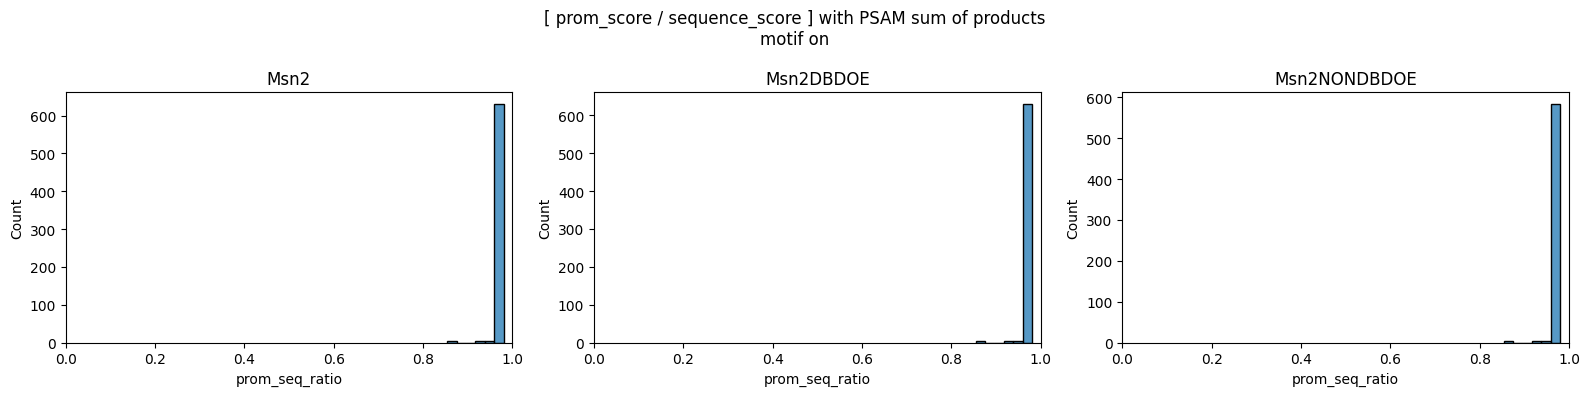

In [459]:
''' use a PSAM, not a PFM, to predict motif importance '''
# PSAM
Msn2_psam = [
  [1,0.836826,0.334714,0.230846],
  [1,0.0220512,0.0220512,1.77083e-08],
  [0.0437977,1.69987e-08,1,0.00875911],  
  [0.00817254,1.33277e-08,1,8.1701e-09],  
  [0.00817254,1.33277e-08,1,8.1701e-09], 
  [0.016793,1.62949e-08,1,0.00839648],  
  [0.175191,1,0.428688,0.280292] ]  


formatted_psam = [[f"{value:.20f}" for value in row] for row in Msn2_psam]
msn2_formatted_psam = '''A 1.00000000000000000000 1.00000000000000000000 0.04379770000000000191 0.00817254000000000071 0.00817254000000000071 0.01679299999999999890 0.17519100000000001338
C 0.83682599999999995877 0.02205119999999999997 0.00000001699870000000 0.00000001332770000000 0.00000001332770000000 0.00000001629490000000 1.00000000000000000000
G 0.33471400000000001151 0.02205119999999999997 1.00000000000000000000 1.00000000000000000000 1.00000000000000000000 1.00000000000000000000 0.42868800000000001349
T 0.23084599999999999564 0.00000001770830000000 0.00875911000000000051 0.00000000817010000000 0.00000000817010000000 0.00839647999999999957 0.28029199999999998560'''

def calculate_pfm_sum_products(row):
    curr_str = row.name
    curr_lib_i = row['lib_i']
    curr_motif_state = row['on_state']
    curr_sequence = insert_sequence_df.query( "STR == @curr_str & Motif_state == @curr_motif_state & lib_i == @curr_lib_i" ).Insert_Sequence.values[0]
    # print(pfm_score(Msn2_pfm, curr_sequence))
    return pfm_score(msn2_formatted_psam, curr_sequence)

def calculate_pfm_sum_products_sequence(sequence):
    curr_sequence = sequence
    return pfm_score(msn2_formatted_psam, curr_sequence)
        
print('prormoter region PSAM score: prom_score\nsequence PSAM score: sequence_score\npercantage of sequences where ** prom_score / sequence_score > 0.975 ** : ')
for c_on in ['on']:
    fig, axs = plt.subplots( 1, 3, figsize=(16,4) )
    fig.suptitle("[ prom_score / sequence_score ] with PSAM sum of products\nmotif "+c_on)

    for strain_i, strain in enumerate( [ 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE' ] ):
        curr_df = res_dict[strain].loc[:,['lib_i','on_state','delta_med180_med0']]
        curr_df = curr_df.query("on_state==@c_on")
        parent_directory = os.path.dirname(original_path)
        excel_path = os.path.join(parent_directory, 'out_data/supp. table 1 - sequence libraries and results.xlsx')
        insert_sequence_df = pd.read_excel(excel_path, sheet_name=sheet_names[strain_i])
        insert_sequence_df.rename(columns={'Motif state': 'Motif_state', 'Insert Sequence':'Insert_Sequence'}, inplace=True)
        insert_sequence_df['Motif_state'] = insert_sequence_df['Motif_state'].map({'intact': 'on', 'mutated': 'off'})

        # Apply the function to all rows and create the new column
        curr_df['pfm_sum_products'] = curr_df.apply(calculate_pfm_sum_products, axis=1)
        prom_pfm_score = calculate_pfm_sum_products_sequence(promoter_region_7motif[c_on])
        curr_df['prom_seq_ratio'] =  prom_pfm_score / curr_df['pfm_sum_products'] 

        ''' plot the ratio of sum of product for the promoter region and the whole sequence '''
        
        curr_x = curr_df.prom_seq_ratio
        # print(strain+', '+c_on+': '+ str(ratio_percent))
    
        curr_ax = np.ravel(axs)[strain_i]
        sns.histplot(curr_x, label=c_on, binwidth=0.02, ax=curr_ax)
        curr_ax.set_xlim(0,1)
        curr_ax.set_title(strain)
    plt.tight_layout()
    plt.savefig('/home/labs/barkailab/matanv/CCCA/context_paper/revised paper/psam_score_histogram_new.pdf')

## Figure S7G: fold change distribution of Msn2 and free Mnase

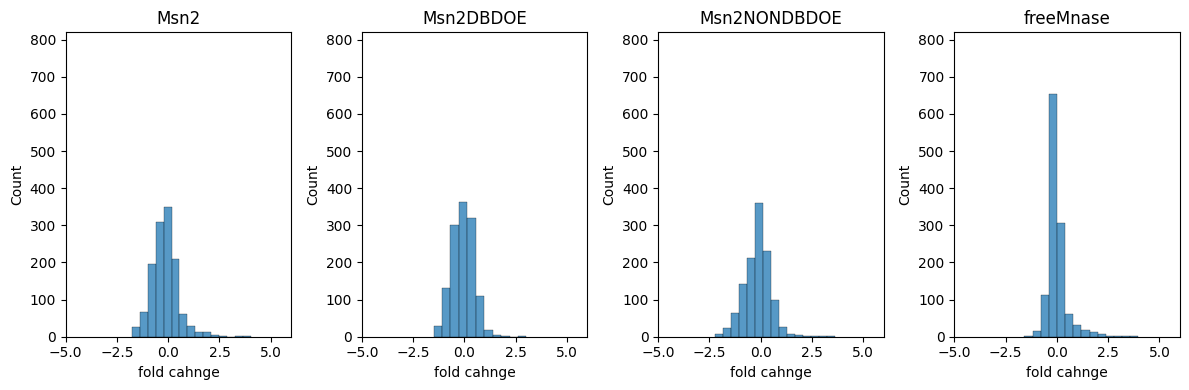

In [415]:
''' show the distribution of fold change values '''
''' run with threshold set to 0 '''
fig, axs = plt.subplots(1,4, figsize=(12,4))
for strain_i, strain in enumerate( ['Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'freeMnase'] ):
    curr_df = res_dict[strain]
    fc = curr_df.delta_med180_med0
    curr_ax = np.ravel(axs)[strain_i]
    sns.histplot(fc, linewidth=0.2, binwidth=0.4, ax= curr_ax)
    curr_ax.set_xlabel('fold cahnge')
    curr_ax.set_title(strain)
    curr_ax.set_ylim(0,820)
    curr_ax.set_xlim(-5,6)
plt.tight_layout()

plt.show()

## Figure S7H: p-values for correlation presented on Fig. 7B

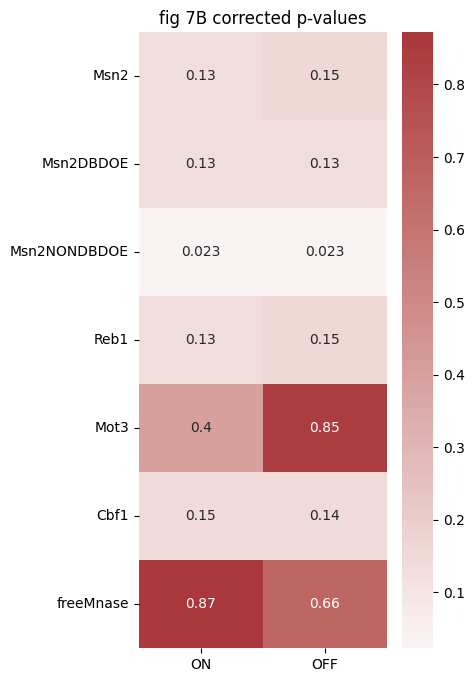

In [471]:
''' written also under Figure 7 '''
from statsmodels.stats.multitest import multipletests

# Flatten the array
p_values_list = pvals.flatten()
# Apply Benjamini-Hochberg correction
_, corrected_p_values, _, _ = multipletests(p_values_list, alpha=0.05, method='fdr_bh')
# Reshape back to the original array shape
corrected_p_values_array = corrected_p_values.reshape(pvals.shape)



fig,ax = plt.subplots(1,1,figsize=(4,8))
corrected_p_values_df = pd.DataFrame(corrected_p_values_array,index=tfs,columns=['ON','OFF'])
sns.heatmap(corrected_p_values_df,cmap='vlag',center=0,annot=True,ax=ax)
plt.title('fig 7B corrected p-values')
plt.show()



# Figure S8

## Figure S8: protein abundance and RNA expression FC

230.40498712333473


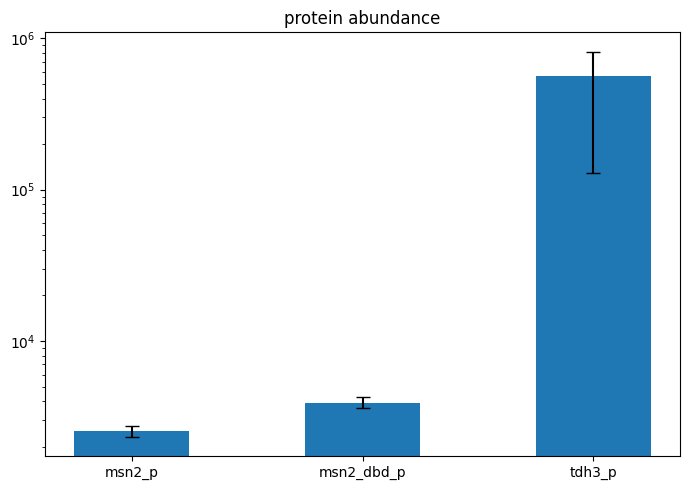

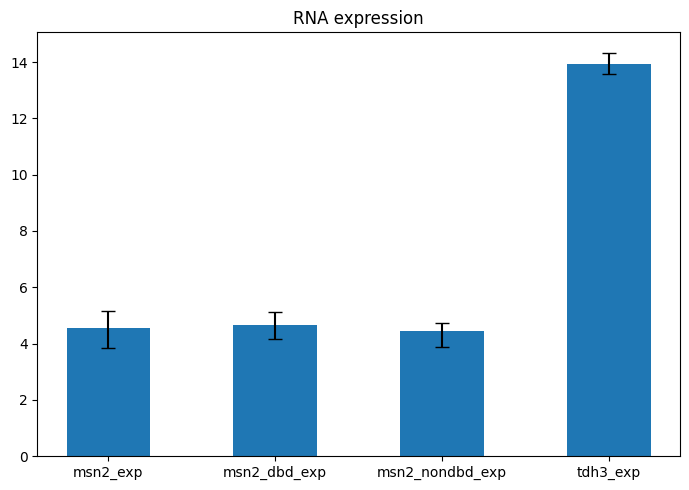

In [474]:
''' protein abundance avg '''
msn2_p_abn = np.array([2327, 2746, 2546]) # from Chong, de Godoy and Tkach
tdh3_p_abn = np.array([816996, 128984, 746358])
abn_fold   =  tdh3_p_abn.mean() / msn2_p_abn.mean()
abn_fold_by_source = np.array( [ tdh3_v / msn2_v for msn2_v, tdh3_v in list(zip(msn2_p_abn, tdh3_p_abn) )] ).mean()

''' Felix and Miri's Data https://academic.oup.com/nar/article/51/10/4831/7080830 '''
facs_dict = {'Msn2':[1,1], 'Msn2DBD':[1.41152913550469, 1.67876318383078]}
msn2_abn_avg = msn2_p_abn.mean()
tdh3_abn_avg = tdh3_p_abn.mean()
msn2_dbd_abn_est    = msn2_abn_avg * np.array(facs_dict['Msn2DBD'])
msn2_dbd_oe_abn_est = msn2_abn_avg * np.array(facs_dict['Msn2DBD']) * abn_fold_by_source # Msn2 protein abundance times the fold change of Msn2 FL to Msn2 DBD times the fold change of Msn2 FL to Tdh3
msn2_dbd_abn_avg    = msn2_dbd_abn_est.mean()
msn2_dbd_oe_abn_avg = msn2_dbd_oe_abn_est.mean()

''' RNA expression by Vova '''
df_path = '/home/labs/barkailab/matanv/CCCA/context_paper/revised paper/data/over expression extimate.csv'
exp_df = pd.read_csv(df_path,header=1)
exp_df = exp_df.iloc[0:2,:]
msn2_exp =        pd.to_numeric( exp_df.iloc[1,1:7], errors='coerce') 
msn2_dbd_exp =    pd.to_numeric( exp_df.iloc[1,7:9], errors='coerce')  
msn2_nondbd_exp = pd.to_numeric( exp_df.iloc[1,9:], errors='coerce')  
tdh3_exp =        pd.to_numeric( exp_df.iloc[0,1:], errors='coerce')  
print( abn_fold_by_source )
# Define function for asymmetric error calculation
def asymetric_error(data, mean_value):
    lower_error = mean_value - np.min(data)
    upper_error = np.max(data) - mean_value
    return lower_error, upper_error



# key order is [Msn2 FL, MSn2 DBD, Msn2 non - DBD, Tdh3, Msn2 DBD OE, Msn2 non - DBD  OE ]
# plot the protein abandance and RNA expression values and estimates

p_abundance_mean  = [msn2_abn_avg, msn2_dbd_abn_avg, tdh3_abn_avg ] #remove estimates
p_abundance_error = [asymetric_error(msn2_p_abn, msn2_abn_avg), asymetric_error(msn2_dbd_abn_est, msn2_dbd_abn_avg), asymetric_error(tdh3_p_abn, tdh3_abn_avg)]  #remove estimates

rna_exp_mean      = np.array([msn2_exp.mean(), msn2_dbd_exp.mean(), msn2_nondbd_exp.mean(), tdh3_exp.mean() ])
rna_exp_error     = np.array( [asymetric_error(msn2_exp, msn2_exp.mean()), asymetric_error(msn2_dbd_exp, msn2_dbd_exp.mean()), asymetric_error(msn2_nondbd_exp, msn2_nondbd_exp.mean()),
                               asymetric_error(tdh3_exp, tdh3_exp.mean()) ] )


p_labels = ['msn2_p', 'msn2_dbd_p','tdh3_p'] #remove estimates
exp_labels   = ['msn2_exp', 'msn2_dbd_exp', 'msn2_nondbd_exp', 'tdh3_exp']
labels = [p_labels, exp_labels]
curr_means = [p_abundance_mean, rna_exp_mean]
curr_errors = [p_abundance_error, rna_exp_error]
titles = ['protein abundance', 'RNA expression']


width = 0.5

for i in [0,1]:
    plt.figure(figsize=(7, 5))
    x = np.arange(len(labels[i]))
    curr_mean = curr_means[i]
    lower_errors = [ err[0] for err in curr_errors[i] ]
    upper_errors  = [ err[1] for err in curr_errors[i] ]
    bars = plt.bar(x, curr_mean, width, yerr=[lower_errors, upper_errors], capsize=5, align='center')
    # bars = plt.bar(x, np.log10(curr_mean), width, align='center')
    if i ==0:
        plt.yscale('log')
    else:
        plt.yscale('linear')
    plt.xticks(x, labels[i], ha='center')
    # plt.ticklabel_format(style='scientific', axis='y')
    plt.title(titles[i])
    plt.tight_layout()
    plt.show()

# Manuscript Text Data

In [ ]:
''' correaltion between FC repeats '''

for strain in ['Reb1', 'Cbf1']:
    print(strain, 'non activated rep. corr: ', res_dict[strain].loc[:, res_dict[strain].columns.str.contains('1_0') ].corr().mean().mean())
    print(strain, 'activated rep. corr:     ', res_dict[strain].loc[:, res_dict[strain].columns.str.contains('1_180') ].corr().mean().mean())
    
for strain in ['Reb1', 'Cbf1']:
    print(strain, 'min non activated rep. corr: ', res_dict[strain].loc[:, res_dict[strain].columns.str.contains('1_0') ].corr().min().min())
    print(strain, 'min activated rep. corr:     ', res_dict[strain].loc[:, res_dict[strain].columns.str.contains('1_180') ].corr().min().min())

In [ ]:
''' correlate Msn2 and freeMnase using screened z score, on + off in the same plot '''

fig, axs = plt.subplots(1,1, figsize=(7,7))
fig.suptitle('correlate on+off using z score and median of 3 embedding libraries')
corr_df = pd.DataFrame()
for strain in ['Msn2','freeMnase']:
    for c_on in ['_on', '_off']:
        corr_df = corr_df.merge(combined_seq_dict[strain+c_on+'_screened'].delta_median, how='outer', left_index=True, right_index=True, suffixes=['','_'+strain+c_on])
        corr_df.columns = corr_df.columns.str.replace('delta_median',strain+c_on)


    
curr_ax = axs
sns.heatmap(corr_df.corr(), annot=True, ax=curr_ax)


In [ ]:
''' correlate Msn2 and Med15 using screened z score, on + off in the same plot '''

fig, axs = plt.subplots(1,1, figsize=(12,12))
fig.suptitle('correlate on+off using z score and median of 3 embedding libraries')
corr_df = pd.DataFrame()
for strain in ['Msn2','Med15', 'Med15_ddmsns']:
    for c_on in ['_on', '_off']:
        corr_df = corr_df.merge(combined_seq_dict[strain+c_on+'_screened'].delta_median, how='outer', left_index=True, right_index=True, suffixes=['','_'+strain+c_on])
        corr_df.columns = corr_df.columns.str.replace('delta_median',strain+c_on)


    
curr_ax = axs
sns.heatmap(corr_df.corr(), annot=True, ax=curr_ax)


In [ ]:
''' correlate Msn2 nonDBD and Msn2 non DBD dMsn4 using screened z score, on + off in the same plot '''

fig, axs = plt.subplots(1,1, figsize=(7,7))
fig.suptitle('correlate on+off using z score and median of 3 embedding libraries')
corr_df = pd.DataFrame()
for strain in ['Msn2NONDBDOE','NONDBDOE_dmsn4']:
    for c_on in ['_on', '_off']:
        corr_df = corr_df.merge(combined_seq_dict[strain+c_on+'_screened'].delta_median, how='outer', left_index=True, right_index=True, suffixes=['','_'+strain+c_on])
        corr_df.columns = corr_df.columns.str.replace('delta_median',strain+c_on)


    
curr_ax = axs
sns.heatmap(corr_df.corr(), annot=True, ax=curr_ax)


# export experimental data

## create a sequences table of embedded STR / double deletion / IDR mutations libraries with the same columns as the sequences table of other libraries

### create sequences tables

In [ ]:
''' read a sequences table and create the missing columns - embedded STRs '''
old_df = pd.read_csv("/home/labs/barkailab/sagieb/Context_matan/cycle2/strcycle2_agilent.csv")
sample_df = pd.read_excel("/home/labs/barkailab/matanv/CCCA/context_paper/library_sequences/sequences/Cip1_libs.xls")
new_df = pd.DataFrame( columns= sample_df.columns)
new_df['Forward Primer Sequence'] = old_df.Fprimer
new_df['Forward Primer Name'] = old_df.Subset_number
new_df['Reverse Primer Sequence'] = old_df.Rprimer
new_df['Reverse Primer Name'] = old_df.Subset_number
new_df['Barcode'] = old_df.Barcode
new_df['STR'] = old_df.Seq_name.str.split('_').str[4]
new_df['STR length'] = new_df.STR.str.len()
new_df['Insert Sequence'] = old_df.Final_seq
new_df['Motif state'] = old_df.Seq_name.str.split('_').str[5].replace({'on': 'intact', 'off': 'mutated'})
# strain column is at the end
new_df['Promoter'] = old_df.Seq_name.str.split('_').str[3]
new_df['Sequence Name'] = old_df.Seq_name
new_df['lib'] = old_df.Subset_name
os.chdir(original_path)
for strain in ['Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE']:
    new_df['Transctiption Factor'] = [strain+'_emb'] * new_df.shape[0]
    new_df.to_excel('spaced_str_'+strain+'_libs.xls', index=False)

In [ ]:
''' read a sequences table and create the missing columns - double deletion '''
# del old_df  #clear any unused variables from previous cell
sample_df = pd.read_excel("/home/labs/barkailab/matanv/CCCA/context_paper/library_sequences/sequences/Cip1_libs.xls")
new_df = pd.DataFrame( columns= sample_df.columns)
new_df['Forward Primer Sequence'] = sample_df['Forward Primer Sequence']
new_df['Forward Primer Name'] = sample_df['Forward Primer Name']
new_df['Reverse Primer Sequence'] = sample_df['Reverse Primer Sequence']
new_df['Reverse Primer Name'] = sample_df['Reverse Primer Name']
new_df['Barcode'] = sample_df['Barcode']
new_df['STR'] = sample_df['STR']
new_df['STR length'] = sample_df['STR length']
new_df['Insert Sequence'] = sample_df['Insert Sequence']
new_df['Motif state'] = sample_df['Motif state']
# strain column is at the end
new_df['Promoter'] = sample_df['Promoter']
new_df['Sequence Name'] = sample_df['Sequence Name']
new_df['lib'] = sample_df.Subset_name
os.chdir(original_path)
for strain in ['Med15', 'NONDBDOE_dmsn4', 'Med15_ddmsns']:
    new_df['Transctiption Factor'] = [strain] * new_df.shape[0]
    new_df.to_excel(strain+'_libs.xls', index=False)

In [ ]:
''' read a sequences table and create the missing columns - IDR mutations '''
del old_df  #clear any unused variables from previous cell
sample_df = pd.read_excel("/home/labs/barkailab/matanv/CCCA/context_paper/library_sequences/sequences/Cip1_libs.xls")
new_df = pd.DataFrame( columns= sample_df.columns)
new_df['Forward Primer Sequence'] = sample_df['Forward Primer Sequence']
new_df['Forward Primer Name'] = sample_df['Forward Primer Name']
new_df['Reverse Primer Sequence'] = sample_df['Reverse Primer Sequence']
new_df['Reverse Primer Name'] = sample_df['Reverse Primer Name']
new_df['Barcode'] = sample_df['Barcode']
new_df['STR'] = sample_df['STR']
new_df['STR length'] = sample_df['STR length']
new_df['Insert Sequence'] = sample_df['Insert Sequence']
new_df['Motif state'] = sample_df['Motif state']
# strain column is at the end
new_df['Promoter'] = sample_df['Promoter']
new_df['Sequence Name'] = sample_df['Sequence Name']
os.chdir(original_path)
for strain in ['Msn2_LIVFtoY','Msn2_DEKRtoN','Msn2_NtoH']:
    new_df['Transctiption Factor'] = [strain] * new_df.shape[0]
    new_df.to_excel(strain+'_libs.xls', index=False)

### make a resutls table of raw results:
   all library sequences with their score before processing and after processing

In [ ]:
promoters = [ 'Aqr1','Cip1','Cwp2','Rho3','Cip1_Msn2DBDOE','Cip1_Msn2NONDBDOE','Cip1_freeMnase','spaced_str_Msn2','spaced_str_Msn2DBDOE','spaced_str_Msn2NONDBDOE',
             'Med15', 'NONDBDOE_dmsn4', 'Med15_ddmsns', 'Msn2_LIVFtoY', 'Msn2_DEKRtoN', 'Msn2_NtoH' ]
Msn2_emb_libs = ['Msn2_34mer_embedding_HOR7', 'Msn2_34mer_embedding_CIP1', 'Msn2_34mer_embedding_PGM2', 'Msn2_34mer_flanking_HOR7',
                 'Msn2_34mer_flanking_CIP1', 'Msn2_34mer_flanking_PGM2', 'Msn2_5mer_embedding_HOR7', 'Msn2_5mer_embedding_CIP1', 'Msn2_5mer_embedding_PGM2']
Msn2_emb_lib_map = {chr(ord('A')+i): lib  for i, lib in enumerate(Msn2_emb_libs) }
for prom in promoters:

    # load library sequences
    seq_lib_path = f'/home/labs/barkailab/matanv/CCCA/context_paper/library_sequences/sequences/{prom}_libs.xls'
    lib_seq_df = pd.read_excel(seq_lib_path)
    strain = lib_seq_df['Transctiption Factor'][0]
    new_columns = res_dict[strain].columns[[0,1,2,3,4,5,8,14,21]]
    # add lib index (letters)
    r_primers = lib_seq_df['Reverse Primer Name'].unique()
    mapping_dict = {primer: chr(ord('A') + i) for i, primer in enumerate(r_primers)}
    state_map    = {'intaxt':'on', 'mutated':'off'}
    lib_seq_df['lib_i'] = lib_seq_df['Reverse Primer Name'].map(mapping_dict)
    # get read numbers for each sequence after processing
    for seq in lib_seq_df.iterrows():
        seq_i = seq[0]
        strain = lib_seq_df['Transctiption Factor'][seq_i]
        curr_lib_i = lib_seq_df['lib_i'][seq_i]
        curr_nuc_comb = lib_seq_df['STR'][seq_i]
        motif_state = lib_seq_df['Motif state'][seq_i]
        curr_on_state = state_map.get(motif_state, motif_state)
        

        curr_data = res_dict[strain].query("lib_i==@curr_lib_i & nuc_comb==@curr_nuc_comb & on_state==@curr_on_state ").iloc[:,[0,1,2,3,4,5,8,14,21]]
        if curr_data.shape[0] != 0:
            lib_seq_df.loc[seq_i, new_columns] = curr_data.iloc[0]
        
    if strain == 'freeMnase': # for freeMnase
        exp_num = 30
        rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')  # path for rm_samples function .csv
        
    if '_emb' in strain:  # for embedded STRs
        exp_num = 29
        rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/spaced_STRs', 'data') # path for rm_samples function .csv
        
    if 'ed15' in strain or 'dmsn' in strain:  # for double deletion
        exp_num = 29
        rm_samples_path = '/home/labs/barkailab/matanv/CCCA/data_ddmsn2/data'  # path for rm_samples function .csv
        
    if 'to' in strain:  # for IDR mutants
        exp_num = 29
        rm_samples_path = '/home/labs/barkailab/wajdm/context/scripts'  # path for rm_samples function .csv
        
    else:
        exp_num = 29
        rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')  # path for rm_samples function .csv

    for curr_lib_i in np.unique( lib_seq_df['lib_i'] ):
        if (strain[:4] == 'Msn2' or 'ed15' in strain or 'dmsn' in strain or strain == 'freeMnase') and ('_emb' not in strain):
            lib_num = 'Msn2'+curr_lib_i
        elif '_emb' in strain:
            lib_num = Msn2_emb_lib_map.get(curr_lib_i, curr_lib_i)
        else:
            lib_num = strain+curr_lib_i
        lib_seq_screened_df = rm_samples_from_publishable_data(strain, lib_num, exp_num, lib_seq_df)
        lib_seq_screened_df.to_csv(f'/home/labs/barkailab/matanv/CCCA/context_paper/library_sequences/sequences with scores Nov24/{strain}_libraries_and_results.csv')

## export avg(on,off) for each strain used

In [ ]:

combined_seq_dict[strain+'_'+'on']

In [ ]:
strains = ['Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'Mot3', 'Cbf1', 'Reb1', 'freeMnase', 'Msn2_LIVFtoY', 'Msn2_DEKRtoN', 'Msn2_NtoH', 
           'NONDBDOE_dmsn4', 'Med15_ddmsns', 'Med15', 'Msn2_emb', 'Msn2DBDOE_emb', 'Msn2NONDBDOE_emb']

for strain_i, strain in enumerate(strains):
    if strain + '_on_screened' in combined_seq_dict.keys():

        curr_df = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('_on','_off'), left_index=True, right_index=True )
    else:

        curr_df = combined_seq_dict[strain+'_'+'on'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'].query("index!='genome'"), how='inner', suffixes=('_on','_off'), left_index=True, right_index=True )
    curr_df = curr_df.loc[:,curr_df.columns.str.contains('delta_median')]
    curr_df['avg_delta_median'] = curr_df.mean(axis=1)
    curr_df = curr_df.sort_values(by='avg_delta_median')
    curr_df.to_csv(f'/home/labs/barkailab/matanv/CCCA/context_paper/out_data/avg(on,off)_Nov24/{strain}_avg(on,off)_sorted.csv')


In [ ]:

def rm_samples_from_publishable_data(tf, lib_num, exp_num, res_table):
    '''This function removes from the result table the samples classified as bad. It gets the result table
    (before or after normalization) and the relevant tf, library number and experiment number.'''
    exp_num = int(exp_num)
    curr_lib_i = lib_num[-1]
    samples_to_remove = pd.read_csv(os.path.join(rm_samples_path, 'samples_to_remove.csv'))
    # read csv containing info about samples to remove
    curr_samples_to_rm = samples_to_remove.loc[(samples_to_remove['Lib_number'] == str(lib_num)) &
                                               (samples_to_remove['Exp_number'] == exp_num) &
                                               (samples_to_remove['TF'] == tf)]

    # get the names of samples to remove relevant to the input
    # max_tech_rep_num = max(
    #     [int(name.split('_')[-1]) for name in res_table.columns])  # number of time point repeats in the experiment
    # var_num = len(res_table)  # number of variants
    samples_to_rm_names = curr_samples_to_rm['Sample_name']  # the sample names that will be removed
    
    sample_bio_rep = np.array(
        [int(name.split('_')[0]) for name in samples_to_rm_names])  # the bio repeats of the bad samples
    sample_tps = np.array(
        [int(name.split('_')[1]) for name in samples_to_rm_names])  # the time point of the bad samples
    sample_tech_rep = np.array(
        [int(name.split('_')[-1]) for name in samples_to_rm_names])  # the technical repeats of the bad samples
    for sample_name in samples_to_rm_names:
        condition = res_table['lib_i'] == curr_lib_i
        res_table.loc[condition, sample_name] = res_table.loc[condition, sample_name].map(lambda x: x if np.isnan(x) else 'low correlation sample')
    return(res_table)
